# Proyecto ISIS-3302 (Modelado, Optimización y Simulación)

- Paulina Arrazola Vernaza - 202020631
- Santiago Alejandro Jaimes Puerto - 201912921
- Nicolás Rincón Sánchez - 202021963

# Etapa III (Metaheurística)

## 1. Implementación de Metaheurísticas (GA)

### 1.1 Importación de Librerías

In [24]:
import pandas as pd
import numpy as np
import random
import math
import requests
import time
import os
import json
import itertools 
from collections import OrderedDict
import sys
import matplotlib.pyplot as plt
import csv

### 1.2 Carga y estructuración de los datos

In [25]:
OSRM_URL = "https://router.project-osrm.org/table/v1/driving/"
C_KM = 20700  # COP/km. Esta constante se saca del análisis realizado en la etapa 1 de costos de transporte 

GA_DATA = {
    "depot_id": None,
    "depot_coords": None,
    "client_ids": [],
    "client_coords": {}, 
    "client_demands": {},
    "all_node_ids": [],
    "all_node_coords": {}, 
    "vehicle_capacity": [], 
    "vehicle_range": [], 
    "num_available_vehicles": 0,
    "distance_matrix": {},
    "cost_matrix": {}, 
}


def load_data(case_name_str):

    # Esctructura
    GA_DATA["depot_id"] = None
    GA_DATA["depot_coords"] = None
    GA_DATA["client_ids"] = []
    GA_DATA["client_coords"] = {}
    GA_DATA["client_demands"] = {}
    GA_DATA["all_node_ids"] = []
    GA_DATA["all_node_coords"] = {}
    GA_DATA["vehicle_capacity"] = [] 
    GA_DATA["vehicle_range"] = []  
    GA_DATA["num_available_vehicles"] = 0
    GA_DATA["distance_matrix"] = {}
    GA_DATA["cost_matrix"] = {}

    base_data_path = "Etapa3/data/Proyecto_A_"
    depots_df_path = f"{base_data_path}CasoBase/depots.csv"

    if case_name_str == "Base":
        clients_df_path = f"{base_data_path}CasoBase/clients.csv"
        vehicles_df_path = f"{base_data_path}CasoBase/vehicles.csv"
    elif case_name_str == "2":
        clients_df_path = f"{base_data_path}Caso2/clients.csv"
        vehicles_df_path = f"{base_data_path}Caso2/vehicles.csv"
    elif case_name_str == "3":
        clients_df_path = f"{base_data_path}Caso3/clients.csv"
        vehicles_df_path = f"{base_data_path}Caso3/vehicles.csv"
    else:
        print(f"Error: Unknown case_name '{case_name_str}'", file=sys.stderr)
        sys.exit(1)

    try:
        depots_df = pd.read_csv(depots_df_path)
        if depots_df.empty:
            raise ValueError(f"Depots CSV ({depots_df_path}) is empty or not found.")
        first_depot_row = depots_df.iloc[0]
        GA_DATA["depot_id"] = f"D{int(first_depot_row['DepotID'])}"
        GA_DATA["depot_coords"] = (float(first_depot_row['Latitude']), float(first_depot_row['Longitude']))
        GA_DATA["all_node_ids"].append(GA_DATA["depot_id"])
        GA_DATA["all_node_coords"][GA_DATA["depot_id"]] = GA_DATA["depot_coords"]

        clients_df = pd.read_csv(clients_df_path)
        if clients_df.empty:
            raise ValueError(f"Clients CSV ({clients_df_path}) is empty or not found.")
        if 'Demand' not in clients_df.columns:
            raise ValueError(f"'Demand' column missing in {clients_df_path}.")
        for idx, row in clients_df.iterrows():
            client_id_val = row['ClientID']
            if isinstance(client_id_val, float) and client_id_val.is_integer():
                client_id_val = int(client_id_val)
            client_id_str = f"C{client_id_val}"
            GA_DATA["client_ids"].append(client_id_str)
            GA_DATA["all_node_ids"].append(client_id_str)
            client_coords = (float(row['Latitude']), float(row['Longitude']))
            GA_DATA["client_coords"][client_id_str] = client_coords
            GA_DATA["all_node_coords"][client_id_str] = client_coords
            GA_DATA["client_demands"][client_id_str] = float(row['Demand'])
        print(f"Loaded {len(GA_DATA['client_ids'])} clients for Case {case_name_str}. First few: {GA_DATA['client_ids'][:5]}")

        # Sección de carga de vehículos
        vehicles_df = pd.read_csv(vehicles_df_path)
        if vehicles_df.empty:
            raise ValueError(f"Vehicles CSV ({vehicles_df_path}) is empty or not found.")
        if 'Range' not in vehicles_df.columns or 'Capacity' not in vehicles_df.columns:
            raise ValueError(f"'Range' or 'Capacity' column missing in {vehicles_df_path}.")
        
        # Cargar rangos y capacidades como listas
        GA_DATA["vehicle_range"] = vehicles_df['Range'].tolist()
        GA_DATA["vehicle_capacity"] = vehicles_df['Capacity'].tolist()
        GA_DATA["num_available_vehicles"] = len(vehicles_df)

    except FileNotFoundError as e:
        print(f"File not found. {e}", file=sys.stderr)
        sys.exit(1)
    except ValueError as e: 
        print(f"Name issue. {e}", file=sys.stderr)
        sys.exit(1)
    except KeyError as e: 
        print(f"Missing expected column in CSV. Problematic column: {e}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}", file=sys.stderr)
        sys.exit(1)


    # Calculo OSRM de distancias
    print("--- Calculating Distance Matrix using OSRM ---")
    N_ga = GA_DATA["all_node_ids"]
    coords_ga = GA_DATA["all_node_coords"]
    if not GA_DATA["client_ids"]:
         print(f"No clients were loaded for Case {case_name_str}. GA cannot proceed.", file=sys.stderr)
    CACHE_FILE_GA = f'Etapa3/cache/osrm_cache_ga_{case_name_str.lower().replace(" ", "_")}.json'
    os.makedirs(os.path.dirname(CACHE_FILE_GA), exist_ok=True)

    dist_cache = {}
    if os.path.exists(CACHE_FILE_GA):
        try:
            with open(CACHE_FILE_GA, 'r') as f:
                raw_cache = json.load(f)
            dist_cache = {tuple(k.split("|")): v for k, v in raw_cache.items()}
            print(f"  Distances loaded from GA cache ({len(dist_cache)} pairs): {CACHE_FILE_GA}")
        except json.JSONDecodeError:
            dist_cache = {}
    
    all_pairs_to_calculate = list(itertools.product(N_ga, N_ga))
    missing_pairs = [p for p in all_pairs_to_calculate if p not in dist_cache and p[0] != p[1]] 

    MAX_COORDS_OSRM = 100 

    # Revisa si hay pares de nodos que faltan en el cache
    if missing_pairs:
        BATCH_SIZE = max(1, MAX_COORDS_OSRM // 2) 
        
        for i_start_node_batch_start in range(0, len(N_ga), BATCH_SIZE):
            sources_nodes = N_ga[i_start_node_batch_start : i_start_node_batch_start + BATCH_SIZE]
            
            for j_start_node_batch_start in range(0, len(N_ga), BATCH_SIZE):
                dests_nodes = N_ga[j_start_node_batch_start : j_start_node_batch_start + BATCH_SIZE]
                
                current_query_nodes = list(OrderedDict.fromkeys(sources_nodes + dests_nodes)) 
                if not current_query_nodes: continue

                node_to_idx_map = {node_id: k for k, node_id in enumerate(current_query_nodes)}
                query_coords_str = ";".join([f"{coords_ga[n][1]},{coords_ga[n][0]}" for n in current_query_nodes])
                
                src_indices_in_query = ";".join(str(node_to_idx_map[n]) for n in sources_nodes if n in node_to_idx_map)
                dst_indices_in_query = ";".join(str(node_to_idx_map[n]) for n in dests_nodes if n in node_to_idx_map)

                if not src_indices_in_query or not dst_indices_in_query: continue

                url_batch = f"{OSRM_URL}{query_coords_str}"
                params_batch = {
                    "sources": src_indices_in_query,
                    "destinations": dst_indices_in_query,
                    "annotations": "distance"
                }
                # Hace la peticiín a OSRM
                try:
                    r = requests.get(url_batch, params=params_batch, timeout=180)
                    r.raise_for_status()
                    matrix_data = r.json()
                    if "distances" not in matrix_data or not matrix_data["distances"]:
                        for u_node_s in sources_nodes:
                            for v_node_d in dests_nodes:
                                if (u_node_s, v_node_d) not in dist_cache: dist_cache[(u_node_s, v_node_d)] = float('inf')
                        continue
                    
                    batch_distances = matrix_data["distances"]
                    for src_idx_local, u_node_s in enumerate(sources_nodes):
                        for dst_idx_local, v_node_d in enumerate(dests_nodes):
                            if u_node_s == v_node_d:
                                dist_cache[(u_node_s, v_node_d)] = 0.0
                                continue
                            if src_idx_local < len(batch_distances) and dst_idx_local < len(batch_distances[src_idx_local]):
                                dist_val = batch_distances[src_idx_local][dst_idx_local]
                                dist_cache[(u_node_s, v_node_d)] = float('inf') if dist_val is None else dist_val / 1000.0
                            else:
                                dist_cache[(u_node_s, v_node_d)] = float('inf')

                except requests.exceptions.Timeout:
                    print(f"    Error: OSRM request timed out for batch. Assigning Inf.")
                    for u_node_s in sources_nodes:
                        for v_node_d in dests_nodes:
                            if (u_node_s, v_node_d) not in dist_cache: dist_cache[(u_node_s, v_node_d)] = float('inf')
                except requests.exceptions.RequestException as e_req:
                    print(f"    Error: OSRM request failed for batch: {e_req}. Assigning Inf.")
                    for u_node_s in sources_nodes:
                        for v_node_d in dests_nodes:
                            if (u_node_s, v_node_d) not in dist_cache: dist_cache[(u_node_s, v_node_d)] = float('inf')
        
        # Guarda el cache actualizado
        ordered_dist_cache_to_save = OrderedDict()
        sorted_nodes_for_cache = sorted(N_ga) 
        for u_node in sorted_nodes_for_cache:
            for v_node in sorted_nodes_for_cache:
                ordered_dist_cache_to_save[f"{u_node}|{v_node}"] = dist_cache.get((u_node, v_node), float('inf') if u_node !=v_node else 0.0)

        with open(CACHE_FILE_GA, 'w') as f:
            json.dump(ordered_dist_cache_to_save, f, indent=2)
        print(f"  GA OSRM cache updated: {CACHE_FILE_GA}")
    else:
        print(f"  No missing distance pairs for Case {case_name_str}")

    # Poblar matrices de distancia y costo
    for u_node in N_ga:
        for v_node in N_ga:
            if u_node == v_node:
                GA_DATA["distance_matrix"][(u_node, v_node)] = 0.0
                GA_DATA["cost_matrix"][(u_node, v_node)] = 0.0
            else:
                dist = dist_cache.get((u_node, v_node), float('inf'))
                GA_DATA["distance_matrix"][(u_node, v_node)] = dist
                GA_DATA["cost_matrix"][(u_node, v_node)] = dist * C_KM
    
    print(f"Distance and cost matrices populated for case {case_name_str}. {len(GA_DATA['distance_matrix'])} entries.")
    if GA_DATA["depot_id"] in GA_DATA["client_ids"]: 
        print(f"Depot ID {GA_DATA['depot_id']} is also in client_ids list for Case {case_name_str}!", file=sys.stderr)
        sys.exit(1)
    print(f"--- DATA LOADING COMPLETE FOR CASE {case_name_str} ---")




In [26]:
# Visualización de los datos cargados en GA_DATA
def visualize_ga_data():
    print("--- Visualizing GA_DATA ---")
    df = pd.DataFrame.from_dict(GA_DATA, orient='index')
    print(df)

visualize_ga_data()

--- Visualizing GA_DATA ---
                           0
depot_id                None
depot_coords            None
client_ids                []
client_coords             {}
client_demands            {}
all_node_ids              []
all_node_coords           {}
vehicle_capacity          []
vehicle_range             []
num_available_vehicles     0
distance_matrix           {}
cost_matrix               {}


### 1.3 Algorítmo Genético (cromosomas, fitness, cruce, mutación, etc.)

In [27]:
# Decodifica un cromosoma en una lista de rutas. 
# Cada ruta comienza y termina en el depósito y respeta la capacidad y rango específicos del vehículo
def decode_chromosome_to_routes(chromosome, data):
    routes = []
    current_route_nodes = [data["depot_id"]]
    current_route_capacity_load = 0
    current_route_distance_travelled = 0
    current_vehicle_idx = 0
    
    total_solution_cost = 0
    feasibility_penalty = 0
    clients_to_visit_ordered = list(chromosome)
    chromosome_client_idx = 0

    # Ordenar los clientes para visitar en el orden del cromosoma
    while chromosome_client_idx < len(clients_to_visit_ordered):
        if current_vehicle_idx >= data["num_available_vehicles"]:
            # Si no hay más vehículos disponibles, penalizar por falta de viabilidad 
            remaining_unserved = len(clients_to_visit_ordered) - chromosome_client_idx
            feasibility_penalty += remaining_unserved * 10_000_000
            break

        
        client_id_to_try = clients_to_visit_ordered[chromosome_client_idx]
        client_demand = data["client_demands"].get(client_id_to_try, float('inf'))
        current_vehicle_capacity = data["vehicle_capacity"][current_vehicle_idx]
        current_vehicle_range = data["vehicle_range"][current_vehicle_idx]
        needs_new_vehicle = (len(current_route_nodes) == 1 and current_route_nodes[0] == data["depot_id"])
        
        # Si es el primer cliente de la ruta, verificar si se necesita un nuevo vehículo
        if needs_new_vehicle:
            current_route_capacity_load = 0
            current_route_distance_travelled = 0

        can_add_this_client = True
        last_node = current_route_nodes[-1]
        dist_to_client = data["distance_matrix"].get((last_node, client_id_to_try), float('inf'))
        dist_to_depot = data["distance_matrix"].get((client_id_to_try, data["depot_id"]), float('inf'))

        # Verificar capacidad y distancia
        if dist_to_client == float('inf') or dist_to_depot == float('inf'):
            can_add_this_client = False
            feasibility_penalty += 20_000_000

        # Calcular nueva carga y distancia si se agrega el cliente en la ruta
        new_load = current_route_capacity_load + client_demand
        new_distance = current_route_distance_travelled + dist_to_client + dist_to_depot

        if new_load > current_vehicle_capacity:
            can_add_this_client = False
        
        if new_distance > current_vehicle_range:
            can_add_this_client = False

        # Si las verificaciones son correctas, se agrega el cliente a la ruta
        if can_add_this_client:
            current_route_nodes.append(client_id_to_try)
            current_route_capacity_load = new_load
            current_route_distance_travelled += dist_to_client
            chromosome_client_idx += 1
        else:
            if needs_new_vehicle:
                # Penalizar por no poder servir al cliente con el vehículo actual
                feasibility_penalty += 50_000_000
                # Si no se puede servir al cliente con el vehículo actual se pasa al siguiente vehículo
                chromosome_client_idx += 1
            else:
                if len(current_route_nodes) > 1:
                    dist_return = data["distance_matrix"].get((current_route_nodes[-1], data["depot_id"]), float('inf'))
                    if dist_return == float('inf'):
                        # Penalizar por no regresar al depósito
                        feasibility_penalty += 20_000_000
                    else:
                        final_route_dist = current_route_distance_travelled + dist_return
                        # Costo de la ruta final que se calcula con la distancia final y el costo fijo por km
                        total_solution_cost += final_route_dist * C_KM
                    routes.append((current_vehicle_idx, list(current_route_nodes) + [data["depot_id"]]))
                current_route_nodes = [data["depot_id"]]
                current_route_capacity_load = 0
                current_route_distance_travelled = 0
                current_vehicle_idx += 1

    # Completar última ruta si es necesario
    if len(current_route_nodes) > 1:
        dist_return_last = data["distance_matrix"].get((current_route_nodes[-1], data["depot_id"]), float('inf'))
        if dist_return_last == float('inf'):
            # Penalizar por no ser capaz de regresar al depósito
            feasibility_penalty += 20_000_000
        else:
            final_route_dist = current_route_distance_travelled + dist_return_last
            total_solution_cost += final_route_dist * C_KM
        routes.append((current_vehicle_idx, list(current_route_nodes) + [data["depot_id"]]))

    # Verificar clientes no servidos
    served_clients = set()
    for _, route in routes:
        for node in route:
            if node != data["depot_id"]:
                served_clients.add(node)

    # Penalizar por clientes no servidos
    for client in chromosome:
        if client not in served_clients:
            feasibility_penalty += 1_000_000

    return routes, total_solution_cost, feasibility_penalty

# Calcula el fitness de un indiciduo
# Menos fitness (costo) es mejor
def calculate_cvrp_fitness(chromosome_individual, data):
    # Asegurar que el cromosoma contiende todos los clientes exactamente una vez
    if sorted(chromosome_individual) != sorted(data["client_ids"]):
        return float('inf') # Cromosoma invalido se penaliza con infinito

    routes, decoded_cost, penalty = decode_chromosome_to_routes(chromosome_individual, data)
    fitness = decoded_cost + penalty
    return fitness

# Genera una población inicial de cromosomas aleatorios
def generate_initial_population(size, client_ids_list):
    population = []
    for _ in range(size):
        # Copia de la lista de clientes que se mezcla
        individual = list(client_ids_list) 
        random.shuffle(individual)
        population.append(individual)
    return population

# Selección por torneo
def selection_by_tournament(population, fitness_func, data, k=3):
    selected_parents = []
    for _ in range(len(population)):
        participants = random.sample(population, k)
        # Evaluar la aptitud de los participantes
        participant_fitnesses = [fitness_func(ind, data) for ind in participants]
        winner = participants[participant_fitnesses.index(min(participant_fitnesses))]
        selected_parents.append(list(winner))
    return selected_parents

# Se utiliza Order Crossover (OX) para combinar dos padres en un hijo
def order_crossover(parent1, parent2):
    size = len(parent1)
    child = [None] * size
    
    # Se seleccionan puntos de inicio y fin aleatorios
    start, end = sorted(random.sample(range(size), 2))


    child[start:end+1] = parent1[start:end+1]
    parent2_elements = [item for item in parent2 if item not in child[start:end+1]]
    current_pos = 0
    for i in range(size):
        if child[i] is None:
            child[i] = parent2_elements[current_pos]
            current_pos += 1
    return child

# Realiza una mutación de intercambio en un individuo con una probabilidad dada
def swap_mutation(individual, mutation_rate):
    mutated_individual = list(individual)
    if random.random() < mutation_rate:
        idx1, idx2 = random.sample(range(len(mutated_individual)), 2)
        mutated_individual[idx1], mutated_individual[idx2] = mutated_individual[idx2], mutated_individual[idx1]
    return mutated_individual

# Algortimo genético (GA) para resolver el CVRO
def run_genetic_algorithm_cvrp(data, pop_size, generations, mutation_rate, tournament_k):
    client_ids_list = data["client_ids"]

    # Inicaliza la población, el mejor fitness y el mejor cromosoma
    population = generate_initial_population(pop_size, client_ids_list)
    best_overall_fitness = float('inf')
    best_overall_chromosome = None
    
    generation_log = []

    for gen in range(generations):
        # Evalua el fitness para la población actual
        fitness_values = [calculate_cvrp_fitness(ind, data) for ind in population]
        
        # Encuenta el mejor cromosoma de la generación actual
        min_fitness_current_gen = min(fitness_values)
        best_chromosome_current_gen = population[fitness_values.index(min_fitness_current_gen)]
        
        if min_fitness_current_gen < best_overall_fitness:
            best_overall_fitness = min_fitness_current_gen
            best_overall_chromosome = list(best_chromosome_current_gen) 
        
        avg_fitness_current_gen = sum(fitness_values) / len(fitness_values)
        generation_log.append((gen + 1, best_overall_fitness, avg_fitness_current_gen))
        print(f"Generation {gen+1}/{generations} | Best Fitness: {best_overall_fitness:.2f} | Avg Fitness: {avg_fitness_current_gen:.2f}")
        
        # Selección
        parents = selection_by_tournament(population, calculate_cvrp_fitness, data, k=tournament_k)
        
        # Cruce y mutación
        next_population = []
        
        for i in range(0, pop_size, 2):
            if i + 1 < len(parents):
                p1 = parents[i]
                p2 = parents[i+1] # Si el tamaño de la población es impar, el último padre no se cruza
                
                child1 = order_crossover(p1, p2)
                child2 = order_crossover(p2, p1)
                
                child1_mutated = swap_mutation(child1, mutation_rate)
                child2_mutated = swap_mutation(child2, mutation_rate)
                
                next_population.append(child1_mutated)
                next_population.append(child2_mutated)
            elif i < len(parents): 
                next_population.append(parents[i])

        # Si la población resultante es menor que el tamaño deseado, se añaden mutaciones de padres aleatorios
        if len(next_population) < pop_size : 
             if parents:
                 needed = pop_size - len(next_population)
                 for _ in range(needed):
                    next_population.append(swap_mutation(random.choice(parents), mutation_rate))


        population = next_population[:pop_size] # Asegurar que la población

    print("--- Genetic Algorithm Finished ---")
    return best_overall_chromosome, best_overall_fitness, generation_log

## 2. Calibración y experimentación

### 2.1 Plan experimental para Calibracion de Parametros

Para el proceso de calibración de parámetros del algoritmo genético aplicado al CVRP, se ha diseñado un plan experimental estructurado basado en un enfoque factorial completo. Este método permite explorar sistemáticamente el espacio de parámetros clave (tamaño de población, tasa de mutación, número de generaciones y tamaño del torneo de selección) evaluando todas sus posibles combinaciones dentro de rangos predefinidos. Para garantizar la robustez estadística de los resultados, cada configuración se ejecutará en tres corridas independientes utilizando diferentes semillas aleatorias (42, 123 y 7890), lo que mitiga el efecto de la estocasticidad inherente a los algoritmos metaheurísticos. Durante la experimentación se registrarán métricas cruciales como el valor de la función objetivo (costo total de las rutas), tiempo de CPU, y estadísticas descriptivas (mejor valor, peor valor, media y desviación estándar) para cada configuración. Este rigor metodológico permitirá identificar la combinación óptima de parámetros que equilibre la calidad de las soluciones con la eficiencia computacional, mejorando así el rendimiento general del algoritmo para los diversos casos de prueba considerados en este estudio.

### 2.2 Experimentación con diferentes semillas
### 2.3 Mejor configuración y estadísticas relevantes


--- CALIBRATING FOR CASE: Base ---
Loaded 24 clients for Case Base. First few: ['C1', 'C2', 'C3', 'C4', 'C5']
--- Calculating Distance Matrix using OSRM ---
  Distances loaded from GA cache (625 pairs): Etapa3/cache/osrm_cache_ga_base.json
  No missing distance pairs for Case Base
Distance and cost matrices populated for case Base. 625 entries.
--- DATA LOADING COMPLETE FOR CASE Base ---

--- INICIANDO CALIBRACIÓN PARA CASO: Base ---

Loaded 24 clients for Case Base. First few: ['C1', 'C2', 'C3', 'C4', 'C5']
--- Calculating Distance Matrix using OSRM ---
  Distances loaded from GA cache (625 pairs): Etapa3/cache/osrm_cache_ga_base.json
  No missing distance pairs for Case Base
Distance and cost matrices populated for case Base. 625 entries.
--- DATA LOADING COMPLETE FOR CASE Base ---
Plan experimental: 54 configuraciones × 3 corridas = 162 experimentos
Parámetros evaluados: {'population_size': [50, 100, 150], 'generations': [100, 200], 'mutation_rate': [0.05, 0.1, 0.15], 'tournament_k

Progreso de calibración:   0%|          | 0/54 [00:00<?, ?it/s]


Configuración #1/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9711398.79
Generation 2/100 | Best Fitness: 8123394.15 | Avg Fitness: 9548980.67
Generation 3/100 | Best Fitness: 7511630.49 | Avg Fitness: 9149562.45
Generation 4/100 | Best Fitness: 7511630.49 | Avg Fitness: 8888428.02
Generation 5/100 | Best Fitness: 7347429.81 | Avg Fitness: 8734893.39
Generation 6/100 | Best Fitness: 7347429.81 | Avg Fitness: 8653099.45
Generation 7/100 | Best Fitness: 6969961.17 | Avg Fitness: 8515468.88
Generation 8/100 | Best Fitness: 6969961.17 | Avg Fitness: 8391033.31
Generation 9/100 | Best Fitness: 6969961.17 | Avg Fitness: 8095801.75
Generation 10/100 | Best Fitness: 6961563.18 | Avg Fitness: 8117238.51
Generation 11/100 | Best Fitness: 6739574.31 | Avg Fitness: 8069207.51
Generation 12/100 | Best Fitness: 6739574.31 | Avg Fitness: 7797965.68
Generation 13/100 | B

Progreso de calibración:   2%|▏         | 1/54 [00:02<02:17,  2.59s/it]

Generation 93/100 | Best Fitness: 5645202.57 | Avg Fitness: 5680327.28
Generation 94/100 | Best Fitness: 5645202.57 | Avg Fitness: 5756664.54
Generation 95/100 | Best Fitness: 5645202.57 | Avg Fitness: 5736442.42
Generation 96/100 | Best Fitness: 5645202.57 | Avg Fitness: 5700576.97
Generation 97/100 | Best Fitness: 5645202.57 | Avg Fitness: 5667270.84
Generation 98/100 | Best Fitness: 5645202.57 | Avg Fitness: 5722477.20
Generation 99/100 | Best Fitness: 5645202.57 | Avg Fitness: 5752911.21
Generation 100/100 | Best Fitness: 5645202.57 | Avg Fitness: 5691156.40
--- Genetic Algorithm Finished ---

Configuración #2/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9711398.79
Generation 2/100 | Best Fitness: 8123394.15 | Avg Fitness: 9576863.20
Generation 3/100 | Best Fitness: 7418393.55 | Avg Fitness: 9147802.33
Generation 4/100 | Best Fitness: 7418393.55 | Avg 

Progreso de calibración:   4%|▎         | 2/54 [00:06<03:02,  3.51s/it]

Generation 97/100 | Best Fitness: 5461593.57 | Avg Fitness: 5486885.49
Generation 98/100 | Best Fitness: 5461593.57 | Avg Fitness: 5532887.02
Generation 99/100 | Best Fitness: 5461593.57 | Avg Fitness: 5485237.81
Generation 100/100 | Best Fitness: 5461593.57 | Avg Fitness: 5495601.27
--- Genetic Algorithm Finished ---

Configuración #3/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9711398.79
Generation 2/100 | Best Fitness: 7442304.12 | Avg Fitness: 9202436.84
Generation 3/100 | Best Fitness: 7057238.58 | Avg Fitness: 8547431.25
Generation 4/100 | Best Fitness: 6925100.13 | Avg Fitness: 8070624.55
Generation 5/100 | Best Fitness: 6838483.05 | Avg Fitness: 7647160.14
Generation 6/100 | Best Fitness: 6764884.20 | Avg Fitness: 7349472.15
Generation 7/100 | Best Fitness: 6513008.67 | Avg Fitness: 7151007.59
Generation 8/100 | Best Fitness: 6513008.67 | Avg Fitn

Progreso de calibración:   6%|▌         | 3/54 [00:11<03:30,  4.13s/it]

--- Genetic Algorithm Finished ---

Configuración #4/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9711398.79
Generation 2/100 | Best Fitness: 8065841.94 | Avg Fitness: 9539684.96
Generation 3/100 | Best Fitness: 7692304.23 | Avg Fitness: 9200606.46
Generation 4/100 | Best Fitness: 7692304.23 | Avg Fitness: 9110801.41
Generation 5/100 | Best Fitness: 7517058.03 | Avg Fitness: 9095141.16
Generation 6/100 | Best Fitness: 7425611.64 | Avg Fitness: 8848073.62
Generation 7/100 | Best Fitness: 7215442.47 | Avg Fitness: 8660744.37
Generation 8/100 | Best Fitness: 7063792.20 | Avg Fitness: 8508735.37
Generation 9/100 | Best Fitness: 6624016.56 | Avg Fitness: 8291050.90
Generation 10/100 | Best Fitness: 6624016.56 | Avg Fitness: 8282510.79
Generation 11/100 | Best Fitness: 6624016.56 | Avg Fitness: 8146800.72
Generation 12/100 | Best Fitness: 6624016.56 | Avg Fitness

Progreso de calibración:   7%|▋         | 4/54 [00:14<02:57,  3.55s/it]

Generation 78/100 | Best Fitness: 5646794.40 | Avg Fitness: 5747102.46
Generation 79/100 | Best Fitness: 5646794.40 | Avg Fitness: 5782172.40
Generation 80/100 | Best Fitness: 5627880.81 | Avg Fitness: 5732465.78
Generation 81/100 | Best Fitness: 5627880.81 | Avg Fitness: 5682416.12
Generation 82/100 | Best Fitness: 5627880.81 | Avg Fitness: 5713042.39
Generation 83/100 | Best Fitness: 5627880.81 | Avg Fitness: 5789848.87
Generation 84/100 | Best Fitness: 5627880.81 | Avg Fitness: 5709615.75
Generation 85/100 | Best Fitness: 5627880.81 | Avg Fitness: 5678125.96
Generation 86/100 | Best Fitness: 5606636.40 | Avg Fitness: 5744579.17
Generation 87/100 | Best Fitness: 5606636.40 | Avg Fitness: 5736438.44
Generation 88/100 | Best Fitness: 5597669.16 | Avg Fitness: 5694820.84
Generation 89/100 | Best Fitness: 5597669.16 | Avg Fitness: 5703815.99
Generation 90/100 | Best Fitness: 5597669.16 | Avg Fitness: 5725475.27
Generation 91/100 | Best Fitness: 5597669.16 | Avg Fitness: 5676762.58
Genera

Progreso de calibración:   9%|▉         | 5/54 [00:18<02:58,  3.63s/it]

Generation 94/100 | Best Fitness: 5901729.39 | Avg Fitness: 6007338.97
Generation 95/100 | Best Fitness: 5901729.39 | Avg Fitness: 5936743.56
Generation 96/100 | Best Fitness: 5901729.39 | Avg Fitness: 5974919.04
Generation 97/100 | Best Fitness: 5901729.39 | Avg Fitness: 6073631.96
Generation 98/100 | Best Fitness: 5901729.39 | Avg Fitness: 5916224.69
Generation 99/100 | Best Fitness: 5901729.39 | Avg Fitness: 6034784.35
Generation 100/100 | Best Fitness: 5901729.39 | Avg Fitness: 5966478.91
--- Genetic Algorithm Finished ---

Configuración #6/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9711398.79
Generation 2/100 | Best Fitness: 8033491.98 | Avg Fitness: 9243748.07
Generation 3/100 | Best Fitness: 7255103.67 | Avg Fitness: 8632338.96
Generation 4/100 | Best Fitness: 7255103.67 | Avg Fitness: 8283308.77
Generation 5/100 | Best Fitness: 7243534.44 | Avg Fi

Progreso de calibración:  11%|█         | 6/54 [00:23<03:15,  4.08s/it]

Generation 99/100 | Best Fitness: 5317115.85 | Avg Fitness: 5384843.52
Generation 100/100 | Best Fitness: 5317115.85 | Avg Fitness: 5433705.66
--- Genetic Algorithm Finished ---

Configuración #7/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9711398.79
Generation 2/100 | Best Fitness: 8123394.15 | Avg Fitness: 9472667.64
Generation 3/100 | Best Fitness: 7715482.02 | Avg Fitness: 9176667.12
Generation 4/100 | Best Fitness: 7405027.56 | Avg Fitness: 9250977.63
Generation 5/100 | Best Fitness: 7405027.56 | Avg Fitness: 8811511.54
Generation 6/100 | Best Fitness: 6765933.69 | Avg Fitness: 8681238.86
Generation 7/100 | Best Fitness: 6765933.69 | Avg Fitness: 8695104.43
Generation 8/100 | Best Fitness: 6765933.69 | Avg Fitness: 8514369.46
Generation 9/100 | Best Fitness: 6765933.69 | Avg Fitness: 8387486.99
Generation 10/100 | Best Fitness: 6765933.69 | Avg Fitne

Progreso de calibración:  13%|█▎        | 7/54 [00:25<02:48,  3.58s/it]

Generation 92/100 | Best Fitness: 5488851.33 | Avg Fitness: 5719581.15
Generation 93/100 | Best Fitness: 5488851.33 | Avg Fitness: 5667658.96
Generation 94/100 | Best Fitness: 5488851.33 | Avg Fitness: 5550642.11
Generation 95/100 | Best Fitness: 5488851.33 | Avg Fitness: 5645668.44
Generation 96/100 | Best Fitness: 5488851.33 | Avg Fitness: 5633557.29
Generation 97/100 | Best Fitness: 5488851.33 | Avg Fitness: 5644444.41
Generation 98/100 | Best Fitness: 5488851.33 | Avg Fitness: 5638116.46
Generation 99/100 | Best Fitness: 5488851.33 | Avg Fitness: 5695431.87
Generation 100/100 | Best Fitness: 5488851.33 | Avg Fitness: 5635032.83
--- Genetic Algorithm Finished ---

Configuración #8/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9711398.79
Generation 2/100 | Best Fitness: 7987887.81 | Avg Fitness: 9349373.51
Generation 3/100 | Best Fitness: 7612155.90 | Avg

Progreso de calibración:  15%|█▍        | 8/54 [00:29<02:46,  3.61s/it]

Generation 91/100 | Best Fitness: 5330980.71 | Avg Fitness: 5431091.13
Generation 92/100 | Best Fitness: 5330980.71 | Avg Fitness: 5453908.41
Generation 93/100 | Best Fitness: 5330980.71 | Avg Fitness: 5483341.65
Generation 94/100 | Best Fitness: 5330980.71 | Avg Fitness: 5404633.01
Generation 95/100 | Best Fitness: 5330980.71 | Avg Fitness: 5480431.27
Generation 96/100 | Best Fitness: 5330980.71 | Avg Fitness: 5496276.46
Generation 97/100 | Best Fitness: 5330980.71 | Avg Fitness: 5382915.11
Generation 98/100 | Best Fitness: 5330980.71 | Avg Fitness: 5502528.86
Generation 99/100 | Best Fitness: 5330980.71 | Avg Fitness: 5364438.87
Generation 100/100 | Best Fitness: 5299013.70 | Avg Fitness: 5403149.56
--- Genetic Algorithm Finished ---

Configuración #9/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9711398.79
Generation 2/100 | Best Fitness: 8123394.15 | Av

Progreso de calibración:  17%|█▋        | 9/54 [00:34<02:59,  3.99s/it]

Generation 91/100 | Best Fitness: 5576975.37 | Avg Fitness: 5628885.55
Generation 92/100 | Best Fitness: 5576975.37 | Avg Fitness: 5769804.11
Generation 93/100 | Best Fitness: 5576975.37 | Avg Fitness: 5779409.03
Generation 94/100 | Best Fitness: 5576975.37 | Avg Fitness: 5743374.68
Generation 95/100 | Best Fitness: 5576975.37 | Avg Fitness: 5773739.10
Generation 96/100 | Best Fitness: 5576975.37 | Avg Fitness: 5699019.63
Generation 97/100 | Best Fitness: 5575625.73 | Avg Fitness: 5729896.83
Generation 98/100 | Best Fitness: 5575625.73 | Avg Fitness: 5716251.01
Generation 99/100 | Best Fitness: 5572257.84 | Avg Fitness: 5789247.25
Generation 100/100 | Best Fitness: 5572257.84 | Avg Fitness: 5722116.61
--- Genetic Algorithm Finished ---

Configuración #10/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 8123394.15 | Avg Fitness: 9711398.79
Generation 2/200 | Best Fitness: 8123394.15 | A

Progreso de calibración:  19%|█▊        | 10/54 [00:39<03:10,  4.34s/it]

Generation 185/200 | Best Fitness: 5583885.03 | Avg Fitness: 5700322.86
Generation 186/200 | Best Fitness: 5583885.03 | Avg Fitness: 5716552.78
Generation 187/200 | Best Fitness: 5559009.84 | Avg Fitness: 5677602.87
Generation 188/200 | Best Fitness: 5559009.84 | Avg Fitness: 5687454.83
Generation 189/200 | Best Fitness: 5559009.84 | Avg Fitness: 5864945.03
Generation 190/200 | Best Fitness: 5559009.84 | Avg Fitness: 5833358.33
Generation 191/200 | Best Fitness: 5559009.84 | Avg Fitness: 5894276.56
Generation 192/200 | Best Fitness: 5559009.84 | Avg Fitness: 5783459.61
Generation 193/200 | Best Fitness: 5559009.84 | Avg Fitness: 5620271.32
Generation 194/200 | Best Fitness: 5559009.84 | Avg Fitness: 5603491.45
Generation 195/200 | Best Fitness: 5559009.84 | Avg Fitness: 5578165.99
Generation 196/200 | Best Fitness: 5559009.84 | Avg Fitness: 5639074.96
Generation 197/200 | Best Fitness: 5559009.84 | Avg Fitness: 5619411.36
Generation 198/200 | Best Fitness: 5559009.84 | Avg Fitness: 561

Progreso de calibración:  20%|██        | 11/54 [00:46<03:47,  5.28s/it]

Generation 192/200 | Best Fitness: 5359107.87 | Avg Fitness: 5382458.55
Generation 193/200 | Best Fitness: 5359107.87 | Avg Fitness: 5411638.34
Generation 194/200 | Best Fitness: 5306095.17 | Avg Fitness: 5358047.62
Generation 195/200 | Best Fitness: 5306095.17 | Avg Fitness: 5419226.96
Generation 196/200 | Best Fitness: 5306095.17 | Avg Fitness: 5472649.77
Generation 197/200 | Best Fitness: 5306095.17 | Avg Fitness: 5361183.33
Generation 198/200 | Best Fitness: 5306095.17 | Avg Fitness: 5349530.52
Generation 199/200 | Best Fitness: 5306095.17 | Avg Fitness: 5314597.16
Generation 200/200 | Best Fitness: 5306095.17 | Avg Fitness: 5352117.98
--- Genetic Algorithm Finished ---

Configuración #12/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 8123394.15 | Avg Fitness: 9711398.79
Generation 2/200 | Best Fitness: 7442304.12 | Avg Fitness: 9202436.84
Generation 3/200 | Best Fitness: 7057238

Progreso de calibración:  22%|██▏       | 12/54 [00:56<04:44,  6.79s/it]

Generation 195/200 | Best Fitness: 5469768.00 | Avg Fitness: 5487735.02
Generation 196/200 | Best Fitness: 5469768.00 | Avg Fitness: 5469768.00
Generation 197/200 | Best Fitness: 5469768.00 | Avg Fitness: 5476839.04
Generation 198/200 | Best Fitness: 5469768.00 | Avg Fitness: 5495819.41
Generation 199/200 | Best Fitness: 5469768.00 | Avg Fitness: 5507250.28
Generation 200/200 | Best Fitness: 5469768.00 | Avg Fitness: 5495599.07
--- Genetic Algorithm Finished ---

Configuración #13/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 8123394.15 | Avg Fitness: 9711398.79
Generation 2/200 | Best Fitness: 8065841.94 | Avg Fitness: 9539684.96
Generation 3/200 | Best Fitness: 7692304.23 | Avg Fitness: 9200606.46
Generation 4/200 | Best Fitness: 7692304.23 | Avg Fitness: 9110801.41
Generation 5/200 | Best Fitness: 7517058.03 | Avg Fitness: 9095141.16
Generation 6/200 | Best Fitness: 7425611.64 | A

Progreso de calibración:  24%|██▍       | 13/54 [01:02<04:24,  6.45s/it]

Generation 194/200 | Best Fitness: 5420404.71 | Avg Fitness: 5547703.46
Generation 195/200 | Best Fitness: 5420404.71 | Avg Fitness: 5610350.39
Generation 196/200 | Best Fitness: 5420404.71 | Avg Fitness: 5577902.15
Generation 197/200 | Best Fitness: 5420404.71 | Avg Fitness: 5527922.95
Generation 198/200 | Best Fitness: 5420404.71 | Avg Fitness: 5553298.21
Generation 199/200 | Best Fitness: 5420404.71 | Avg Fitness: 5526950.51
Generation 200/200 | Best Fitness: 5420404.71 | Avg Fitness: 5573709.45
--- Genetic Algorithm Finished ---

Configuración #14/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 8123394.15 | Avg Fitness: 9711398.79
Generation 2/200 | Best Fitness: 7509856.50 | Avg Fitness: 9224616.43
Generation 3/200 | Best Fitness: 7509856.50 | Avg Fitness: 8981777.65
Generation 4/200 | Best Fitness: 7499316.06 | Avg Fitness: 8941511.68
Generation 5/200 | Best Fitness: 7252118.73 |

Progreso de calibración:  26%|██▌       | 14/54 [01:09<04:28,  6.71s/it]

Generation 183/200 | Best Fitness: 5445745.65 | Avg Fitness: 5529871.86
Generation 184/200 | Best Fitness: 5445745.65 | Avg Fitness: 5553915.49
Generation 185/200 | Best Fitness: 5445745.65 | Avg Fitness: 5530477.87
Generation 186/200 | Best Fitness: 5445745.65 | Avg Fitness: 5488012.28
Generation 187/200 | Best Fitness: 5445745.65 | Avg Fitness: 5714248.79
Generation 188/200 | Best Fitness: 5445745.65 | Avg Fitness: 5455565.03
Generation 189/200 | Best Fitness: 5445745.65 | Avg Fitness: 5618247.73
Generation 190/200 | Best Fitness: 5445745.65 | Avg Fitness: 5562597.23
Generation 191/200 | Best Fitness: 5445745.65 | Avg Fitness: 5565573.02
Generation 192/200 | Best Fitness: 5445745.65 | Avg Fitness: 5491600.62
Generation 193/200 | Best Fitness: 5445745.65 | Avg Fitness: 5639937.53
Generation 194/200 | Best Fitness: 5445745.65 | Avg Fitness: 5703972.40
Generation 195/200 | Best Fitness: 5445745.65 | Avg Fitness: 5630710.50
Generation 196/200 | Best Fitness: 5445745.65 | Avg Fitness: 552

Progreso de calibración:  28%|██▊       | 15/54 [01:20<05:12,  8.01s/it]

Generation 199/200 | Best Fitness: 5317115.85 | Avg Fitness: 5365367.09
Generation 200/200 | Best Fitness: 5317115.85 | Avg Fitness: 5394190.89
--- Genetic Algorithm Finished ---

Configuración #16/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 8123394.15 | Avg Fitness: 9711398.79
Generation 2/200 | Best Fitness: 8123394.15 | Avg Fitness: 9472667.64
Generation 3/200 | Best Fitness: 7715482.02 | Avg Fitness: 9176667.12
Generation 4/200 | Best Fitness: 7405027.56 | Avg Fitness: 9250977.63
Generation 5/200 | Best Fitness: 7405027.56 | Avg Fitness: 8811511.54
Generation 6/200 | Best Fitness: 6765933.69 | Avg Fitness: 8681238.86
Generation 7/200 | Best Fitness: 6765933.69 | Avg Fitness: 8695104.43
Generation 8/200 | Best Fitness: 6765933.69 | Avg Fitness: 8514369.46
Generation 9/200 | Best Fitness: 6765933.69 | Avg Fitness: 8387486.99
Generation 10/200 | Best Fitness: 6765933.69 | Avg Fit

Progreso de calibración:  30%|██▉       | 16/54 [01:26<04:36,  7.28s/it]


Configuración #17/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 8123394.15 | Avg Fitness: 9711398.79
Generation 2/200 | Best Fitness: 7987887.81 | Avg Fitness: 9349373.51
Generation 3/200 | Best Fitness: 7612155.90 | Avg Fitness: 8795798.63
Generation 4/200 | Best Fitness: 7398610.56 | Avg Fitness: 8622945.59
Generation 5/200 | Best Fitness: 7398610.56 | Avg Fitness: 8361448.41
Generation 6/200 | Best Fitness: 7364509.38 | Avg Fitness: 8311349.57
Generation 7/200 | Best Fitness: 7090319.25 | Avg Fitness: 7920955.11
Generation 8/200 | Best Fitness: 6652367.28 | Avg Fitness: 7717228.02
Generation 9/200 | Best Fitness: 6624316.71 | Avg Fitness: 7436811.50
Generation 10/200 | Best Fitness: 6498680.13 | Avg Fitness: 7171051.73
Generation 11/200 | Best Fitness: 6498680.13 | Avg Fitness: 6866125.58
Generation 12/200 | Best Fitness: 6316224.12 | Avg Fitness: 6732120.03
Generation 13/200 | 

Progreso de calibración:  31%|███▏      | 17/54 [01:34<04:40,  7.57s/it]

Generation 181/200 | Best Fitness: 5120159.49 | Avg Fitness: 5234200.68
Generation 182/200 | Best Fitness: 5120159.49 | Avg Fitness: 5227288.82
Generation 183/200 | Best Fitness: 5120159.49 | Avg Fitness: 5243943.92
Generation 184/200 | Best Fitness: 5120159.49 | Avg Fitness: 5223873.20
Generation 185/200 | Best Fitness: 5120159.49 | Avg Fitness: 5254308.53
Generation 186/200 | Best Fitness: 5120159.49 | Avg Fitness: 5256449.24
Generation 187/200 | Best Fitness: 5120159.49 | Avg Fitness: 5289410.56
Generation 188/200 | Best Fitness: 5120159.49 | Avg Fitness: 5336085.99
Generation 189/200 | Best Fitness: 5120159.49 | Avg Fitness: 5290747.82
Generation 190/200 | Best Fitness: 5120159.49 | Avg Fitness: 5198068.74
Generation 191/200 | Best Fitness: 5120159.49 | Avg Fitness: 5225902.50
Generation 192/200 | Best Fitness: 5120159.49 | Avg Fitness: 5303513.34
Generation 193/200 | Best Fitness: 5120159.49 | Avg Fitness: 5299205.51
Generation 194/200 | Best Fitness: 5120159.49 | Avg Fitness: 525

Progreso de calibración:  33%|███▎      | 18/54 [01:45<05:04,  8.46s/it]

Generation 186/200 | Best Fitness: 5438440.62 | Avg Fitness: 5592681.00
Generation 187/200 | Best Fitness: 5438440.62 | Avg Fitness: 5581805.76
Generation 188/200 | Best Fitness: 5438440.62 | Avg Fitness: 5561024.36
Generation 189/200 | Best Fitness: 5438440.62 | Avg Fitness: 5544897.37
Generation 190/200 | Best Fitness: 5438440.62 | Avg Fitness: 5497565.33
Generation 191/200 | Best Fitness: 5438440.62 | Avg Fitness: 5564309.54
Generation 192/200 | Best Fitness: 5438440.62 | Avg Fitness: 5542141.66
Generation 193/200 | Best Fitness: 5438440.62 | Avg Fitness: 5549887.43
Generation 194/200 | Best Fitness: 5438440.62 | Avg Fitness: 5549752.51
Generation 195/200 | Best Fitness: 5438440.62 | Avg Fitness: 5504123.67
Generation 196/200 | Best Fitness: 5438440.62 | Avg Fitness: 5541822.46
Generation 197/200 | Best Fitness: 5438440.62 | Avg Fitness: 5475438.89
Generation 198/200 | Best Fitness: 5438440.62 | Avg Fitness: 5687439.93
Generation 199/200 | Best Fitness: 5438440.62 | Avg Fitness: 557

Progreso de calibración:  35%|███▌      | 19/54 [01:50<04:25,  7.58s/it]

Generation 94/100 | Best Fitness: 5335540.92 | Avg Fitness: 5485287.06
Generation 95/100 | Best Fitness: 5335540.92 | Avg Fitness: 5525033.54
Generation 96/100 | Best Fitness: 5335540.92 | Avg Fitness: 5453318.10
Generation 97/100 | Best Fitness: 5335540.92 | Avg Fitness: 5430291.49
Generation 98/100 | Best Fitness: 5335540.92 | Avg Fitness: 5358448.08
Generation 99/100 | Best Fitness: 5335540.92 | Avg Fitness: 5347254.97
Generation 100/100 | Best Fitness: 5335540.92 | Avg Fitness: 5368053.60
--- Genetic Algorithm Finished ---

Configuración #20/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9750513.70
Generation 2/100 | Best Fitness: 7374958.74 | Avg Fitness: 9307028.06
Generation 3/100 | Best Fitness: 6966520.83 | Avg Fitness: 8922820.66
Generation 4/100 | Best Fitness: 6966520.83 | Avg Fitness: 8638256.39
Generation 5/100 | Best Fitness: 6924077.55 | Avg

Progreso de calibración:  37%|███▋      | 20/54 [01:58<04:19,  7.64s/it]

Generation 91/100 | Best Fitness: 5396906.07 | Avg Fitness: 5459101.17
Generation 92/100 | Best Fitness: 5396906.07 | Avg Fitness: 5409849.55
Generation 93/100 | Best Fitness: 5396906.07 | Avg Fitness: 5416428.20
Generation 94/100 | Best Fitness: 5396906.07 | Avg Fitness: 5429659.93
Generation 95/100 | Best Fitness: 5396906.07 | Avg Fitness: 5457467.42
Generation 96/100 | Best Fitness: 5396906.07 | Avg Fitness: 5444076.20
Generation 97/100 | Best Fitness: 5396906.07 | Avg Fitness: 5411965.05
Generation 98/100 | Best Fitness: 5396906.07 | Avg Fitness: 5430790.81
Generation 99/100 | Best Fitness: 5396906.07 | Avg Fitness: 5493157.80
Generation 100/100 | Best Fitness: 5396906.07 | Avg Fitness: 5443443.71
--- Genetic Algorithm Finished ---

Configuración #21/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9750513.70
Generation 2/100 | Best Fitness: 7705945.53 | 

Progreso de calibración:  39%|███▉      | 21/54 [02:09<04:44,  8.63s/it]

Generation 95/100 | Best Fitness: 5545782.54 | Avg Fitness: 5618886.39
Generation 96/100 | Best Fitness: 5545782.54 | Avg Fitness: 5583400.24
Generation 97/100 | Best Fitness: 5545782.54 | Avg Fitness: 5599017.23
Generation 98/100 | Best Fitness: 5545782.54 | Avg Fitness: 5599555.43
Generation 99/100 | Best Fitness: 5545782.54 | Avg Fitness: 5562359.08
Generation 100/100 | Best Fitness: 5545780.47 | Avg Fitness: 5612970.56
--- Genetic Algorithm Finished ---

Configuración #22/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9750513.70
Generation 2/100 | Best Fitness: 7706181.51 | Avg Fitness: 9441054.12
Generation 3/100 | Best Fitness: 7548420.60 | Avg Fitness: 9173374.78
Generation 4/100 | Best Fitness: 7548420.60 | Avg Fitness: 9125800.03
Generation 5/100 | Best Fitness: 7197795.72 | Avg Fitness: 9036968.45
Generation 6/100 | Best Fitness: 7197795.72 | Avg F

Progreso de calibración:  41%|████      | 22/54 [02:14<04:05,  7.66s/it]

Generation 98/100 | Best Fitness: 4886520.66 | Avg Fitness: 4975104.82
Generation 99/100 | Best Fitness: 4886520.66 | Avg Fitness: 4989693.08
Generation 100/100 | Best Fitness: 4886520.66 | Avg Fitness: 4934405.64
--- Genetic Algorithm Finished ---

Configuración #23/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9750513.70
Generation 2/100 | Best Fitness: 7374958.74 | Avg Fitness: 9307112.08
Generation 3/100 | Best Fitness: 7114484.43 | Avg Fitness: 9016587.29
Generation 4/100 | Best Fitness: 7114484.43 | Avg Fitness: 8982566.59
Generation 5/100 | Best Fitness: 7114484.43 | Avg Fitness: 8723958.14
Generation 6/100 | Best Fitness: 7114484.43 | Avg Fitness: 8580004.71
Generation 7/100 | Best Fitness: 6995105.46 | Avg Fitness: 8391472.79
Generation 8/100 | Best Fitness: 6940776.24 | Avg Fitness: 8321198.42
Generation 9/100 | Best Fitness: 6586247.34 | Avg Fitn

Progreso de calibración:  43%|████▎     | 23/54 [02:22<03:57,  7.67s/it]

Generation 97/100 | Best Fitness: 5325308.91 | Avg Fitness: 5425153.56
Generation 98/100 | Best Fitness: 5325308.91 | Avg Fitness: 5404103.40
Generation 99/100 | Best Fitness: 5325308.91 | Avg Fitness: 5423373.03
Generation 100/100 | Best Fitness: 5325308.91 | Avg Fitness: 5418660.51
--- Genetic Algorithm Finished ---

Configuración #24/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9750513.70
Generation 2/100 | Best Fitness: 7743534.66 | Avg Fitness: 9399350.95
Generation 3/100 | Best Fitness: 7596738.54 | Avg Fitness: 9032363.09
Generation 4/100 | Best Fitness: 6710428.71 | Avg Fitness: 8517947.31
Generation 5/100 | Best Fitness: 6581836.17 | Avg Fitness: 8156018.01
Generation 6/100 | Best Fitness: 6080492.52 | Avg Fitness: 7866754.39
Generation 7/100 | Best Fitness: 6080492.52 | Avg Fitness: 7577809.76
Generation 8/100 | Best Fitness: 6080492.52 | Avg Fit

Progreso de calibración:  44%|████▍     | 24/54 [02:33<04:23,  8.79s/it]

Generation 92/100 | Best Fitness: 5406490.17 | Avg Fitness: 5592879.01
Generation 93/100 | Best Fitness: 5406490.17 | Avg Fitness: 5490545.42
Generation 94/100 | Best Fitness: 5406490.17 | Avg Fitness: 5486645.17
Generation 95/100 | Best Fitness: 5406490.17 | Avg Fitness: 5465895.59
Generation 96/100 | Best Fitness: 5406490.17 | Avg Fitness: 5489590.75
Generation 97/100 | Best Fitness: 5406490.17 | Avg Fitness: 5492116.90
Generation 98/100 | Best Fitness: 5406490.17 | Avg Fitness: 5455718.95
Generation 99/100 | Best Fitness: 5406490.17 | Avg Fitness: 5515851.40
Generation 100/100 | Best Fitness: 5406490.17 | Avg Fitness: 5485705.32
--- Genetic Algorithm Finished ---

Configuración #25/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9750513.70
Generation 2/100 | Best Fitness: 8123394.15 | Avg Fitness: 9603373.50
Generation 3/100 | Best Fitness: 7749995.13 | A

Progreso de calibración:  46%|████▋     | 25/54 [02:40<03:51,  7.98s/it]

--- Genetic Algorithm Finished ---

Configuración #26/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9750513.70
Generation 2/100 | Best Fitness: 7374958.74 | Avg Fitness: 9286480.95
Generation 3/100 | Best Fitness: 6963827.76 | Avg Fitness: 8932718.80
Generation 4/100 | Best Fitness: 6963827.76 | Avg Fitness: 8680930.58
Generation 5/100 | Best Fitness: 6963827.76 | Avg Fitness: 8573455.06
Generation 6/100 | Best Fitness: 6963827.76 | Avg Fitness: 8323650.38
Generation 7/100 | Best Fitness: 6695108.64 | Avg Fitness: 8189618.62
Generation 8/100 | Best Fitness: 6613362.27 | Avg Fitness: 7983207.27
Generation 9/100 | Best Fitness: 6613362.27 | Avg Fitness: 7663027.12
Generation 10/100 | Best Fitness: 6377169.06 | Avg Fitness: 7314291.95
Generation 11/100 | Best Fitness: 6377169.06 | Avg Fitness: 7173046.24
Generation 12/100 | Best Fitness: 6223448.79 | Avg Fitn

Progreso de calibración:  48%|████▊     | 26/54 [02:48<03:44,  8.00s/it]

Generation 93/100 | Best Fitness: 5421027.78 | Avg Fitness: 5505026.52
Generation 94/100 | Best Fitness: 5421027.78 | Avg Fitness: 5542481.32
Generation 95/100 | Best Fitness: 5421027.78 | Avg Fitness: 5525352.16
Generation 96/100 | Best Fitness: 5421027.78 | Avg Fitness: 5509423.22
Generation 97/100 | Best Fitness: 5421027.78 | Avg Fitness: 5490445.98
Generation 98/100 | Best Fitness: 5421027.78 | Avg Fitness: 5582943.06
Generation 99/100 | Best Fitness: 5421027.78 | Avg Fitness: 5542840.37
Generation 100/100 | Best Fitness: 5421027.78 | Avg Fitness: 5568897.86
--- Genetic Algorithm Finished ---

Configuración #27/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 8123394.15 | Avg Fitness: 9750513.70
Generation 2/100 | Best Fitness: 7759486.08 | Avg Fitness: 9348520.57
Generation 3/100 | Best Fitness: 7618957.92 | Avg Fitness: 9088674.29
Generation 4/100 | Best Fitness: 7455059.46 | Av

Progreso de calibración:  50%|█████     | 27/54 [02:58<03:56,  8.74s/it]

Generation 98/100 | Best Fitness: 5262198.75 | Avg Fitness: 5459215.60
Generation 99/100 | Best Fitness: 5262198.75 | Avg Fitness: 5407824.62
Generation 100/100 | Best Fitness: 5262198.75 | Avg Fitness: 5368035.28
--- Genetic Algorithm Finished ---

Configuración #28/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 8123394.15 | Avg Fitness: 9750513.70
Generation 2/200 | Best Fitness: 7975020.69 | Avg Fitness: 9384680.86
Generation 3/200 | Best Fitness: 7440405.93 | Avg Fitness: 9202250.35
Generation 4/200 | Best Fitness: 7440405.93 | Avg Fitness: 8895504.69
Generation 5/200 | Best Fitness: 7099514.19 | Avg Fitness: 8727736.01
Generation 6/200 | Best Fitness: 6733678.95 | Avg Fitness: 8683669.42
Generation 7/200 | Best Fitness: 6733678.95 | Avg Fitness: 8644962.28
Generation 8/200 | Best Fitness: 6733678.95 | Avg Fitness: 8523039.47
Generation 9/200 | Best Fitness: 6731420.58 | Avg Fit

Progreso de calibración:  52%|█████▏    | 28/54 [03:09<04:01,  9.30s/it]

Generation 191/200 | Best Fitness: 5298392.70 | Avg Fitness: 5436862.02
Generation 192/200 | Best Fitness: 5298392.70 | Avg Fitness: 5413195.38
Generation 193/200 | Best Fitness: 5298392.70 | Avg Fitness: 5446881.13
Generation 194/200 | Best Fitness: 5298392.70 | Avg Fitness: 5485039.53
Generation 195/200 | Best Fitness: 5298392.70 | Avg Fitness: 5503747.67
Generation 196/200 | Best Fitness: 5298392.70 | Avg Fitness: 5452897.31
Generation 197/200 | Best Fitness: 5282764.20 | Avg Fitness: 5407894.81
Generation 198/200 | Best Fitness: 5282764.20 | Avg Fitness: 5426741.62
Generation 199/200 | Best Fitness: 5280321.60 | Avg Fitness: 5435894.42
Generation 200/200 | Best Fitness: 5280321.60 | Avg Fitness: 5419004.60
--- Genetic Algorithm Finished ---

Configuración #29/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 8123394.15 | Avg Fitness: 9750513.70
Generation 2/200 | Best Fitness: 7374

Progreso de calibración:  54%|█████▎    | 29/54 [03:25<04:43, 11.35s/it]

Generation 193/200 | Best Fitness: 5396906.07 | Avg Fitness: 5446688.08
Generation 194/200 | Best Fitness: 5396906.07 | Avg Fitness: 5429430.78
Generation 195/200 | Best Fitness: 5396906.07 | Avg Fitness: 5422514.21
Generation 196/200 | Best Fitness: 5396906.07 | Avg Fitness: 5469554.91
Generation 197/200 | Best Fitness: 5396906.07 | Avg Fitness: 5437809.15
Generation 198/200 | Best Fitness: 5396906.07 | Avg Fitness: 5404007.89
Generation 199/200 | Best Fitness: 5396906.07 | Avg Fitness: 5449168.77
Generation 200/200 | Best Fitness: 5396906.07 | Avg Fitness: 5416947.79
--- Genetic Algorithm Finished ---

Configuración #30/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 8123394.15 | Avg Fitness: 9750513.70
Generation 2/200 | Best Fitness: 7705945.53 | Avg Fitness: 9390657.15
Generation 3/200 | Best Fitness: 7499988.81 | Avg Fitness: 9113861.93
Generation 4/200 | Best Fitness: 6878825.

Progreso de calibración:  56%|█████▌    | 30/54 [03:47<05:48, 14.53s/it]

Generation 194/200 | Best Fitness: 5444634.06 | Avg Fitness: 5501773.84
Generation 195/200 | Best Fitness: 5444634.06 | Avg Fitness: 5455141.34
Generation 196/200 | Best Fitness: 5444634.06 | Avg Fitness: 5463508.07
Generation 197/200 | Best Fitness: 5444634.06 | Avg Fitness: 5478990.04
Generation 198/200 | Best Fitness: 5444634.06 | Avg Fitness: 5480392.11
Generation 199/200 | Best Fitness: 5444634.06 | Avg Fitness: 5507935.43
Generation 200/200 | Best Fitness: 5444634.06 | Avg Fitness: 5485714.12
--- Genetic Algorithm Finished ---

Configuración #31/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 8123394.15 | Avg Fitness: 9750513.70
Generation 2/200 | Best Fitness: 7706181.51 | Avg Fitness: 9441054.12
Generation 3/200 | Best Fitness: 7548420.60 | Avg Fitness: 9173374.78
Generation 4/200 | Best Fitness: 7548420.60 | Avg Fitness: 9125800.03
Generation 5/200 | Best Fitness: 7197795.72 

Progreso de calibración:  57%|█████▋    | 31/54 [03:58<05:08, 13.40s/it]

Generation 190/200 | Best Fitness: 4886520.66 | Avg Fitness: 4923865.36
Generation 191/200 | Best Fitness: 4886520.66 | Avg Fitness: 5014597.46
Generation 192/200 | Best Fitness: 4886520.66 | Avg Fitness: 5025206.91
Generation 193/200 | Best Fitness: 4886520.66 | Avg Fitness: 4954951.07
Generation 194/200 | Best Fitness: 4886520.66 | Avg Fitness: 5007208.10
Generation 195/200 | Best Fitness: 4886520.66 | Avg Fitness: 5008284.37
Generation 196/200 | Best Fitness: 4886520.66 | Avg Fitness: 4974944.95
Generation 197/200 | Best Fitness: 4886520.66 | Avg Fitness: 5018525.39
Generation 198/200 | Best Fitness: 4886520.66 | Avg Fitness: 4952512.74
Generation 199/200 | Best Fitness: 4886520.66 | Avg Fitness: 5004688.62
Generation 200/200 | Best Fitness: 4886520.66 | Avg Fitness: 4956002.92
--- Genetic Algorithm Finished ---

Configuración #32/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 812

Progreso de calibración:  59%|█████▉    | 32/54 [04:14<05:15, 14.32s/it]

Generation 198/200 | Best Fitness: 5285593.89 | Avg Fitness: 5394920.24
Generation 199/200 | Best Fitness: 5285593.89 | Avg Fitness: 5322644.55
Generation 200/200 | Best Fitness: 5285593.89 | Avg Fitness: 5414922.27
--- Genetic Algorithm Finished ---

Configuración #33/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 8123394.15 | Avg Fitness: 9750513.70
Generation 2/200 | Best Fitness: 7743534.66 | Avg Fitness: 9399350.95
Generation 3/200 | Best Fitness: 7596738.54 | Avg Fitness: 9032363.09
Generation 4/200 | Best Fitness: 6710428.71 | Avg Fitness: 8517947.31
Generation 5/200 | Best Fitness: 6581836.17 | Avg Fitness: 8156018.01
Generation 6/200 | Best Fitness: 6080492.52 | Avg Fitness: 7866754.39
Generation 7/200 | Best Fitness: 6080492.52 | Avg Fitness: 7577809.76
Generation 8/200 | Best Fitness: 6080492.52 | Avg Fitness: 7384381.94
Generation 9/200 | Best Fitness: 5959517.58 | Avg Fi

Progreso de calibración:  61%|██████    | 33/54 [04:36<05:48, 16.58s/it]

Generation 195/200 | Best Fitness: 5385514.86 | Avg Fitness: 5456907.94
Generation 196/200 | Best Fitness: 5385514.86 | Avg Fitness: 5504513.98
Generation 197/200 | Best Fitness: 5385514.86 | Avg Fitness: 5455089.05
Generation 198/200 | Best Fitness: 5385514.86 | Avg Fitness: 5460285.29
Generation 199/200 | Best Fitness: 5385514.86 | Avg Fitness: 5531178.83
Generation 200/200 | Best Fitness: 5385514.86 | Avg Fitness: 5437894.74
--- Genetic Algorithm Finished ---

Configuración #34/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 8123394.15 | Avg Fitness: 9750513.70
Generation 2/200 | Best Fitness: 8123394.15 | Avg Fitness: 9603373.50
Generation 3/200 | Best Fitness: 7749995.13 | Avg Fitness: 9325366.95
Generation 4/200 | Best Fitness: 7069457.79 | Avg Fitness: 9008780.33
Generation 5/200 | Best Fitness: 7069457.79 | Avg Fitness: 8813586.82
Generation 6/200 | Best Fitness: 7069457.79 |

Progreso de calibración:  63%|██████▎   | 34/54 [04:47<04:57, 14.87s/it]

Generation 182/200 | Best Fitness: 5178719.79 | Avg Fitness: 5393063.57
Generation 183/200 | Best Fitness: 5178719.79 | Avg Fitness: 5301293.23
Generation 184/200 | Best Fitness: 5178719.79 | Avg Fitness: 5360571.11
Generation 185/200 | Best Fitness: 5178719.79 | Avg Fitness: 5312040.48
Generation 186/200 | Best Fitness: 5178719.79 | Avg Fitness: 5274677.52
Generation 187/200 | Best Fitness: 5178719.79 | Avg Fitness: 5222022.99
Generation 188/200 | Best Fitness: 5178719.79 | Avg Fitness: 5284875.41
Generation 189/200 | Best Fitness: 5178719.79 | Avg Fitness: 5344565.75
Generation 190/200 | Best Fitness: 5178719.79 | Avg Fitness: 5387290.15
Generation 191/200 | Best Fitness: 5178719.79 | Avg Fitness: 5293268.62
Generation 192/200 | Best Fitness: 5178719.79 | Avg Fitness: 5283814.06
Generation 193/200 | Best Fitness: 5178719.79 | Avg Fitness: 5260750.12
Generation 194/200 | Best Fitness: 5178719.79 | Avg Fitness: 5307052.67
Generation 195/200 | Best Fitness: 5178719.79 | Avg Fitness: 529

Progreso de calibración:  65%|██████▍   | 35/54 [05:03<04:48, 15.18s/it]

Generation 199/200 | Best Fitness: 5394815.37 | Avg Fitness: 5488446.79
Generation 200/200 | Best Fitness: 5394815.37 | Avg Fitness: 5537466.25
--- Genetic Algorithm Finished ---

Configuración #36/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 8123394.15 | Avg Fitness: 9750513.70
Generation 2/200 | Best Fitness: 7759486.08 | Avg Fitness: 9348520.57
Generation 3/200 | Best Fitness: 7618957.92 | Avg Fitness: 9088674.29
Generation 4/200 | Best Fitness: 7455059.46 | Avg Fitness: 8805428.85
Generation 5/200 | Best Fitness: 7282897.56 | Avg Fitness: 8434344.17
Generation 6/200 | Best Fitness: 6894731.16 | Avg Fitness: 8115396.56
Generation 7/200 | Best Fitness: 6894731.16 | Avg Fitness: 7854856.09
Generation 8/200 | Best Fitness: 6748740.27 | Avg Fitness: 7539976.74
Generation 9/200 | Best Fitness: 6467394.15 | Avg Fitness: 7332738.81
Generation 10/200 | Best Fitness: 6467394.15 | Avg Fi

Progreso de calibración:  67%|██████▋   | 36/54 [05:24<05:07, 17.09s/it]


Configuración #37/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/100 | Best Fitness: 7533818.82 | Avg Fitness: 9423470.68
Generation 3/100 | Best Fitness: 7311016.44 | Avg Fitness: 9077321.45
Generation 4/100 | Best Fitness: 7187907.33 | Avg Fitness: 8861452.40
Generation 5/100 | Best Fitness: 6990427.26 | Avg Fitness: 8568069.07
Generation 6/100 | Best Fitness: 6698087.37 | Avg Fitness: 8154620.16
Generation 7/100 | Best Fitness: 6698087.37 | Avg Fitness: 8092137.65
Generation 8/100 | Best Fitness: 6289020.18 | Avg Fitness: 7989129.27
Generation 9/100 | Best Fitness: 6289020.18 | Avg Fitness: 8010687.85
Generation 10/100 | Best Fitness: 6257839.77 | Avg Fitness: 7910414.69
Generation 11/100 | Best Fitness: 6257839.77 | Avg Fitness: 7897455.32
Generation 12/100 | Best Fitness: 6257839.77 | Avg Fitness: 7883254.86
Generation 13/100 |

Progreso de calibración:  69%|██████▊   | 37/54 [05:32<04:04, 14.36s/it]

Generation 100/100 | Best Fitness: 5042691.81 | Avg Fitness: 5056058.81
--- Genetic Algorithm Finished ---

Configuración #38/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/100 | Best Fitness: 7642996.83 | Avg Fitness: 9358582.25
Generation 3/100 | Best Fitness: 7281771.48 | Avg Fitness: 9085319.22
Generation 4/100 | Best Fitness: 7160811.03 | Avg Fitness: 8625082.83
Generation 5/100 | Best Fitness: 7122511.89 | Avg Fitness: 8487492.09
Generation 6/100 | Best Fitness: 6542773.20 | Avg Fitness: 8286168.92
Generation 7/100 | Best Fitness: 6236065.44 | Avg Fitness: 8122933.82
Generation 8/100 | Best Fitness: 6236065.44 | Avg Fitness: 8103226.06
Generation 9/100 | Best Fitness: 6236065.44 | Avg Fitness: 7892076.23
Generation 10/100 | Best Fitness: 6045176.25 | Avg Fitness: 7725031.00
Generation 11/100 | Best Fitness: 6045176.25 | Avg Fit

Progreso de calibración:  70%|███████   | 38/54 [05:44<03:38, 13.66s/it]

--- Genetic Algorithm Finished ---

Configuración #39/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/100 | Best Fitness: 7464575.25 | Avg Fitness: 9266448.37
Generation 3/100 | Best Fitness: 7110785.34 | Avg Fitness: 8780809.51
Generation 4/100 | Best Fitness: 6998916.33 | Avg Fitness: 8269383.84
Generation 5/100 | Best Fitness: 6762184.92 | Avg Fitness: 8189540.05
Generation 6/100 | Best Fitness: 6164760.15 | Avg Fitness: 8023912.10
Generation 7/100 | Best Fitness: 6164760.15 | Avg Fitness: 7862947.65
Generation 8/100 | Best Fitness: 6164760.15 | Avg Fitness: 7622255.49
Generation 9/100 | Best Fitness: 6004291.68 | Avg Fitness: 7085517.04
Generation 10/100 | Best Fitness: 5832514.80 | Avg Fitness: 6484614.20
Generation 11/100 | Best Fitness: 5805275.67 | Avg Fitness: 6122149.92
Generation 12/100 | Best Fitness: 5679030.51 | Avg Fitn

Progreso de calibración:  72%|███████▏  | 39/54 [06:00<03:35, 14.35s/it]

Generation 97/100 | Best Fitness: 5260170.15 | Avg Fitness: 5293445.87
Generation 98/100 | Best Fitness: 5260170.15 | Avg Fitness: 5303377.94
Generation 99/100 | Best Fitness: 5260170.15 | Avg Fitness: 5334988.01
Generation 100/100 | Best Fitness: 5260170.15 | Avg Fitness: 5305700.56
--- Genetic Algorithm Finished ---

Configuración #40/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/100 | Best Fitness: 7751328.21 | Avg Fitness: 9443087.47
Generation 3/100 | Best Fitness: 7549583.94 | Avg Fitness: 9280107.35
Generation 4/100 | Best Fitness: 7549583.94 | Avg Fitness: 9095928.86
Generation 5/100 | Best Fitness: 7482286.17 | Avg Fitness: 8972257.83
Generation 6/100 | Best Fitness: 7053742.35 | Avg Fitness: 8961121.15
Generation 7/100 | Best Fitness: 6964101.00 | Avg Fitness: 8922495.18
Generation 8/100 | Best Fitness: 6964101.00 | Avg Fit

Progreso de calibración:  74%|███████▍  | 40/54 [06:08<02:54, 12.48s/it]

Generation 99/100 | Best Fitness: 5406906.24 | Avg Fitness: 5558916.01
Generation 100/100 | Best Fitness: 5406906.24 | Avg Fitness: 5604033.43
--- Genetic Algorithm Finished ---

Configuración #41/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/100 | Best Fitness: 7688420.91 | Avg Fitness: 9334884.71
Generation 3/100 | Best Fitness: 7286329.62 | Avg Fitness: 8950012.47
Generation 4/100 | Best Fitness: 6959112.30 | Avg Fitness: 8646041.65
Generation 5/100 | Best Fitness: 6822018.27 | Avg Fitness: 8401296.29
Generation 6/100 | Best Fitness: 6768653.67 | Avg Fitness: 8335738.31
Generation 7/100 | Best Fitness: 6768653.67 | Avg Fitness: 8234963.16
Generation 8/100 | Best Fitness: 6768653.67 | Avg Fitness: 8224506.21
Generation 9/100 | Best Fitness: 6768653.67 | Avg Fitness: 8256560.85
Generation 10/100 | Best Fitness: 6768653.67 | Avg Fitn

Progreso de calibración:  76%|███████▌  | 41/54 [06:21<02:41, 12.42s/it]

Generation 99/100 | Best Fitness: 5014285.20 | Avg Fitness: 5142262.60
Generation 100/100 | Best Fitness: 5014285.20 | Avg Fitness: 5156677.93
--- Genetic Algorithm Finished ---

Configuración #42/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/100 | Best Fitness: 7729684.29 | Avg Fitness: 9219376.10
Generation 3/100 | Best Fitness: 7440633.63 | Avg Fitness: 8863231.58
Generation 4/100 | Best Fitness: 6731938.08 | Avg Fitness: 8540848.65
Generation 5/100 | Best Fitness: 6731938.08 | Avg Fitness: 8395760.93
Generation 6/100 | Best Fitness: 6731938.08 | Avg Fitness: 8319390.69
Generation 7/100 | Best Fitness: 6731938.08 | Avg Fitness: 8101134.41
Generation 8/100 | Best Fitness: 6731938.08 | Avg Fitness: 7754946.94
Generation 9/100 | Best Fitness: 6664673.43 | Avg Fitness: 7425823.62
Generation 10/100 | Best Fitness: 6549941.61 | Avg Fitn

Progreso de calibración:  78%|███████▊  | 42/54 [06:36<02:38, 13.21s/it]

--- Genetic Algorithm Finished ---

Configuración #43/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/100 | Best Fitness: 7751328.21 | Avg Fitness: 9499530.85
Generation 3/100 | Best Fitness: 7751328.21 | Avg Fitness: 9268498.24
Generation 4/100 | Best Fitness: 7750976.31 | Avg Fitness: 9002545.48
Generation 5/100 | Best Fitness: 7100882.46 | Avg Fitness: 8831281.89
Generation 6/100 | Best Fitness: 7066205.82 | Avg Fitness: 8656555.95
Generation 7/100 | Best Fitness: 7066205.82 | Avg Fitness: 8661052.09
Generation 8/100 | Best Fitness: 6717185.19 | Avg Fitness: 8582393.87
Generation 9/100 | Best Fitness: 6717185.19 | Avg Fitness: 8387428.16
Generation 10/100 | Best Fitness: 6717185.19 | Avg Fitness: 8290330.35
Generation 11/100 | Best Fitness: 6595533.36 | Avg Fitness: 8331364.90
Generation 12/100 | Best Fitness: 6595533.36 | Avg Fitn

Progreso de calibración:  80%|███████▉  | 43/54 [06:44<02:08, 11.70s/it]

Generation 95/100 | Best Fitness: 4860204.75 | Avg Fitness: 5017208.23
Generation 96/100 | Best Fitness: 4860204.75 | Avg Fitness: 4982332.64
Generation 97/100 | Best Fitness: 4860204.75 | Avg Fitness: 4987096.21
Generation 98/100 | Best Fitness: 4860204.75 | Avg Fitness: 4979642.84
Generation 99/100 | Best Fitness: 4860204.75 | Avg Fitness: 4982426.05
Generation 100/100 | Best Fitness: 4860204.75 | Avg Fitness: 4953057.99
--- Genetic Algorithm Finished ---

Configuración #44/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/100 | Best Fitness: 7555963.68 | Avg Fitness: 9301615.92
Generation 3/100 | Best Fitness: 6971269.41 | Avg Fitness: 8981274.60
Generation 4/100 | Best Fitness: 6971269.41 | Avg Fitness: 8806245.72
Generation 5/100 | Best Fitness: 6971269.41 | Avg Fitness: 8633329.58
Generation 6/100 | Best Fitness: 6971269.41 | Avg 

Progreso de calibración:  81%|████████▏ | 44/54 [06:56<01:58, 11.85s/it]

Generation 99/100 | Best Fitness: 5002260.57 | Avg Fitness: 5133366.21
Generation 100/100 | Best Fitness: 5002260.57 | Avg Fitness: 5199166.49
--- Genetic Algorithm Finished ---

Configuración #45/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/100 | Best Fitness: 7729684.29 | Avg Fitness: 9250186.60
Generation 3/100 | Best Fitness: 7202072.34 | Avg Fitness: 8882800.24
Generation 4/100 | Best Fitness: 7202072.34 | Avg Fitness: 8581521.83
Generation 5/100 | Best Fitness: 7150839.84 | Avg Fitness: 8556809.70
Generation 6/100 | Best Fitness: 7071204.87 | Avg Fitness: 8310943.96
Generation 7/100 | Best Fitness: 6678097.38 | Avg Fitness: 8158714.78
Generation 8/100 | Best Fitness: 6649276.77 | Avg Fitness: 7818482.53
Generation 9/100 | Best Fitness: 6323539.50 | Avg Fitness: 7593843.40
Generation 10/100 | Best Fitness: 6298939.62 | Avg Fit

Progreso de calibración:  83%|████████▎ | 45/54 [07:11<01:56, 12.96s/it]

Generation 99/100 | Best Fitness: 5259321.45 | Avg Fitness: 5400509.14
Generation 100/100 | Best Fitness: 5259321.45 | Avg Fitness: 5436340.37
--- Genetic Algorithm Finished ---

Configuración #46/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/200 | Best Fitness: 7533818.82 | Avg Fitness: 9423470.68
Generation 3/200 | Best Fitness: 7311016.44 | Avg Fitness: 9077321.45
Generation 4/200 | Best Fitness: 7187907.33 | Avg Fitness: 8861452.40
Generation 5/200 | Best Fitness: 6990427.26 | Avg Fitness: 8568069.07
Generation 6/200 | Best Fitness: 6698087.37 | Avg Fitness: 8154620.16
Generation 7/200 | Best Fitness: 6698087.37 | Avg Fitness: 8092137.65
Generation 8/200 | Best Fitness: 6289020.18 | Avg Fitness: 7989129.27
Generation 9/200 | Best Fitness: 6289020.18 | Avg Fitness: 8010687.85
Generation 10/200 | Best Fitness: 6257839.77 | Avg Fit

Progreso de calibración:  85%|████████▌ | 46/54 [07:28<01:51, 13.95s/it]

Generation 190/200 | Best Fitness: 5034701.61 | Avg Fitness: 5101430.42
Generation 191/200 | Best Fitness: 5034701.61 | Avg Fitness: 5083881.29
Generation 192/200 | Best Fitness: 5034701.61 | Avg Fitness: 5064382.35
Generation 193/200 | Best Fitness: 5034701.61 | Avg Fitness: 5083286.35
Generation 194/200 | Best Fitness: 5034701.61 | Avg Fitness: 5085425.25
Generation 195/200 | Best Fitness: 5034701.61 | Avg Fitness: 5066155.58
Generation 196/200 | Best Fitness: 5034701.61 | Avg Fitness: 5066698.06
Generation 197/200 | Best Fitness: 5034701.61 | Avg Fitness: 5097128.41
Generation 198/200 | Best Fitness: 5034701.61 | Avg Fitness: 5067679.65
Generation 199/200 | Best Fitness: 5034701.61 | Avg Fitness: 5064449.32
Generation 200/200 | Best Fitness: 5034701.61 | Avg Fitness: 5082248.59
--- Genetic Algorithm Finished ---

Configuración #47/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 79

Progreso de calibración:  87%|████████▋ | 47/54 [07:52<01:59, 17.10s/it]

Generation 199/200 | Best Fitness: 5159106.54 | Avg Fitness: 5231201.53
Generation 200/200 | Best Fitness: 5159106.54 | Avg Fitness: 5256630.06
--- Genetic Algorithm Finished ---

Configuración #48/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/200 | Best Fitness: 7464575.25 | Avg Fitness: 9266448.37
Generation 3/200 | Best Fitness: 7110785.34 | Avg Fitness: 8780809.51
Generation 4/200 | Best Fitness: 6998916.33 | Avg Fitness: 8269383.84
Generation 5/200 | Best Fitness: 6762184.92 | Avg Fitness: 8189540.05
Generation 6/200 | Best Fitness: 6164760.15 | Avg Fitness: 8023912.10
Generation 7/200 | Best Fitness: 6164760.15 | Avg Fitness: 7862947.65
Generation 8/200 | Best Fitness: 6164760.15 | Avg Fitness: 7622255.49
Generation 9/200 | Best Fitness: 6004291.68 | Avg Fitness: 7085517.04
Generation 10/200 | Best Fitness: 5832514.80 | Avg Fi

Progreso de calibración:  89%|████████▉ | 48/54 [08:31<02:21, 23.54s/it]

--- Genetic Algorithm Finished ---

Configuración #49/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/200 | Best Fitness: 7751328.21 | Avg Fitness: 9443087.47
Generation 3/200 | Best Fitness: 7549583.94 | Avg Fitness: 9280107.35
Generation 4/200 | Best Fitness: 7549583.94 | Avg Fitness: 9095928.86
Generation 5/200 | Best Fitness: 7482286.17 | Avg Fitness: 8972257.83
Generation 6/200 | Best Fitness: 7053742.35 | Avg Fitness: 8961121.15
Generation 7/200 | Best Fitness: 6964101.00 | Avg Fitness: 8922495.18
Generation 8/200 | Best Fitness: 6964101.00 | Avg Fitness: 8937672.70
Generation 9/200 | Best Fitness: 6964101.00 | Avg Fitness: 8866572.97
Generation 10/200 | Best Fitness: 6964101.00 | Avg Fitness: 8657959.70
Generation 11/200 | Best Fitness: 6459159.69 | Avg Fitness: 8468686.27
Generation 12/200 | Best Fitness: 6459159.69 | Avg Fitne

Progreso de calibración:  91%|█████████ | 49/54 [08:47<01:47, 21.45s/it]

Generation 199/200 | Best Fitness: 5076256.86 | Avg Fitness: 5139280.74
Generation 200/200 | Best Fitness: 5076256.86 | Avg Fitness: 5182245.43
--- Genetic Algorithm Finished ---

Configuración #50/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/200 | Best Fitness: 7688420.91 | Avg Fitness: 9334884.71
Generation 3/200 | Best Fitness: 7286329.62 | Avg Fitness: 8950012.47
Generation 4/200 | Best Fitness: 6959112.30 | Avg Fitness: 8646041.65
Generation 5/200 | Best Fitness: 6822018.27 | Avg Fitness: 8401296.29
Generation 6/200 | Best Fitness: 6768653.67 | Avg Fitness: 8335738.31
Generation 7/200 | Best Fitness: 6768653.67 | Avg Fitness: 8234963.16
Generation 8/200 | Best Fitness: 6768653.67 | Avg Fitness: 8224506.21
Generation 9/200 | Best Fitness: 6768653.67 | Avg Fitness: 8256560.85
Generation 10/200 | Best Fitness: 6768653.67 | Avg Fit

Progreso de calibración:  93%|█████████▎| 50/54 [09:11<01:28, 22.16s/it]


Configuración #51/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/200 | Best Fitness: 7729684.29 | Avg Fitness: 9219376.10
Generation 3/200 | Best Fitness: 7440633.63 | Avg Fitness: 8863231.58
Generation 4/200 | Best Fitness: 6731938.08 | Avg Fitness: 8540848.65
Generation 5/200 | Best Fitness: 6731938.08 | Avg Fitness: 8395760.93
Generation 6/200 | Best Fitness: 6731938.08 | Avg Fitness: 8319390.69
Generation 7/200 | Best Fitness: 6731938.08 | Avg Fitness: 8101134.41
Generation 8/200 | Best Fitness: 6731938.08 | Avg Fitness: 7754946.94
Generation 9/200 | Best Fitness: 6664673.43 | Avg Fitness: 7425823.62
Generation 10/200 | Best Fitness: 6549941.61 | Avg Fitness: 7395471.86
Generation 11/200 | Best Fitness: 6549941.61 | Avg Fitness: 7318421.00
Generation 12/200 | Best Fitness: 6521139.63 | Avg Fitness: 7151224.17
Generation 13/200 | 

Progreso de calibración:  94%|█████████▍| 51/54 [09:43<01:15, 25.12s/it]

Generation 197/200 | Best Fitness: 5185610.82 | Avg Fitness: 5244718.79
Generation 198/200 | Best Fitness: 5185610.82 | Avg Fitness: 5308919.05
Generation 199/200 | Best Fitness: 5185610.82 | Avg Fitness: 5253246.72
Generation 200/200 | Best Fitness: 5185610.82 | Avg Fitness: 5328086.06
--- Genetic Algorithm Finished ---

Configuración #52/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/200 | Best Fitness: 7751328.21 | Avg Fitness: 9499530.85
Generation 3/200 | Best Fitness: 7751328.21 | Avg Fitness: 9268498.24
Generation 4/200 | Best Fitness: 7750976.31 | Avg Fitness: 9002545.48
Generation 5/200 | Best Fitness: 7100882.46 | Avg Fitness: 8831281.89
Generation 6/200 | Best Fitness: 7066205.82 | Avg Fitness: 8656555.95
Generation 7/200 | Best Fitness: 7066205.82 | Avg Fitness: 8661052.09
Generation 8/200 | Best Fitness: 6717185.19 | Avg

Progreso de calibración:  96%|█████████▋| 52/54 [09:59<00:44, 22.33s/it]

Generation 192/200 | Best Fitness: 4860204.75 | Avg Fitness: 5000313.07
Generation 193/200 | Best Fitness: 4860204.75 | Avg Fitness: 5002340.87
Generation 194/200 | Best Fitness: 4860204.75 | Avg Fitness: 4980168.51
Generation 195/200 | Best Fitness: 4860204.75 | Avg Fitness: 4987608.78
Generation 196/200 | Best Fitness: 4860204.75 | Avg Fitness: 5022573.58
Generation 197/200 | Best Fitness: 4860204.75 | Avg Fitness: 4963202.53
Generation 198/200 | Best Fitness: 4860204.75 | Avg Fitness: 4997922.32
Generation 199/200 | Best Fitness: 4860204.75 | Avg Fitness: 5081120.48
Generation 200/200 | Best Fitness: 4860204.75 | Avg Fitness: 4941778.12
--- Genetic Algorithm Finished ---

Configuración #53/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/200 | Best Fitness: 7555963.68 | Avg Fitness: 9301615.92
Generation 3/200 | Best Fitness: 697126

Progreso de calibración:  98%|█████████▊| 53/54 [10:24<00:23, 23.10s/it]

Generation 198/200 | Best Fitness: 5002260.57 | Avg Fitness: 5146465.67
Generation 199/200 | Best Fitness: 5002260.57 | Avg Fitness: 5118843.72
Generation 200/200 | Best Fitness: 5002260.57 | Avg Fitness: 5095571.12
--- Genetic Algorithm Finished ---

Configuración #54/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 7923504.60 | Avg Fitness: 9726073.39
Generation 2/200 | Best Fitness: 7729684.29 | Avg Fitness: 9250186.60
Generation 3/200 | Best Fitness: 7202072.34 | Avg Fitness: 8882800.24
Generation 4/200 | Best Fitness: 7202072.34 | Avg Fitness: 8581521.83
Generation 5/200 | Best Fitness: 7150839.84 | Avg Fitness: 8556809.70
Generation 6/200 | Best Fitness: 7071204.87 | Avg Fitness: 8310943.96
Generation 7/200 | Best Fitness: 6678097.38 | Avg Fitness: 8158714.78
Generation 8/200 | Best Fitness: 6649276.77 | Avg Fitness: 7818482.53
Generation 9/200 | Best Fitness: 6323539.50 | Avg F

Progreso de calibración: 100%|██████████| 54/54 [10:55<00:00, 12.14s/it]

Generation 200/200 | Best Fitness: 5259321.45 | Avg Fitness: 5412813.48
--- Genetic Algorithm Finished ---

RESULTADOS DE LA CALIBRACIÓN

Mejor configuración encontrada:
  Config #47.0
  population_size: 150.0
  generations: 200.0
  mutation_rate: 0.05
  tournament_k: 5.0

Estadísticas de la mejor configuración:
  Valor objetivo promedio: 4,918,262.04
  Desviación estándar: 221,259.65
  Mejor valor: 4,724,007.03
  Peor valor: 5,159,106.54
  Tiempo CPU promedio: 8.14 segundos
  Vehículos promedio: 3.00
  Distancia total promedio: 237.60 km

Resultados guardados en 'calibracion_resultados_Base.csv' y 'calibracion_estadisticas_Base.csv'


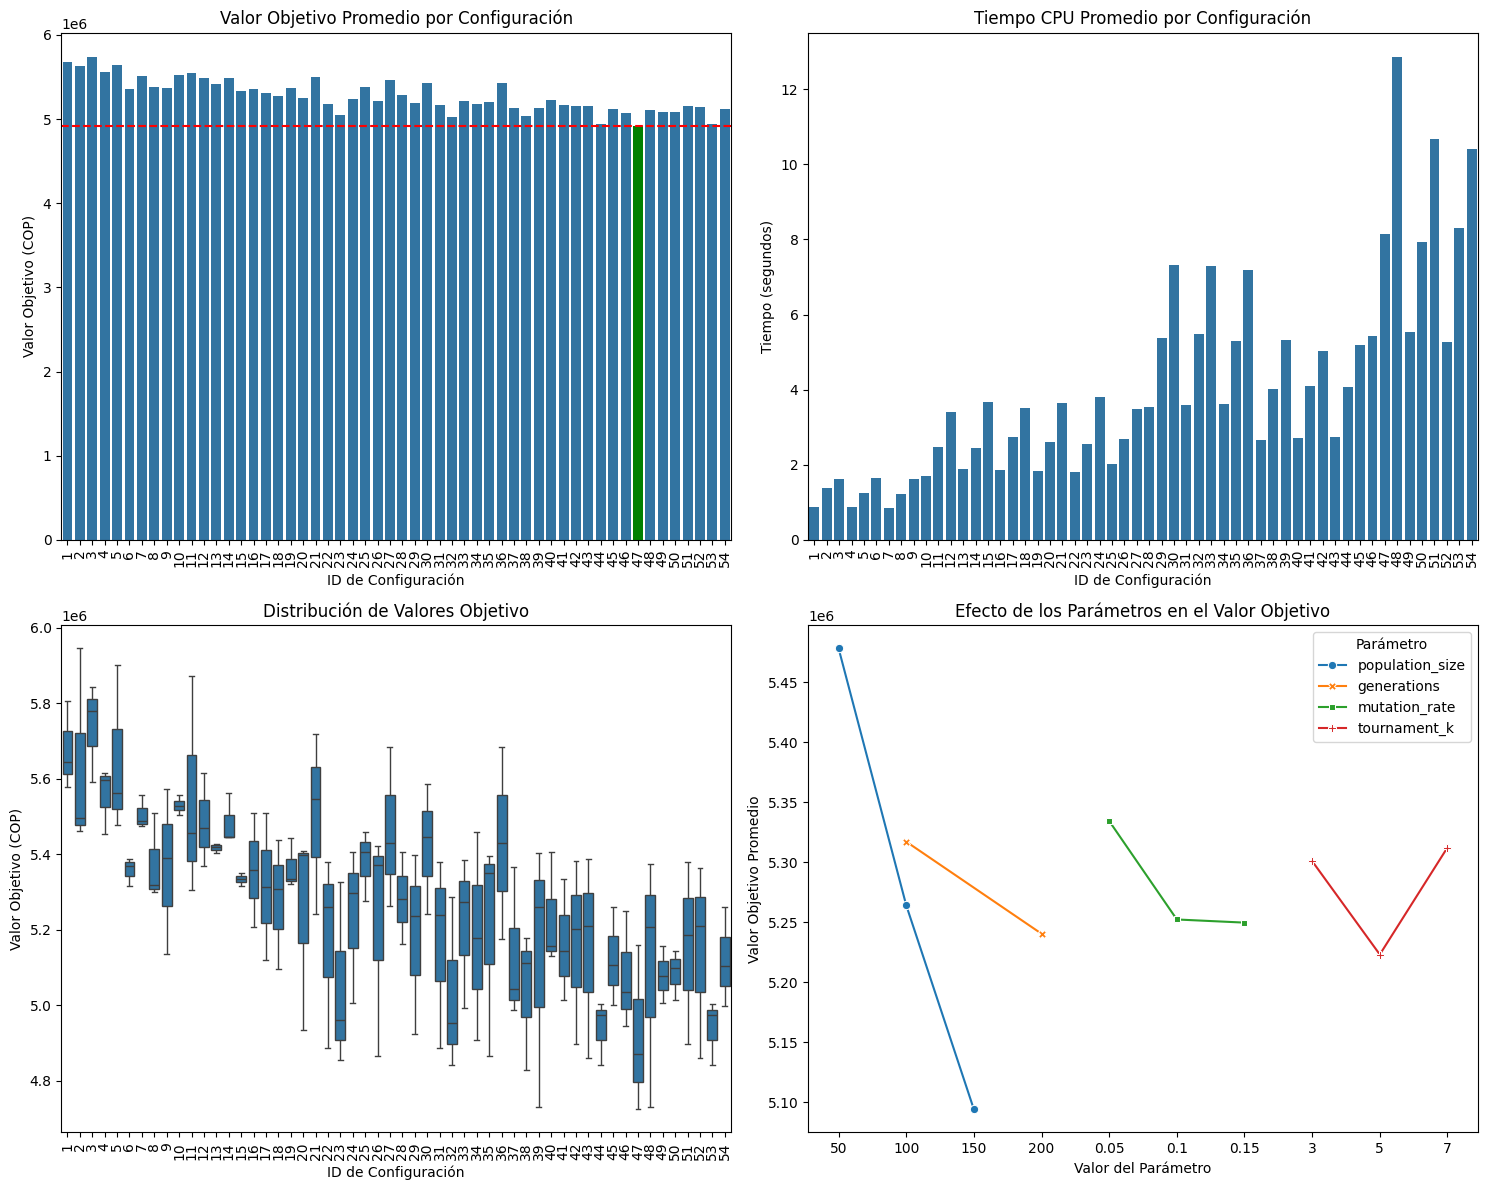

Visualizaciones guardadas en 'calibracion_graficos_Base.png'
Best parameters for case Base: {'population_size': np.float64(150.0), 'generations': np.float64(200.0), 'mutation_rate': np.float64(0.05), 'tournament_k': np.float64(5.0)}
Results saved for case Base.
Solución guardada en formato solicitado: best_solution_case_Base_formatted.csv

--- CALIBRATING FOR CASE: 2 ---
Loaded 9 clients for Case 2. First few: ['C1', 'C2', 'C3', 'C4', 'C5']
--- Calculating Distance Matrix using OSRM ---
  Distances loaded from GA cache (100 pairs): Etapa3/cache/osrm_cache_ga_2.json
  No missing distance pairs for Case 2
Distance and cost matrices populated for case 2. 100 entries.
--- DATA LOADING COMPLETE FOR CASE 2 ---

--- INICIANDO CALIBRACIÓN PARA CASO: 2 ---

Loaded 9 clients for Case 2. First few: ['C1', 'C2', 'C3', 'C4', 'C5']
--- Calculating Distance Matrix using OSRM ---
  Distances loaded from GA cache (100 pairs): Etapa3/cache/osrm_cache_ga_2.json
  No missing distance pairs for Case 2
Dist

Progreso de calibración:   0%|          | 0/54 [00:00<?, ?it/s]


Configuración #1/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4142160.62
Generation 2/100 | Best Fitness: 2589209.82 | Avg Fitness: 3595389.71
Generation 3/100 | Best Fitness: 2512445.94 | Avg Fitness: 3590113.36
Generation 4/100 | Best Fitness: 2512445.94 | Avg Fitness: 3453368.54
Generation 5/100 | Best Fitness: 2512445.94 | Avg Fitness: 3243035.09
Generation 6/100 | Best Fitness: 2496502.80 | Avg Fitness: 3204006.69
Generation 7/100 | Best Fitness: 2496502.80 | Avg Fitness: 3019431.58
Generation 8/100 | Best Fitness: 2312444.61 | Avg Fitness: 2845052.38
Generation 9/100 | Best Fitness: 2312444.61 | Avg Fitness: 2726567.20
Generation 10/100 | Best Fitness: 2312444.61 | Avg Fitness: 2587108.94
Generation 11/100 | Best Fitness: 2103560.91 | Avg Fitness: 2610194.24
Generation 12/100 | Best Fitness: 2079151.47 | Avg Fitness: 2603034.31
Generation 13/100 | B

Progreso de calibración:   2%|▏         | 1/54 [00:01<00:56,  1.06s/it]


Configuración #2/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4142160.62
Generation 2/100 | Best Fitness: 2589209.82 | Avg Fitness: 3662022.97
Generation 3/100 | Best Fitness: 2589209.82 | Avg Fitness: 3386866.73
Generation 4/100 | Best Fitness: 2446309.44 | Avg Fitness: 3055523.52
Generation 5/100 | Best Fitness: 2360319.57 | Avg Fitness: 2934774.34
Generation 6/100 | Best Fitness: 2308263.21 | Avg Fitness: 2816663.82
Generation 7/100 | Best Fitness: 2308263.21 | Avg Fitness: 2637800.79
Generation 8/100 | Best Fitness: 2308263.21 | Avg Fitness: 2571173.21
Generation 9/100 | Best Fitness: 2308263.21 | Avg Fitness: 2356727.66
Generation 10/100 | Best Fitness: 2308263.21 | Avg Fitness: 2345650.02
Generation 11/100 | Best Fitness: 2308263.21 | Avg Fitness: 2337157.43
Generation 12/100 | Best Fitness: 2308263.21 | Avg Fitness: 2322826.45
Generation 13/100 | B

Progreso de calibración:   4%|▎         | 2/54 [00:02<01:04,  1.23s/it]

Generation 76/100 | Best Fitness: 2079151.47 | Avg Fitness: 2116182.16
Generation 77/100 | Best Fitness: 2079151.47 | Avg Fitness: 2137073.26
Generation 78/100 | Best Fitness: 2079151.47 | Avg Fitness: 2097494.15
Generation 79/100 | Best Fitness: 2079151.47 | Avg Fitness: 2162330.94
Generation 80/100 | Best Fitness: 2079151.47 | Avg Fitness: 2108300.63
Generation 81/100 | Best Fitness: 2079151.47 | Avg Fitness: 2097430.52
Generation 82/100 | Best Fitness: 2079151.47 | Avg Fitness: 2107737.26
Generation 83/100 | Best Fitness: 2079151.47 | Avg Fitness: 2157180.66
Generation 84/100 | Best Fitness: 2079151.47 | Avg Fitness: 2098033.89
Generation 85/100 | Best Fitness: 2079151.47 | Avg Fitness: 2093237.74
Generation 86/100 | Best Fitness: 2079151.47 | Avg Fitness: 2130536.40
Generation 87/100 | Best Fitness: 2079151.47 | Avg Fitness: 2092209.90
Generation 88/100 | Best Fitness: 2079151.47 | Avg Fitness: 2176531.27
Generation 89/100 | Best Fitness: 2079151.47 | Avg Fitness: 2084585.59
Genera

Progreso de calibración:   6%|▌         | 3/54 [00:04<01:18,  1.55s/it]

Generation 93/100 | Best Fitness: 2258200.26 | Avg Fitness: 2261592.78
Generation 94/100 | Best Fitness: 2258200.26 | Avg Fitness: 2305715.58
Generation 95/100 | Best Fitness: 2258200.26 | Avg Fitness: 2303711.24
Generation 96/100 | Best Fitness: 2258200.26 | Avg Fitness: 2314026.13
Generation 97/100 | Best Fitness: 2258200.26 | Avg Fitness: 2342884.37
Generation 98/100 | Best Fitness: 2258200.26 | Avg Fitness: 2288529.28
Generation 99/100 | Best Fitness: 2258200.26 | Avg Fitness: 2295584.79
Generation 100/100 | Best Fitness: 2258200.26 | Avg Fitness: 2312854.01
--- Genetic Algorithm Finished ---

Configuración #4/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4142160.62
Generation 2/100 | Best Fitness: 2589209.82 | Avg Fitness: 3668127.48
Generation 3/100 | Best Fitness: 2537519.85 | Avg Fitness: 3625599.33
Generation 4/100 | Best Fitness: 2537519.85 | Avg F

Progreso de calibración:   7%|▋         | 4/54 [00:05<01:09,  1.38s/it]

Generation 72/100 | Best Fitness: 2079151.47 | Avg Fitness: 2197523.84
Generation 73/100 | Best Fitness: 2079151.47 | Avg Fitness: 2264710.45
Generation 74/100 | Best Fitness: 2079151.47 | Avg Fitness: 2112917.60
Generation 75/100 | Best Fitness: 2079151.47 | Avg Fitness: 2187389.20
Generation 76/100 | Best Fitness: 2079151.47 | Avg Fitness: 2144562.02
Generation 77/100 | Best Fitness: 2079151.47 | Avg Fitness: 2143061.93
Generation 78/100 | Best Fitness: 2079151.47 | Avg Fitness: 2123743.82
Generation 79/100 | Best Fitness: 2079151.47 | Avg Fitness: 2162072.15
Generation 80/100 | Best Fitness: 2079151.47 | Avg Fitness: 2184675.47
Generation 81/100 | Best Fitness: 2079151.47 | Avg Fitness: 2204716.39
Generation 82/100 | Best Fitness: 2079151.47 | Avg Fitness: 2191272.44
Generation 83/100 | Best Fitness: 2079151.47 | Avg Fitness: 2157297.78
Generation 84/100 | Best Fitness: 2079151.47 | Avg Fitness: 2161418.11
Generation 85/100 | Best Fitness: 2079151.47 | Avg Fitness: 2127397.54
Genera

Progreso de calibración:   9%|▉         | 5/54 [00:06<01:07,  1.37s/it]


Configuración #6/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4142160.62
Generation 2/100 | Best Fitness: 2589209.82 | Avg Fitness: 3713704.08
Generation 3/100 | Best Fitness: 2079151.47 | Avg Fitness: 3110205.18
Generation 4/100 | Best Fitness: 2079151.47 | Avg Fitness: 2773157.27
Generation 5/100 | Best Fitness: 2079151.47 | Avg Fitness: 2417526.30
Generation 6/100 | Best Fitness: 2079151.47 | Avg Fitness: 2125892.73
Generation 7/100 | Best Fitness: 2079151.47 | Avg Fitness: 2135640.74
Generation 8/100 | Best Fitness: 2079151.47 | Avg Fitness: 2182966.19
Generation 9/100 | Best Fitness: 2079151.47 | Avg Fitness: 2171243.91
Generation 10/100 | Best Fitness: 2079151.47 | Avg Fitness: 2131588.88
Generation 11/100 | Best Fitness: 2079151.47 | Avg Fitness: 2158870.69
Generation 12/100 | Best Fitness: 2079151.47 | Avg Fitness: 2135246.48
Generation 13/100 | Be

Progreso de calibración:  11%|█         | 6/54 [00:08<01:18,  1.64s/it]

Generation 93/100 | Best Fitness: 2079151.47 | Avg Fitness: 2111791.44
Generation 94/100 | Best Fitness: 2079151.47 | Avg Fitness: 2236319.08
Generation 95/100 | Best Fitness: 2079151.47 | Avg Fitness: 2155034.40
Generation 96/100 | Best Fitness: 2079151.47 | Avg Fitness: 2163108.85
Generation 97/100 | Best Fitness: 2079151.47 | Avg Fitness: 2117860.55
Generation 98/100 | Best Fitness: 2079151.47 | Avg Fitness: 2129051.59
Generation 99/100 | Best Fitness: 2079151.47 | Avg Fitness: 2144913.01
Generation 100/100 | Best Fitness: 2079151.47 | Avg Fitness: 2161577.05
--- Genetic Algorithm Finished ---

Configuración #7/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4142160.62
Generation 2/100 | Best Fitness: 2521338.66 | Avg Fitness: 3811015.85
Generation 3/100 | Best Fitness: 2500793.91 | Avg Fitness: 3763202.70
Generation 4/100 | Best Fitness: 2500793.91 | Avg 

Progreso de calibración:  13%|█▎        | 7/54 [00:10<01:13,  1.55s/it]

Generation 54/100 | Best Fitness: 2079151.47 | Avg Fitness: 2222737.39
Generation 55/100 | Best Fitness: 2079151.47 | Avg Fitness: 2161047.75
Generation 56/100 | Best Fitness: 2079151.47 | Avg Fitness: 2112738.54
Generation 57/100 | Best Fitness: 2079151.47 | Avg Fitness: 2160003.52
Generation 58/100 | Best Fitness: 2079151.47 | Avg Fitness: 2113952.81
Generation 59/100 | Best Fitness: 2079151.47 | Avg Fitness: 2110718.97
Generation 60/100 | Best Fitness: 2079151.47 | Avg Fitness: 2144217.95
Generation 61/100 | Best Fitness: 2079151.47 | Avg Fitness: 2130740.30
Generation 62/100 | Best Fitness: 2079151.47 | Avg Fitness: 2172915.02
Generation 63/100 | Best Fitness: 2079151.47 | Avg Fitness: 2209488.15
Generation 64/100 | Best Fitness: 2079151.47 | Avg Fitness: 2178650.41
Generation 65/100 | Best Fitness: 2079151.47 | Avg Fitness: 2252405.34
Generation 66/100 | Best Fitness: 2079151.47 | Avg Fitness: 2173061.74
Generation 67/100 | Best Fitness: 2079151.47 | Avg Fitness: 2187499.49
Genera

Progreso de calibración:  15%|█▍        | 8/54 [00:11<01:07,  1.48s/it]

Generation 99/100 | Best Fitness: 2079151.47 | Avg Fitness: 2134322.43
Generation 100/100 | Best Fitness: 2079151.47 | Avg Fitness: 2156104.59
--- Genetic Algorithm Finished ---

Configuración #9/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4142160.62
Generation 2/100 | Best Fitness: 2589209.82 | Avg Fitness: 3711306.15
Generation 3/100 | Best Fitness: 2079151.47 | Avg Fitness: 3368736.51
Generation 4/100 | Best Fitness: 2079151.47 | Avg Fitness: 3043025.86
Generation 5/100 | Best Fitness: 2079151.47 | Avg Fitness: 2631763.68
Generation 6/100 | Best Fitness: 2079151.47 | Avg Fitness: 2341048.53
Generation 7/100 | Best Fitness: 2079151.47 | Avg Fitness: 2354568.90
Generation 8/100 | Best Fitness: 2079151.47 | Avg Fitness: 2333752.78
Generation 9/100 | Best Fitness: 2079151.47 | Avg Fitness: 2201905.70
Generation 10/100 | Best Fitness: 2079151.47 | Avg Fitne

Progreso de calibración:  17%|█▋        | 9/54 [00:13<01:10,  1.56s/it]

Generation 83/100 | Best Fitness: 2079151.47 | Avg Fitness: 2178901.91
Generation 84/100 | Best Fitness: 2079151.47 | Avg Fitness: 2186707.47
Generation 85/100 | Best Fitness: 2079151.47 | Avg Fitness: 2166076.77
Generation 86/100 | Best Fitness: 2079151.47 | Avg Fitness: 2261840.56
Generation 87/100 | Best Fitness: 2079151.47 | Avg Fitness: 2225574.99
Generation 88/100 | Best Fitness: 2079151.47 | Avg Fitness: 2195756.27
Generation 89/100 | Best Fitness: 2079151.47 | Avg Fitness: 2106096.49
Generation 90/100 | Best Fitness: 2079151.47 | Avg Fitness: 2188454.05
Generation 91/100 | Best Fitness: 2079151.47 | Avg Fitness: 2157096.00
Generation 92/100 | Best Fitness: 2079151.47 | Avg Fitness: 2223235.06
Generation 93/100 | Best Fitness: 2079151.47 | Avg Fitness: 2203317.77
Generation 94/100 | Best Fitness: 2079151.47 | Avg Fitness: 2176315.08
Generation 95/100 | Best Fitness: 2079151.47 | Avg Fitness: 2135639.00
Generation 96/100 | Best Fitness: 2079151.47 | Avg Fitness: 2099337.24
Genera

Progreso de calibración:  19%|█▊        | 10/54 [00:15<01:12,  1.64s/it]

Generation 169/200 | Best Fitness: 2079151.47 | Avg Fitness: 2130788.94
Generation 170/200 | Best Fitness: 2079151.47 | Avg Fitness: 2085774.68
Generation 171/200 | Best Fitness: 2079151.47 | Avg Fitness: 2121398.14
Generation 172/200 | Best Fitness: 2079151.47 | Avg Fitness: 2116365.27
Generation 173/200 | Best Fitness: 2079151.47 | Avg Fitness: 2104553.23
Generation 174/200 | Best Fitness: 2079151.47 | Avg Fitness: 2099278.12
Generation 175/200 | Best Fitness: 2079151.47 | Avg Fitness: 2159925.77
Generation 176/200 | Best Fitness: 2079151.47 | Avg Fitness: 2158467.45
Generation 177/200 | Best Fitness: 2079151.47 | Avg Fitness: 2119355.34
Generation 178/200 | Best Fitness: 2079151.47 | Avg Fitness: 2115382.64
Generation 179/200 | Best Fitness: 2079151.47 | Avg Fitness: 2106168.08
Generation 180/200 | Best Fitness: 2079151.47 | Avg Fitness: 2084286.64
Generation 181/200 | Best Fitness: 2079151.47 | Avg Fitness: 2107242.32
Generation 182/200 | Best Fitness: 2079151.47 | Avg Fitness: 216

Progreso de calibración:  20%|██        | 11/54 [00:18<01:29,  2.08s/it]

Generation 195/200 | Best Fitness: 2079151.47 | Avg Fitness: 2147414.03
Generation 196/200 | Best Fitness: 2079151.47 | Avg Fitness: 2079151.47
Generation 197/200 | Best Fitness: 2079151.47 | Avg Fitness: 2129437.86
Generation 198/200 | Best Fitness: 2079151.47 | Avg Fitness: 2100171.04
Generation 199/200 | Best Fitness: 2079151.47 | Avg Fitness: 2109742.05
Generation 200/200 | Best Fitness: 2079151.47 | Avg Fitness: 2153257.18
--- Genetic Algorithm Finished ---

Configuración #12/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4142160.62
Generation 2/200 | Best Fitness: 2589209.82 | Avg Fitness: 3716266.49
Generation 3/200 | Best Fitness: 2079151.47 | Avg Fitness: 3224293.19
Generation 4/200 | Best Fitness: 2079151.47 | Avg Fitness: 2722334.09
Generation 5/200 | Best Fitness: 2079151.47 | Avg Fitness: 2550238.96
Generation 6/200 | Best Fitness: 2079151.47 | 

Progreso de calibración:  22%|██▏       | 12/54 [00:22<01:50,  2.63s/it]

Generation 192/200 | Best Fitness: 2258200.26 | Avg Fitness: 2274737.99
Generation 193/200 | Best Fitness: 2258200.26 | Avg Fitness: 2301061.35
Generation 194/200 | Best Fitness: 2258200.26 | Avg Fitness: 2291649.06
Generation 195/200 | Best Fitness: 2258200.26 | Avg Fitness: 2264454.35
Generation 196/200 | Best Fitness: 2258200.26 | Avg Fitness: 2275849.29
Generation 197/200 | Best Fitness: 2258200.26 | Avg Fitness: 2287733.53
Generation 198/200 | Best Fitness: 2258200.26 | Avg Fitness: 2278895.83
Generation 199/200 | Best Fitness: 2258200.26 | Avg Fitness: 2301656.39
Generation 200/200 | Best Fitness: 2258200.26 | Avg Fitness: 2312002.71
--- Genetic Algorithm Finished ---

Configuración #13/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4142160.62
Generation 2/200 | Best Fitness: 2589209.82 | Avg Fitness: 3668127.48
Generation 3/200 | Best Fitness: 2537519.

Progreso de calibración:  24%|██▍       | 13/54 [00:24<01:39,  2.42s/it]

Generation 193/200 | Best Fitness: 2079151.47 | Avg Fitness: 2201642.15
Generation 194/200 | Best Fitness: 2079151.47 | Avg Fitness: 2166930.19
Generation 195/200 | Best Fitness: 2079151.47 | Avg Fitness: 2151739.87
Generation 196/200 | Best Fitness: 2079151.47 | Avg Fitness: 2103932.02
Generation 197/200 | Best Fitness: 2079151.47 | Avg Fitness: 2148297.34
Generation 198/200 | Best Fitness: 2079151.47 | Avg Fitness: 2172323.41
Generation 199/200 | Best Fitness: 2079151.47 | Avg Fitness: 2088974.16
Generation 200/200 | Best Fitness: 2079151.47 | Avg Fitness: 2124937.72
--- Genetic Algorithm Finished ---

Configuración #14/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4142160.62
Generation 2/200 | Best Fitness: 2589209.82 | Avg Fitness: 3649689.04
Generation 3/200 | Best Fitness: 2371696.29 | Avg Fitness: 3418487.05
Generation 4/200 | Best Fitness: 2278128.15

Progreso de calibración:  26%|██▌       | 14/54 [00:27<01:43,  2.59s/it]

Generation 199/200 | Best Fitness: 2079151.47 | Avg Fitness: 2117048.95
Generation 200/200 | Best Fitness: 2079151.47 | Avg Fitness: 2130970.57
--- Genetic Algorithm Finished ---

Configuración #15/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4142160.62
Generation 2/200 | Best Fitness: 2589209.82 | Avg Fitness: 3713704.08
Generation 3/200 | Best Fitness: 2079151.47 | Avg Fitness: 3110205.18
Generation 4/200 | Best Fitness: 2079151.47 | Avg Fitness: 2773157.27
Generation 5/200 | Best Fitness: 2079151.47 | Avg Fitness: 2417526.30
Generation 6/200 | Best Fitness: 2079151.47 | Avg Fitness: 2125892.73
Generation 7/200 | Best Fitness: 2079151.47 | Avg Fitness: 2135640.74
Generation 8/200 | Best Fitness: 2079151.47 | Avg Fitness: 2182966.19
Generation 9/200 | Best Fitness: 2079151.47 | Avg Fitness: 2171243.91
Generation 10/200 | Best Fitness: 2079151.47 | Avg Fitn

Progreso de calibración:  28%|██▊       | 15/54 [00:31<01:59,  3.07s/it]

Generation 196/200 | Best Fitness: 2079151.47 | Avg Fitness: 2109481.86
Generation 197/200 | Best Fitness: 2079151.47 | Avg Fitness: 2140027.27
Generation 198/200 | Best Fitness: 2079151.47 | Avg Fitness: 2149444.24
Generation 199/200 | Best Fitness: 2079151.47 | Avg Fitness: 2133282.88
Generation 200/200 | Best Fitness: 2079151.47 | Avg Fitness: 2156415.26
--- Genetic Algorithm Finished ---

Configuración #16/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4142160.62
Generation 2/200 | Best Fitness: 2521338.66 | Avg Fitness: 3811015.85
Generation 3/200 | Best Fitness: 2500793.91 | Avg Fitness: 3763202.70
Generation 4/200 | Best Fitness: 2500793.91 | Avg Fitness: 3468062.68
Generation 5/200 | Best Fitness: 2349027.72 | Avg Fitness: 3450403.39
Generation 6/200 | Best Fitness: 2349027.72 | Avg Fitness: 3135271.10
Generation 7/200 | Best Fitness: 2349027.72 | Av

Progreso de calibración:  30%|██▉       | 16/54 [00:33<01:42,  2.71s/it]

Generation 172/200 | Best Fitness: 2079151.47 | Avg Fitness: 2176302.45
Generation 173/200 | Best Fitness: 2079151.47 | Avg Fitness: 2177766.85
Generation 174/200 | Best Fitness: 2079151.47 | Avg Fitness: 2200769.77
Generation 175/200 | Best Fitness: 2079151.47 | Avg Fitness: 2154469.62
Generation 176/200 | Best Fitness: 2079151.47 | Avg Fitness: 2216304.62
Generation 177/200 | Best Fitness: 2079151.47 | Avg Fitness: 2325486.23
Generation 178/200 | Best Fitness: 2079151.47 | Avg Fitness: 2219201.09
Generation 179/200 | Best Fitness: 2079151.47 | Avg Fitness: 2169709.08
Generation 180/200 | Best Fitness: 2079151.47 | Avg Fitness: 2255924.21
Generation 181/200 | Best Fitness: 2079151.47 | Avg Fitness: 2223012.54
Generation 182/200 | Best Fitness: 2079151.47 | Avg Fitness: 2331837.20
Generation 183/200 | Best Fitness: 2079151.47 | Avg Fitness: 2155779.35
Generation 184/200 | Best Fitness: 2079151.47 | Avg Fitness: 2146125.57
Generation 185/200 | Best Fitness: 2079151.47 | Avg Fitness: 218

Progreso de calibración:  31%|███▏      | 17/54 [00:35<01:41,  2.73s/it]


Configuración #18/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4142160.62
Generation 2/200 | Best Fitness: 2589209.82 | Avg Fitness: 3711306.15
Generation 3/200 | Best Fitness: 2079151.47 | Avg Fitness: 3368736.51
Generation 4/200 | Best Fitness: 2079151.47 | Avg Fitness: 3043025.86
Generation 5/200 | Best Fitness: 2079151.47 | Avg Fitness: 2631763.68
Generation 6/200 | Best Fitness: 2079151.47 | Avg Fitness: 2341048.53
Generation 7/200 | Best Fitness: 2079151.47 | Avg Fitness: 2354568.90
Generation 8/200 | Best Fitness: 2079151.47 | Avg Fitness: 2333752.78
Generation 9/200 | Best Fitness: 2079151.47 | Avg Fitness: 2201905.70
Generation 10/200 | Best Fitness: 2079151.47 | Avg Fitness: 2185587.43
Generation 11/200 | Best Fitness: 2079151.47 | Avg Fitness: 2169343.65
Generation 12/200 | Best Fitness: 2079151.47 | Avg Fitness: 2209239.67
Generation 13/200 | 

Progreso de calibración:  33%|███▎      | 18/54 [00:40<01:53,  3.14s/it]


Configuración #19/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4136748.11
Generation 2/100 | Best Fitness: 2529633.15 | Avg Fitness: 3869585.47
Generation 3/100 | Best Fitness: 2415514.05 | Avg Fitness: 3568581.65
Generation 4/100 | Best Fitness: 2308263.21 | Avg Fitness: 3341482.91
Generation 5/100 | Best Fitness: 2308263.21 | Avg Fitness: 3122295.12
Generation 6/100 | Best Fitness: 2308263.21 | Avg Fitness: 3093941.79
Generation 7/100 | Best Fitness: 2308263.21 | Avg Fitness: 2813702.67
Generation 8/100 | Best Fitness: 2308263.21 | Avg Fitness: 2766767.69
Generation 9/100 | Best Fitness: 2308263.21 | Avg Fitness: 2560110.26
Generation 10/100 | Best Fitness: 2308263.21 | Avg Fitness: 2438978.70
Generation 11/100 | Best Fitness: 2308263.21 | Avg Fitness: 2393081.13
Generation 12/100 | Best Fitness: 2308263.21 | Avg Fitness: 2378554.59
Generation 13/100 |

Progreso de calibración:  35%|███▌      | 19/54 [00:42<01:39,  2.84s/it]

Generation 97/100 | Best Fitness: 2124124.29 | Avg Fitness: 2260330.02
Generation 98/100 | Best Fitness: 2124124.29 | Avg Fitness: 2265948.08
Generation 99/100 | Best Fitness: 2124124.29 | Avg Fitness: 2302768.75
Generation 100/100 | Best Fitness: 2124124.29 | Avg Fitness: 2284650.74
--- Genetic Algorithm Finished ---

Configuración #20/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4136748.11
Generation 2/100 | Best Fitness: 2589209.82 | Avg Fitness: 3772289.77
Generation 3/100 | Best Fitness: 2250628.20 | Avg Fitness: 3358785.52
Generation 4/100 | Best Fitness: 2250628.20 | Avg Fitness: 3140378.62
Generation 5/100 | Best Fitness: 2250628.20 | Avg Fitness: 2788288.47
Generation 6/100 | Best Fitness: 2250628.20 | Avg Fitness: 2545816.93
Generation 7/100 | Best Fitness: 2250628.20 | Avg Fitness: 2395203.77
Generation 8/100 | Best Fitness: 2250628.20 | Avg Fi

Progreso de calibración:  37%|███▋      | 20/54 [00:44<01:34,  2.78s/it]

Generation 97/100 | Best Fitness: 2124124.29 | Avg Fitness: 2273278.51
Generation 98/100 | Best Fitness: 2124124.29 | Avg Fitness: 2273043.92
Generation 99/100 | Best Fitness: 2124124.29 | Avg Fitness: 2311640.48
Generation 100/100 | Best Fitness: 2124124.29 | Avg Fitness: 2305707.48
--- Genetic Algorithm Finished ---

Configuración #21/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4136748.11
Generation 2/100 | Best Fitness: 2521338.66 | Avg Fitness: 3713720.62
Generation 3/100 | Best Fitness: 2165335.92 | Avg Fitness: 3297508.55
Generation 4/100 | Best Fitness: 2165335.92 | Avg Fitness: 2875756.36
Generation 5/100 | Best Fitness: 2079151.47 | Avg Fitness: 2473203.92
Generation 6/100 | Best Fitness: 2079151.47 | Avg Fitness: 2234129.47
Generation 7/100 | Best Fitness: 2079151.47 | Avg Fitness: 2113579.21
Generation 8/100 | Best Fitness: 2079151.47 | Avg Fi

Progreso de calibración:  39%|███▉      | 21/54 [00:49<01:45,  3.21s/it]

Generation 95/100 | Best Fitness: 2258200.26 | Avg Fitness: 2287830.65
Generation 96/100 | Best Fitness: 2258200.26 | Avg Fitness: 2315601.28
Generation 97/100 | Best Fitness: 2258200.26 | Avg Fitness: 2267084.60
Generation 98/100 | Best Fitness: 2258200.26 | Avg Fitness: 2330930.21
Generation 99/100 | Best Fitness: 2258200.26 | Avg Fitness: 2282008.24
Generation 100/100 | Best Fitness: 2258200.26 | Avg Fitness: 2300537.10
--- Genetic Algorithm Finished ---

Configuración #22/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4136748.11
Generation 2/100 | Best Fitness: 2589209.82 | Avg Fitness: 3810197.31
Generation 3/100 | Best Fitness: 2396105.73 | Avg Fitness: 3577354.79
Generation 4/100 | Best Fitness: 2396105.73 | Avg Fitness: 3227003.73
Generation 5/100 | Best Fitness: 2396105.73 | Avg Fitness: 3098635.91
Generation 6/100 | Best Fitness: 2396105.73 | Avg F

Progreso de calibración:  41%|████      | 22/54 [00:50<01:30,  2.82s/it]

Generation 81/100 | Best Fitness: 2124124.29 | Avg Fitness: 2286236.73
Generation 82/100 | Best Fitness: 2124124.29 | Avg Fitness: 2353363.54
Generation 83/100 | Best Fitness: 2124124.29 | Avg Fitness: 2279161.45
Generation 84/100 | Best Fitness: 2124124.29 | Avg Fitness: 2281034.97
Generation 85/100 | Best Fitness: 2124124.29 | Avg Fitness: 2306592.04
Generation 86/100 | Best Fitness: 2124124.29 | Avg Fitness: 2340915.64
Generation 87/100 | Best Fitness: 2124124.29 | Avg Fitness: 2344557.12
Generation 88/100 | Best Fitness: 2124124.29 | Avg Fitness: 2402803.65
Generation 89/100 | Best Fitness: 2124124.29 | Avg Fitness: 2315751.15
Generation 90/100 | Best Fitness: 2124124.29 | Avg Fitness: 2337760.30
Generation 91/100 | Best Fitness: 2124124.29 | Avg Fitness: 2328149.56
Generation 92/100 | Best Fitness: 2124124.29 | Avg Fitness: 2317377.59
Generation 93/100 | Best Fitness: 2124124.29 | Avg Fitness: 2332292.87
Generation 94/100 | Best Fitness: 2124124.29 | Avg Fitness: 2279980.20
Genera

Progreso de calibración:  43%|████▎     | 23/54 [00:54<01:35,  3.07s/it]

Generation 94/100 | Best Fitness: 2079151.47 | Avg Fitness: 2161830.50
Generation 95/100 | Best Fitness: 2079151.47 | Avg Fitness: 2184190.74
Generation 96/100 | Best Fitness: 2079151.47 | Avg Fitness: 2166122.48
Generation 97/100 | Best Fitness: 2079151.47 | Avg Fitness: 2129341.89
Generation 98/100 | Best Fitness: 2079151.47 | Avg Fitness: 2108434.39
Generation 99/100 | Best Fitness: 2079151.47 | Avg Fitness: 2170961.72
Generation 100/100 | Best Fitness: 2079151.47 | Avg Fitness: 2142645.95
--- Genetic Algorithm Finished ---

Configuración #24/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4136748.11
Generation 2/100 | Best Fitness: 2521338.66 | Avg Fitness: 3655220.78
Generation 3/100 | Best Fitness: 2103560.91 | Avg Fitness: 3268307.74
Generation 4/100 | Best Fitness: 2079151.47 | Avg Fitness: 2945162.76
Generation 5/100 | Best Fitness: 2079151.47 | Avg 

Progreso de calibración:  44%|████▍     | 24/54 [00:58<01:35,  3.20s/it]

Generation 94/100 | Best Fitness: 2079151.47 | Avg Fitness: 2090054.99
Generation 95/100 | Best Fitness: 2079151.47 | Avg Fitness: 2180328.66
Generation 96/100 | Best Fitness: 2079151.47 | Avg Fitness: 2117953.99
Generation 97/100 | Best Fitness: 2079151.47 | Avg Fitness: 2189914.02
Generation 98/100 | Best Fitness: 2079151.47 | Avg Fitness: 2139209.73
Generation 99/100 | Best Fitness: 2079151.47 | Avg Fitness: 2195428.77
Generation 100/100 | Best Fitness: 2079151.47 | Avg Fitness: 2135334.77
--- Genetic Algorithm Finished ---

Configuración #25/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4136748.11
Generation 2/100 | Best Fitness: 2589209.82 | Avg Fitness: 3862507.41
Generation 3/100 | Best Fitness: 2275037.64 | Avg Fitness: 3689961.69
Generation 4/100 | Best Fitness: 2275037.64 | Avg Fitness: 3584836.99
Generation 5/100 | Best Fitness: 2275037.64 | Avg

Progreso de calibración:  46%|████▋     | 25/54 [01:00<01:25,  2.96s/it]

Generation 97/100 | Best Fitness: 2250628.20 | Avg Fitness: 2310971.04
Generation 98/100 | Best Fitness: 2250628.20 | Avg Fitness: 2333313.81
Generation 99/100 | Best Fitness: 2250628.20 | Avg Fitness: 2448788.29
Generation 100/100 | Best Fitness: 2250628.20 | Avg Fitness: 2399752.78
--- Genetic Algorithm Finished ---

Configuración #26/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4136748.11
Generation 2/100 | Best Fitness: 2589209.82 | Avg Fitness: 3755274.98
Generation 3/100 | Best Fitness: 2482793.19 | Avg Fitness: 3458567.86
Generation 4/100 | Best Fitness: 2275037.64 | Avg Fitness: 3143737.01
Generation 5/100 | Best Fitness: 2275037.64 | Avg Fitness: 3059014.10
Generation 6/100 | Best Fitness: 2250628.20 | Avg Fitness: 2696162.68
Generation 7/100 | Best Fitness: 2250628.20 | Avg Fitness: 2573907.16
Generation 8/100 | Best Fitness: 2250628.20 | Avg Fi

Progreso de calibración:  48%|████▊     | 26/54 [01:03<01:24,  3.03s/it]

Generation 89/100 | Best Fitness: 2079151.47 | Avg Fitness: 2217760.37
Generation 90/100 | Best Fitness: 2079151.47 | Avg Fitness: 2184634.82
Generation 91/100 | Best Fitness: 2079151.47 | Avg Fitness: 2174847.59
Generation 92/100 | Best Fitness: 2079151.47 | Avg Fitness: 2211186.81
Generation 93/100 | Best Fitness: 2079151.47 | Avg Fitness: 2229030.92
Generation 94/100 | Best Fitness: 2079151.47 | Avg Fitness: 2171439.56
Generation 95/100 | Best Fitness: 2079151.47 | Avg Fitness: 2186482.21
Generation 96/100 | Best Fitness: 2079151.47 | Avg Fitness: 2216966.13
Generation 97/100 | Best Fitness: 2079151.47 | Avg Fitness: 2230946.54
Generation 98/100 | Best Fitness: 2079151.47 | Avg Fitness: 2244153.63
Generation 99/100 | Best Fitness: 2079151.47 | Avg Fitness: 2133843.73
Generation 100/100 | Best Fitness: 2079151.47 | Avg Fitness: 2197548.68
--- Genetic Algorithm Finished ---

Configuración #27/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  

Progreso de calibración:  50%|█████     | 27/54 [01:07<01:26,  3.19s/it]

Generation 98/100 | Best Fitness: 2250628.20 | Avg Fitness: 2349166.02
Generation 99/100 | Best Fitness: 2250628.20 | Avg Fitness: 2329301.32
Generation 100/100 | Best Fitness: 2250628.20 | Avg Fitness: 2317212.07
--- Genetic Algorithm Finished ---

Configuración #28/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4136748.11
Generation 2/200 | Best Fitness: 2529633.15 | Avg Fitness: 3869585.47
Generation 3/200 | Best Fitness: 2415514.05 | Avg Fitness: 3568581.65
Generation 4/200 | Best Fitness: 2308263.21 | Avg Fitness: 3341482.91
Generation 5/200 | Best Fitness: 2308263.21 | Avg Fitness: 3122295.12
Generation 6/200 | Best Fitness: 2308263.21 | Avg Fitness: 3093941.79
Generation 7/200 | Best Fitness: 2308263.21 | Avg Fitness: 2813702.67
Generation 8/200 | Best Fitness: 2308263.21 | Avg Fitness: 2766767.69
Generation 9/200 | Best Fitness: 2308263.21 | Avg Fit

Progreso de calibración:  52%|█████▏    | 28/54 [01:11<01:31,  3.52s/it]

Generation 194/200 | Best Fitness: 2124124.29 | Avg Fitness: 2285341.87
Generation 195/200 | Best Fitness: 2124124.29 | Avg Fitness: 2304657.10
Generation 196/200 | Best Fitness: 2124124.29 | Avg Fitness: 2296305.77
Generation 197/200 | Best Fitness: 2124124.29 | Avg Fitness: 2337882.49
Generation 198/200 | Best Fitness: 2124124.29 | Avg Fitness: 2309807.91
Generation 199/200 | Best Fitness: 2124124.29 | Avg Fitness: 2289536.50
Generation 200/200 | Best Fitness: 2124124.29 | Avg Fitness: 2270697.35
--- Genetic Algorithm Finished ---

Configuración #29/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4136748.11
Generation 2/200 | Best Fitness: 2589209.82 | Avg Fitness: 3772289.77
Generation 3/200 | Best Fitness: 2250628.20 | Avg Fitness: 3358785.52
Generation 4/200 | Best Fitness: 2250628.20 | Avg Fitness: 3140378.62
Generation 5/200 | Best Fitness: 2250628.20

Progreso de calibración:  54%|█████▎    | 29/54 [01:16<01:40,  4.03s/it]

Generation 188/200 | Best Fitness: 2124124.29 | Avg Fitness: 2283734.62
Generation 189/200 | Best Fitness: 2124124.29 | Avg Fitness: 2281183.28
Generation 190/200 | Best Fitness: 2124124.29 | Avg Fitness: 2274512.29
Generation 191/200 | Best Fitness: 2124124.29 | Avg Fitness: 2279273.27
Generation 192/200 | Best Fitness: 2124124.29 | Avg Fitness: 2284016.68
Generation 193/200 | Best Fitness: 2124124.29 | Avg Fitness: 2265168.19
Generation 194/200 | Best Fitness: 2124124.29 | Avg Fitness: 2287564.68
Generation 195/200 | Best Fitness: 2124124.29 | Avg Fitness: 2291272.24
Generation 196/200 | Best Fitness: 2124124.29 | Avg Fitness: 2341045.74
Generation 197/200 | Best Fitness: 2124124.29 | Avg Fitness: 2287910.89
Generation 198/200 | Best Fitness: 2124124.29 | Avg Fitness: 2292556.07
Generation 199/200 | Best Fitness: 2124124.29 | Avg Fitness: 2324456.61
Generation 200/200 | Best Fitness: 2124124.29 | Avg Fitness: 2284314.90
--- Genetic Algorithm Finished ---

Configuración #30/54: {'popu

Progreso de calibración:  56%|█████▌    | 30/54 [01:24<02:03,  5.16s/it]

Generation 192/200 | Best Fitness: 2258200.26 | Avg Fitness: 2276800.87
Generation 193/200 | Best Fitness: 2258200.26 | Avg Fitness: 2326374.63
Generation 194/200 | Best Fitness: 2258200.26 | Avg Fitness: 2289258.73
Generation 195/200 | Best Fitness: 2258200.26 | Avg Fitness: 2342331.44
Generation 196/200 | Best Fitness: 2258200.26 | Avg Fitness: 2268369.57
Generation 197/200 | Best Fitness: 2258200.26 | Avg Fitness: 2277126.52
Generation 198/200 | Best Fitness: 2258200.26 | Avg Fitness: 2266973.00
Generation 199/200 | Best Fitness: 2258200.26 | Avg Fitness: 2313697.71
Generation 200/200 | Best Fitness: 2258200.26 | Avg Fitness: 2285363.15
--- Genetic Algorithm Finished ---

Configuración #31/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4136748.11
Generation 2/200 | Best Fitness: 2589209.82 | Avg Fitness: 3810197.31
Generation 3/200 | Best Fitness: 2396105

Progreso de calibración:  57%|█████▋    | 31/54 [01:28<01:52,  4.87s/it]

Generation 164/200 | Best Fitness: 2124124.29 | Avg Fitness: 2382023.91
Generation 165/200 | Best Fitness: 2124124.29 | Avg Fitness: 2331241.99
Generation 166/200 | Best Fitness: 2124124.29 | Avg Fitness: 2341305.23
Generation 167/200 | Best Fitness: 2124124.29 | Avg Fitness: 2339809.16
Generation 168/200 | Best Fitness: 2124124.29 | Avg Fitness: 2300962.61
Generation 169/200 | Best Fitness: 2124124.29 | Avg Fitness: 2396824.81
Generation 170/200 | Best Fitness: 2124124.29 | Avg Fitness: 2277144.36
Generation 171/200 | Best Fitness: 2124124.29 | Avg Fitness: 2330954.88
Generation 172/200 | Best Fitness: 2124124.29 | Avg Fitness: 2315736.92
Generation 173/200 | Best Fitness: 2124124.29 | Avg Fitness: 2318870.59
Generation 174/200 | Best Fitness: 2124124.29 | Avg Fitness: 2363052.47
Generation 175/200 | Best Fitness: 2124124.29 | Avg Fitness: 2318229.06
Generation 176/200 | Best Fitness: 2124124.29 | Avg Fitness: 2304625.62
Generation 177/200 | Best Fitness: 2124124.29 | Avg Fitness: 231

Progreso de calibración:  59%|█████▉    | 32/54 [01:34<01:49,  4.99s/it]

Generation 183/200 | Best Fitness: 2079151.47 | Avg Fitness: 2196809.13
Generation 184/200 | Best Fitness: 2079151.47 | Avg Fitness: 2187298.60
Generation 185/200 | Best Fitness: 2079151.47 | Avg Fitness: 2147311.11
Generation 186/200 | Best Fitness: 2079151.47 | Avg Fitness: 2173692.24
Generation 187/200 | Best Fitness: 2079151.47 | Avg Fitness: 2128862.09
Generation 188/200 | Best Fitness: 2079151.47 | Avg Fitness: 2161996.95
Generation 189/200 | Best Fitness: 2079151.47 | Avg Fitness: 2147912.15
Generation 190/200 | Best Fitness: 2079151.47 | Avg Fitness: 2121821.70
Generation 191/200 | Best Fitness: 2079151.47 | Avg Fitness: 2120672.85
Generation 192/200 | Best Fitness: 2079151.47 | Avg Fitness: 2171814.05
Generation 193/200 | Best Fitness: 2079151.47 | Avg Fitness: 2182533.58
Generation 194/200 | Best Fitness: 2079151.47 | Avg Fitness: 2140932.07
Generation 195/200 | Best Fitness: 2079151.47 | Avg Fitness: 2168823.99
Generation 196/200 | Best Fitness: 2079151.47 | Avg Fitness: 217

Progreso de calibración:  61%|██████    | 33/54 [01:42<02:04,  5.91s/it]

Generation 194/200 | Best Fitness: 2079151.47 | Avg Fitness: 2111967.80
Generation 195/200 | Best Fitness: 2079151.47 | Avg Fitness: 2178929.32
Generation 196/200 | Best Fitness: 2079151.47 | Avg Fitness: 2181139.73
Generation 197/200 | Best Fitness: 2079151.47 | Avg Fitness: 2128212.31
Generation 198/200 | Best Fitness: 2079151.47 | Avg Fitness: 2183764.67
Generation 199/200 | Best Fitness: 2079151.47 | Avg Fitness: 2106661.60
Generation 200/200 | Best Fitness: 2079151.47 | Avg Fitness: 2124752.47
--- Genetic Algorithm Finished ---

Configuración #34/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4136748.11
Generation 2/200 | Best Fitness: 2589209.82 | Avg Fitness: 3862507.41
Generation 3/200 | Best Fitness: 2275037.64 | Avg Fitness: 3689961.69
Generation 4/200 | Best Fitness: 2275037.64 | Avg Fitness: 3584836.99
Generation 5/200 | Best Fitness: 2275037.64

Progreso de calibración:  63%|██████▎   | 34/54 [01:46<01:46,  5.34s/it]

Generation 183/200 | Best Fitness: 2250628.20 | Avg Fitness: 2396165.84
Generation 184/200 | Best Fitness: 2250628.20 | Avg Fitness: 2402418.46
Generation 185/200 | Best Fitness: 2250628.20 | Avg Fitness: 2342564.79
Generation 186/200 | Best Fitness: 2250628.20 | Avg Fitness: 2359864.89
Generation 187/200 | Best Fitness: 2250628.20 | Avg Fitness: 2361768.51
Generation 188/200 | Best Fitness: 2250628.20 | Avg Fitness: 2353754.38
Generation 189/200 | Best Fitness: 2250628.20 | Avg Fitness: 2359781.66
Generation 190/200 | Best Fitness: 2250628.20 | Avg Fitness: 2314911.51
Generation 191/200 | Best Fitness: 2250628.20 | Avg Fitness: 2368601.99
Generation 192/200 | Best Fitness: 2250628.20 | Avg Fitness: 2320240.35
Generation 193/200 | Best Fitness: 2250628.20 | Avg Fitness: 2339913.57
Generation 194/200 | Best Fitness: 2250628.20 | Avg Fitness: 2293663.69
Generation 195/200 | Best Fitness: 2250628.20 | Avg Fitness: 2353342.12
Generation 196/200 | Best Fitness: 2250628.20 | Avg Fitness: 235

Progreso de calibración:  65%|██████▍   | 35/54 [01:52<01:46,  5.61s/it]

Generation 175/200 | Best Fitness: 2079151.47 | Avg Fitness: 2175850.30
Generation 176/200 | Best Fitness: 2079151.47 | Avg Fitness: 2169108.18
Generation 177/200 | Best Fitness: 2079151.47 | Avg Fitness: 2194876.08
Generation 178/200 | Best Fitness: 2079151.47 | Avg Fitness: 2189828.99
Generation 179/200 | Best Fitness: 2079151.47 | Avg Fitness: 2196815.65
Generation 180/200 | Best Fitness: 2079151.47 | Avg Fitness: 2151808.51
Generation 181/200 | Best Fitness: 2079151.47 | Avg Fitness: 2257606.07
Generation 182/200 | Best Fitness: 2079151.47 | Avg Fitness: 2193037.94
Generation 183/200 | Best Fitness: 2079151.47 | Avg Fitness: 2240188.16
Generation 184/200 | Best Fitness: 2079151.47 | Avg Fitness: 2158587.99
Generation 185/200 | Best Fitness: 2079151.47 | Avg Fitness: 2158027.62
Generation 186/200 | Best Fitness: 2079151.47 | Avg Fitness: 2172373.94
Generation 187/200 | Best Fitness: 2079151.47 | Avg Fitness: 2205473.18
Generation 188/200 | Best Fitness: 2079151.47 | Avg Fitness: 221

Progreso de calibración:  67%|██████▋   | 36/54 [01:59<01:51,  6.22s/it]

Generation 194/200 | Best Fitness: 2250628.20 | Avg Fitness: 2408665.06
Generation 195/200 | Best Fitness: 2250628.20 | Avg Fitness: 2295468.17
Generation 196/200 | Best Fitness: 2250628.20 | Avg Fitness: 2352010.34
Generation 197/200 | Best Fitness: 2250628.20 | Avg Fitness: 2310447.89
Generation 198/200 | Best Fitness: 2250628.20 | Avg Fitness: 2376811.26
Generation 199/200 | Best Fitness: 2250628.20 | Avg Fitness: 2317298.49
Generation 200/200 | Best Fitness: 2250628.20 | Avg Fitness: 2387429.97
--- Genetic Algorithm Finished ---

Configuración #37/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4159725.53
Generation 2/100 | Best Fitness: 2250628.20 | Avg Fitness: 3942827.26
Generation 3/100 | Best Fitness: 2250628.20 | Avg Fitness: 3652136.60
Generation 4/100 | Best Fitness: 2250628.20 | Avg Fitness: 3422374.51
Generation 5/100 | Best Fitness: 2250628.20

Progreso de calibración:  69%|██████▊   | 37/54 [02:03<01:30,  5.35s/it]

Generation 96/100 | Best Fitness: 2258200.26 | Avg Fitness: 2301190.39
Generation 97/100 | Best Fitness: 2258200.26 | Avg Fitness: 2290993.14
Generation 98/100 | Best Fitness: 2258200.26 | Avg Fitness: 2269481.19
Generation 99/100 | Best Fitness: 2258200.26 | Avg Fitness: 2288478.96
Generation 100/100 | Best Fitness: 2258200.26 | Avg Fitness: 2328162.45
--- Genetic Algorithm Finished ---

Configuración #38/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4159725.53
Generation 2/100 | Best Fitness: 2278128.15 | Avg Fitness: 3805396.82
Generation 3/100 | Best Fitness: 2079151.47 | Avg Fitness: 3551074.35
Generation 4/100 | Best Fitness: 2079151.47 | Avg Fitness: 3193121.93
Generation 5/100 | Best Fitness: 2079151.47 | Avg Fitness: 2827165.99
Generation 6/100 | Best Fitness: 2079151.47 | Avg Fitness: 2738189.28
Generation 7/100 | Best Fitness: 2079151.47 | Avg F

Progreso de calibración:  70%|███████   | 38/54 [02:07<01:19,  4.99s/it]

--- Genetic Algorithm Finished ---

Configuración #39/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4159725.53
Generation 2/100 | Best Fitness: 2079151.47 | Avg Fitness: 3721812.91
Generation 3/100 | Best Fitness: 2079151.47 | Avg Fitness: 3326903.30
Generation 4/100 | Best Fitness: 2079151.47 | Avg Fitness: 2978691.47
Generation 5/100 | Best Fitness: 2079151.47 | Avg Fitness: 2681531.48
Generation 6/100 | Best Fitness: 2079151.47 | Avg Fitness: 2287123.46
Generation 7/100 | Best Fitness: 2079151.47 | Avg Fitness: 2123448.35
Generation 8/100 | Best Fitness: 2079151.47 | Avg Fitness: 2133772.82
Generation 9/100 | Best Fitness: 2079151.47 | Avg Fitness: 2110218.61
Generation 10/100 | Best Fitness: 2079151.47 | Avg Fitness: 2086641.67
Generation 11/100 | Best Fitness: 2079151.47 | Avg Fitness: 2133037.86
Generation 12/100 | Best Fitness: 2079151.47 | Avg Fitn

Progreso de calibración:  72%|███████▏  | 39/54 [02:13<01:19,  5.29s/it]

Generation 91/100 | Best Fitness: 2079151.47 | Avg Fitness: 2105717.84
Generation 92/100 | Best Fitness: 2079151.47 | Avg Fitness: 2101771.53
Generation 93/100 | Best Fitness: 2079151.47 | Avg Fitness: 2120976.87
Generation 94/100 | Best Fitness: 2079151.47 | Avg Fitness: 2119925.92
Generation 95/100 | Best Fitness: 2079151.47 | Avg Fitness: 2135178.68
Generation 96/100 | Best Fitness: 2079151.47 | Avg Fitness: 2100886.98
Generation 97/100 | Best Fitness: 2079151.47 | Avg Fitness: 2118962.46
Generation 98/100 | Best Fitness: 2079151.47 | Avg Fitness: 2114353.17
Generation 99/100 | Best Fitness: 2079151.47 | Avg Fitness: 2106218.27
Generation 100/100 | Best Fitness: 2079151.47 | Avg Fitness: 2107624.00
--- Genetic Algorithm Finished ---

Configuración #40/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4159725.53
Generation 2/100 | Best Fitness: 2555609.58 | A

Progreso de calibración:  74%|███████▍  | 40/54 [02:16<01:03,  4.55s/it]

Generation 88/100 | Best Fitness: 2258200.26 | Avg Fitness: 2346533.52
Generation 89/100 | Best Fitness: 2258200.26 | Avg Fitness: 2303873.35
Generation 90/100 | Best Fitness: 2258200.26 | Avg Fitness: 2346137.27
Generation 91/100 | Best Fitness: 2258200.26 | Avg Fitness: 2348465.87
Generation 92/100 | Best Fitness: 2258200.26 | Avg Fitness: 2313784.59
Generation 93/100 | Best Fitness: 2258200.26 | Avg Fitness: 2303136.03
Generation 94/100 | Best Fitness: 2258200.26 | Avg Fitness: 2384077.13
Generation 95/100 | Best Fitness: 2258200.26 | Avg Fitness: 2326491.91
Generation 96/100 | Best Fitness: 2258200.26 | Avg Fitness: 2365225.04
Generation 97/100 | Best Fitness: 2258200.26 | Avg Fitness: 2404507.32
Generation 98/100 | Best Fitness: 2258200.26 | Avg Fitness: 2373577.71
Generation 99/100 | Best Fitness: 2258200.26 | Avg Fitness: 2365884.48
Generation 100/100 | Best Fitness: 2258200.26 | Avg Fitness: 2331226.23
--- Genetic Algorithm Finished ---

Configuración #41/54: {'population_size'

Progreso de calibración:  76%|███████▌  | 41/54 [02:20<00:58,  4.48s/it]

Generation 83/100 | Best Fitness: 2079151.47 | Avg Fitness: 2156036.43
Generation 84/100 | Best Fitness: 2079151.47 | Avg Fitness: 2168181.15
Generation 85/100 | Best Fitness: 2079151.47 | Avg Fitness: 2189744.41
Generation 86/100 | Best Fitness: 2079151.47 | Avg Fitness: 2153845.79
Generation 87/100 | Best Fitness: 2079151.47 | Avg Fitness: 2134314.60
Generation 88/100 | Best Fitness: 2079151.47 | Avg Fitness: 2157592.12
Generation 89/100 | Best Fitness: 2079151.47 | Avg Fitness: 2142663.64
Generation 90/100 | Best Fitness: 2079151.47 | Avg Fitness: 2121161.77
Generation 91/100 | Best Fitness: 2079151.47 | Avg Fitness: 2146064.85
Generation 92/100 | Best Fitness: 2079151.47 | Avg Fitness: 2157456.63
Generation 93/100 | Best Fitness: 2079151.47 | Avg Fitness: 2128379.42
Generation 94/100 | Best Fitness: 2079151.47 | Avg Fitness: 2163237.24
Generation 95/100 | Best Fitness: 2079151.47 | Avg Fitness: 2165946.76
Generation 96/100 | Best Fitness: 2079151.47 | Avg Fitness: 2125145.77
Genera

Progreso de calibración:  78%|███████▊  | 42/54 [02:26<00:58,  4.88s/it]

Generation 91/100 | Best Fitness: 2079151.47 | Avg Fitness: 2164185.77
Generation 92/100 | Best Fitness: 2079151.47 | Avg Fitness: 2134472.19
Generation 93/100 | Best Fitness: 2079151.47 | Avg Fitness: 2143438.30
Generation 94/100 | Best Fitness: 2079151.47 | Avg Fitness: 2141519.11
Generation 95/100 | Best Fitness: 2079151.47 | Avg Fitness: 2174311.11
Generation 96/100 | Best Fitness: 2079151.47 | Avg Fitness: 2125709.03
Generation 97/100 | Best Fitness: 2079151.47 | Avg Fitness: 2158500.37
Generation 98/100 | Best Fitness: 2079151.47 | Avg Fitness: 2149951.64
Generation 99/100 | Best Fitness: 2079151.47 | Avg Fitness: 2146815.08
Generation 100/100 | Best Fitness: 2079151.47 | Avg Fitness: 2150528.84
--- Genetic Algorithm Finished ---

Configuración #43/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 2589209.82 | Avg Fitness: 4159725.53
Generation 2/100 | Best Fitness: 2258293.41 | 

Progreso de calibración:  80%|███████▉  | 43/54 [02:29<00:46,  4.25s/it]

Generation 83/100 | Best Fitness: 2079151.47 | Avg Fitness: 2197203.51
Generation 84/100 | Best Fitness: 2079151.47 | Avg Fitness: 2198304.04
Generation 85/100 | Best Fitness: 2079151.47 | Avg Fitness: 2178874.89
Generation 86/100 | Best Fitness: 2079151.47 | Avg Fitness: 2205478.38
Generation 87/100 | Best Fitness: 2079151.47 | Avg Fitness: 2158363.80
Generation 88/100 | Best Fitness: 2079151.47 | Avg Fitness: 2174200.21
Generation 89/100 | Best Fitness: 2079151.47 | Avg Fitness: 2200757.53
Generation 90/100 | Best Fitness: 2079151.47 | Avg Fitness: 2179241.52
Generation 91/100 | Best Fitness: 2079151.47 | Avg Fitness: 2141594.41
Generation 92/100 | Best Fitness: 2079151.47 | Avg Fitness: 2216388.52
Generation 93/100 | Best Fitness: 2079151.47 | Avg Fitness: 2141343.41
Generation 94/100 | Best Fitness: 2079151.47 | Avg Fitness: 2174676.57
Generation 95/100 | Best Fitness: 2079151.47 | Avg Fitness: 2279020.14
Generation 96/100 | Best Fitness: 2079151.47 | Avg Fitness: 2218446.50
Genera

Progreso de calibración:  81%|████████▏ | 44/54 [02:34<00:44,  4.45s/it]

Generation 84/100 | Best Fitness: 2079151.47 | Avg Fitness: 2155723.76
Generation 85/100 | Best Fitness: 2079151.47 | Avg Fitness: 2220603.51
Generation 86/100 | Best Fitness: 2079151.47 | Avg Fitness: 2201873.20
Generation 87/100 | Best Fitness: 2079151.47 | Avg Fitness: 2215765.72
Generation 88/100 | Best Fitness: 2079151.47 | Avg Fitness: 2208656.52
Generation 89/100 | Best Fitness: 2079151.47 | Avg Fitness: 2187313.15
Generation 90/100 | Best Fitness: 2079151.47 | Avg Fitness: 2160376.48
Generation 91/100 | Best Fitness: 2079151.47 | Avg Fitness: 2195359.97
Generation 92/100 | Best Fitness: 2079151.47 | Avg Fitness: 2218914.50
Generation 93/100 | Best Fitness: 2079151.47 | Avg Fitness: 2183281.63
Generation 94/100 | Best Fitness: 2079151.47 | Avg Fitness: 2169629.47
Generation 95/100 | Best Fitness: 2079151.47 | Avg Fitness: 2213571.71
Generation 96/100 | Best Fitness: 2079151.47 | Avg Fitness: 2186782.14
Generation 97/100 | Best Fitness: 2079151.47 | Avg Fitness: 2185468.35
Genera

Progreso de calibración:  83%|████████▎ | 45/54 [02:39<00:41,  4.64s/it]

--- Genetic Algorithm Finished ---

Configuración #46/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4159725.53
Generation 2/200 | Best Fitness: 2250628.20 | Avg Fitness: 3942827.26
Generation 3/200 | Best Fitness: 2250628.20 | Avg Fitness: 3652136.60
Generation 4/200 | Best Fitness: 2250628.20 | Avg Fitness: 3422374.51
Generation 5/200 | Best Fitness: 2250628.20 | Avg Fitness: 3282533.15
Generation 6/200 | Best Fitness: 2250628.20 | Avg Fitness: 3118908.96
Generation 7/200 | Best Fitness: 2250628.20 | Avg Fitness: 2922133.41
Generation 8/200 | Best Fitness: 2079151.47 | Avg Fitness: 2751661.58
Generation 9/200 | Best Fitness: 2079151.47 | Avg Fitness: 2612548.49
Generation 10/200 | Best Fitness: 2079151.47 | Avg Fitness: 2452271.38
Generation 11/200 | Best Fitness: 2079151.47 | Avg Fitness: 2373205.14
Generation 12/200 | Best Fitness: 2079151.47 | Avg Fitn

Progreso de calibración:  85%|████████▌ | 46/54 [02:45<00:40,  5.06s/it]


Configuración #47/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4159725.53
Generation 2/200 | Best Fitness: 2278128.15 | Avg Fitness: 3805396.82
Generation 3/200 | Best Fitness: 2079151.47 | Avg Fitness: 3551074.35
Generation 4/200 | Best Fitness: 2079151.47 | Avg Fitness: 3193121.93
Generation 5/200 | Best Fitness: 2079151.47 | Avg Fitness: 2827165.99
Generation 6/200 | Best Fitness: 2079151.47 | Avg Fitness: 2738189.28
Generation 7/200 | Best Fitness: 2079151.47 | Avg Fitness: 2541381.35
Generation 8/200 | Best Fitness: 2079151.47 | Avg Fitness: 2328469.83
Generation 9/200 | Best Fitness: 2079151.47 | Avg Fitness: 2320387.26
Generation 10/200 | Best Fitness: 2079151.47 | Avg Fitness: 2310310.88
Generation 11/200 | Best Fitness: 2079151.47 | Avg Fitness: 2272658.33
Generation 12/200 | Best Fitness: 2079151.47 | Avg Fitness: 2188346.98
Generation 13/200 |

Progreso de calibración:  87%|████████▋ | 47/54 [02:53<00:41,  5.92s/it]

Generation 199/200 | Best Fitness: 2079151.47 | Avg Fitness: 2086315.11
Generation 200/200 | Best Fitness: 2079151.47 | Avg Fitness: 2129716.56
--- Genetic Algorithm Finished ---

Configuración #48/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4159725.53
Generation 2/200 | Best Fitness: 2079151.47 | Avg Fitness: 3721812.91
Generation 3/200 | Best Fitness: 2079151.47 | Avg Fitness: 3326903.30
Generation 4/200 | Best Fitness: 2079151.47 | Avg Fitness: 2978691.47
Generation 5/200 | Best Fitness: 2079151.47 | Avg Fitness: 2681531.48
Generation 6/200 | Best Fitness: 2079151.47 | Avg Fitness: 2287123.46
Generation 7/200 | Best Fitness: 2079151.47 | Avg Fitness: 2123448.35
Generation 8/200 | Best Fitness: 2079151.47 | Avg Fitness: 2133772.82
Generation 9/200 | Best Fitness: 2079151.47 | Avg Fitness: 2110218.61
Generation 10/200 | Best Fitness: 2079151.47 | Avg Fi

Progreso de calibración:  89%|████████▉ | 48/54 [03:04<00:45,  7.60s/it]

Generation 196/200 | Best Fitness: 2079151.47 | Avg Fitness: 2125730.47
Generation 197/200 | Best Fitness: 2079151.47 | Avg Fitness: 2108618.09
Generation 198/200 | Best Fitness: 2079151.47 | Avg Fitness: 2110407.05
Generation 199/200 | Best Fitness: 2079151.47 | Avg Fitness: 2117009.59
Generation 200/200 | Best Fitness: 2079151.47 | Avg Fitness: 2095574.64
--- Genetic Algorithm Finished ---

Configuración #49/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4159725.53
Generation 2/200 | Best Fitness: 2555609.58 | Avg Fitness: 3875574.87
Generation 3/200 | Best Fitness: 2452049.55 | Avg Fitness: 3617220.52
Generation 4/200 | Best Fitness: 2379988.71 | Avg Fitness: 3479270.67
Generation 5/200 | Best Fitness: 2379988.71 | Avg Fitness: 3343265.64
Generation 6/200 | Best Fitness: 2379988.71 | Avg Fitness: 3326053.06
Generation 7/200 | Best Fitness: 2250628.20 | Av

Progreso de calibración:  91%|█████████ | 49/54 [03:10<00:35,  7.16s/it]


Configuración #50/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4159725.53
Generation 2/200 | Best Fitness: 2589209.82 | Avg Fitness: 3836542.39
Generation 3/200 | Best Fitness: 2546056.53 | Avg Fitness: 3577713.30
Generation 4/200 | Best Fitness: 2512652.94 | Avg Fitness: 3252720.79
Generation 5/200 | Best Fitness: 2371696.29 | Avg Fitness: 3090284.69
Generation 6/200 | Best Fitness: 2299409.82 | Avg Fitness: 2989515.14
Generation 7/200 | Best Fitness: 2258200.26 | Avg Fitness: 2827478.87
Generation 8/200 | Best Fitness: 2258200.26 | Avg Fitness: 2635458.42
Generation 9/200 | Best Fitness: 2258200.26 | Avg Fitness: 2423047.03
Generation 10/200 | Best Fitness: 2258200.26 | Avg Fitness: 2390871.06
Generation 11/200 | Best Fitness: 2258200.26 | Avg Fitness: 2344897.49
Generation 12/200 | Best Fitness: 2258200.26 | Avg Fitness: 2294186.23
Generation 13/200 | 

Progreso de calibración:  93%|█████████▎| 50/54 [03:20<00:31,  7.79s/it]

Generation 190/200 | Best Fitness: 2079151.47 | Avg Fitness: 2148070.89
Generation 191/200 | Best Fitness: 2079151.47 | Avg Fitness: 2148767.87
Generation 192/200 | Best Fitness: 2079151.47 | Avg Fitness: 2124432.17
Generation 193/200 | Best Fitness: 2079151.47 | Avg Fitness: 2138867.33
Generation 194/200 | Best Fitness: 2079151.47 | Avg Fitness: 2140998.05
Generation 195/200 | Best Fitness: 2079151.47 | Avg Fitness: 2150338.54
Generation 196/200 | Best Fitness: 2079151.47 | Avg Fitness: 2154682.57
Generation 197/200 | Best Fitness: 2079151.47 | Avg Fitness: 2133641.85
Generation 198/200 | Best Fitness: 2079151.47 | Avg Fitness: 2130956.50
Generation 199/200 | Best Fitness: 2079151.47 | Avg Fitness: 2166689.05
Generation 200/200 | Best Fitness: 2079151.47 | Avg Fitness: 2171241.74
--- Genetic Algorithm Finished ---

Configuración #51/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 258

Progreso de calibración:  94%|█████████▍| 51/54 [03:32<00:27,  9.31s/it]

Generation 183/200 | Best Fitness: 2079151.47 | Avg Fitness: 2119149.24
Generation 184/200 | Best Fitness: 2079151.47 | Avg Fitness: 2189187.59
Generation 185/200 | Best Fitness: 2079151.47 | Avg Fitness: 2189067.12
Generation 186/200 | Best Fitness: 2079151.47 | Avg Fitness: 2143853.20
Generation 187/200 | Best Fitness: 2079151.47 | Avg Fitness: 2152923.07
Generation 188/200 | Best Fitness: 2079151.47 | Avg Fitness: 2143047.61
Generation 189/200 | Best Fitness: 2079151.47 | Avg Fitness: 2138243.94
Generation 190/200 | Best Fitness: 2079151.47 | Avg Fitness: 2112276.01
Generation 191/200 | Best Fitness: 2079151.47 | Avg Fitness: 2141553.40
Generation 192/200 | Best Fitness: 2079151.47 | Avg Fitness: 2149628.58
Generation 193/200 | Best Fitness: 2079151.47 | Avg Fitness: 2140619.04
Generation 194/200 | Best Fitness: 2079151.47 | Avg Fitness: 2152947.45
Generation 195/200 | Best Fitness: 2079151.47 | Avg Fitness: 2206328.63
Generation 196/200 | Best Fitness: 2079151.47 | Avg Fitness: 213

Progreso de calibración:  96%|█████████▋| 52/54 [03:40<00:17,  8.70s/it]

Generation 176/200 | Best Fitness: 2079151.47 | Avg Fitness: 2169694.21
Generation 177/200 | Best Fitness: 2079151.47 | Avg Fitness: 2170379.49
Generation 178/200 | Best Fitness: 2079151.47 | Avg Fitness: 2213879.24
Generation 179/200 | Best Fitness: 2079151.47 | Avg Fitness: 2166161.06
Generation 180/200 | Best Fitness: 2079151.47 | Avg Fitness: 2218793.31
Generation 181/200 | Best Fitness: 2079151.47 | Avg Fitness: 2171830.02
Generation 182/200 | Best Fitness: 2079151.47 | Avg Fitness: 2176162.89
Generation 183/200 | Best Fitness: 2079151.47 | Avg Fitness: 2156082.91
Generation 184/200 | Best Fitness: 2079151.47 | Avg Fitness: 2193289.96
Generation 185/200 | Best Fitness: 2079151.47 | Avg Fitness: 2205026.07
Generation 186/200 | Best Fitness: 2079151.47 | Avg Fitness: 2215748.62
Generation 187/200 | Best Fitness: 2079151.47 | Avg Fitness: 2183079.45
Generation 188/200 | Best Fitness: 2079151.47 | Avg Fitness: 2187772.51
Generation 189/200 | Best Fitness: 2079151.47 | Avg Fitness: 212

Progreso de calibración:  98%|█████████▊| 53/54 [03:54<00:10, 10.52s/it]

Generation 193/200 | Best Fitness: 2079151.47 | Avg Fitness: 2202883.31
Generation 194/200 | Best Fitness: 2079151.47 | Avg Fitness: 2149522.62
Generation 195/200 | Best Fitness: 2079151.47 | Avg Fitness: 2138028.74
Generation 196/200 | Best Fitness: 2079151.47 | Avg Fitness: 2240363.11
Generation 197/200 | Best Fitness: 2079151.47 | Avg Fitness: 2178274.07
Generation 198/200 | Best Fitness: 2079151.47 | Avg Fitness: 2147466.15
Generation 199/200 | Best Fitness: 2079151.47 | Avg Fitness: 2202709.98
Generation 200/200 | Best Fitness: 2079151.47 | Avg Fitness: 2183191.17
--- Genetic Algorithm Finished ---

Configuración #54/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 2589209.82 | Avg Fitness: 4159725.53
Generation 2/200 | Best Fitness: 2079151.47 | Avg Fitness: 3747982.14
Generation 3/200 | Best Fitness: 2079151.47 | Avg Fitness: 3203574.44
Generation 4/200 | Best Fitness: 2079151.

Progreso de calibración: 100%|██████████| 54/54 [04:09<00:00,  4.62s/it]

Generation 194/200 | Best Fitness: 2079151.47 | Avg Fitness: 2328075.47
Generation 195/200 | Best Fitness: 2079151.47 | Avg Fitness: 2355752.92
Generation 196/200 | Best Fitness: 2079151.47 | Avg Fitness: 2367161.93
Generation 197/200 | Best Fitness: 2079151.47 | Avg Fitness: 2352555.19
Generation 198/200 | Best Fitness: 2079151.47 | Avg Fitness: 2335242.69
Generation 199/200 | Best Fitness: 2079151.47 | Avg Fitness: 2363858.61
Generation 200/200 | Best Fitness: 2079151.47 | Avg Fitness: 2385623.87
--- Genetic Algorithm Finished ---



RESULTADOS DE LA CALIBRACIÓN

Mejor configuración encontrada:
  Config #7.0
  population_size: 50.0
  generations: 100.0
  mutation_rate: 0.15
  tournament_k: 3.0

Estadísticas de la mejor configuración:
  Valor objetivo promedio: 2,079,151.47
  Desviación estándar: 0.00
  Mejor valor: 2,079,151.47
  Peor valor: 2,079,151.47
  Tiempo CPU promedio: 0.46 segundos
  Vehículos promedio: 1.00
  Distancia total promedio: 100.44 km

Resultados guardados en 'calibracion_resultados_2.csv' y 'calibracion_estadisticas_2.csv'


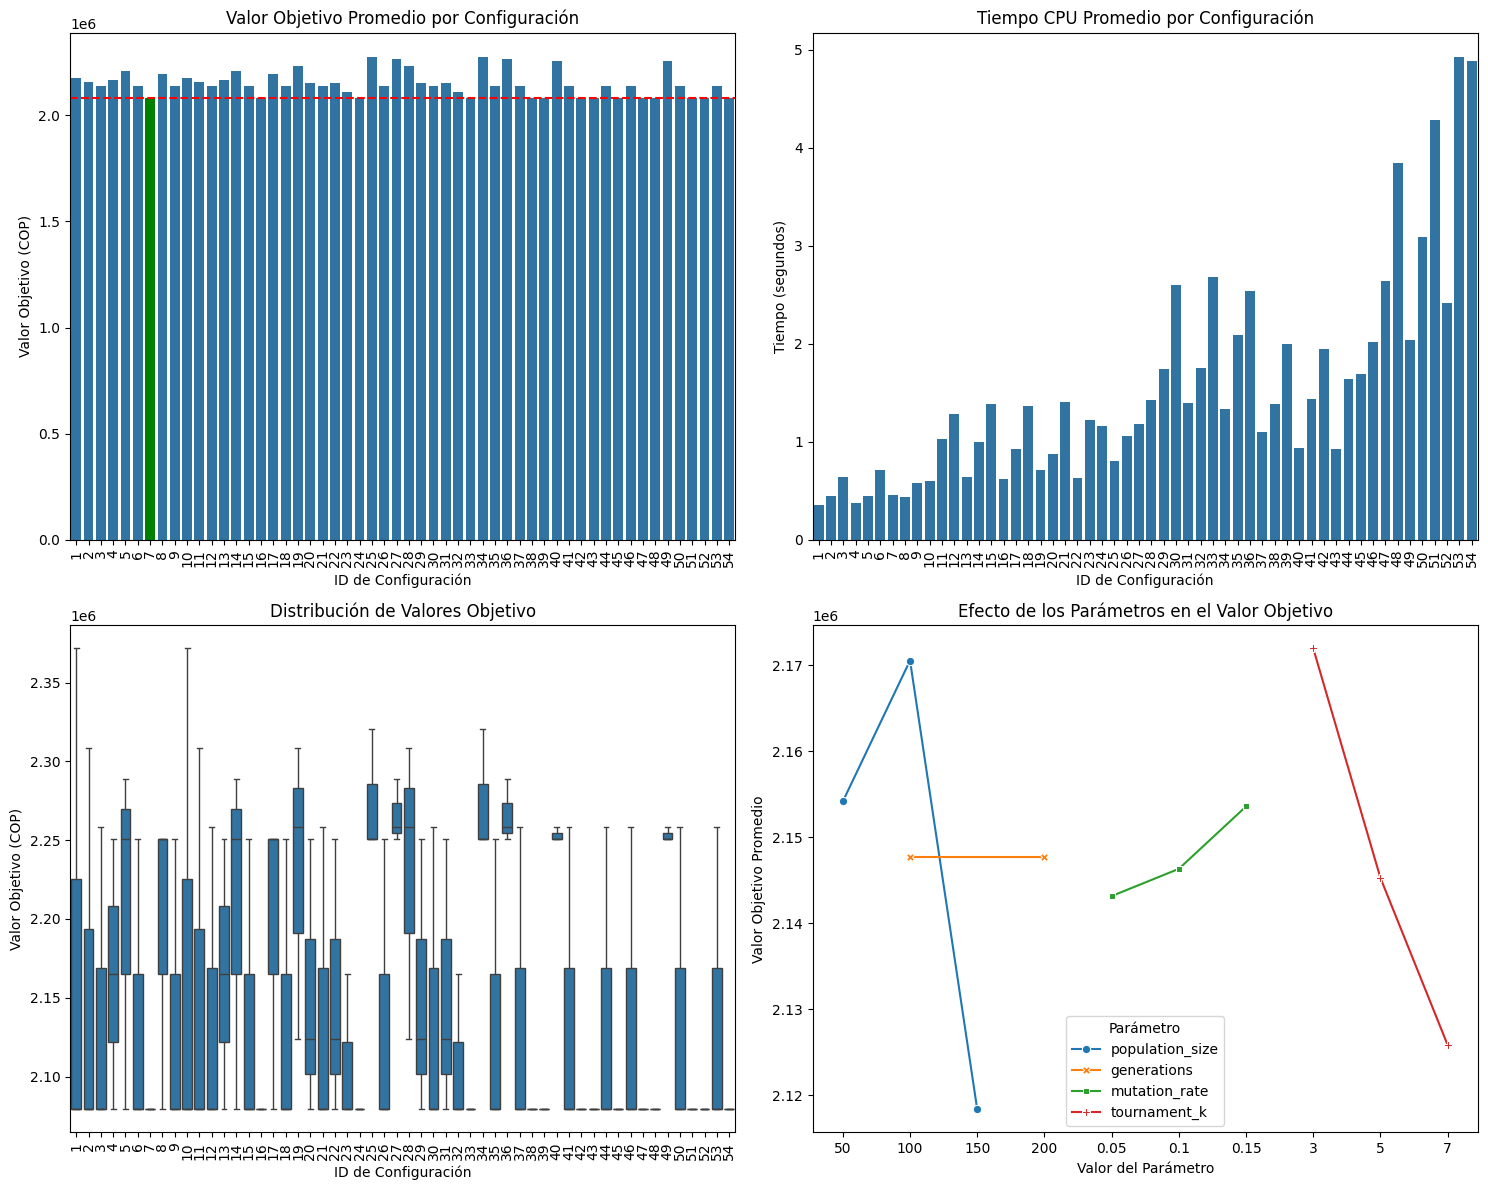

Visualizaciones guardadas en 'calibracion_graficos_2.png'
Best parameters for case 2: {'population_size': np.float64(50.0), 'generations': np.float64(100.0), 'mutation_rate': np.float64(0.15), 'tournament_k': np.float64(3.0)}
Results saved for case 2.
Solución guardada en formato solicitado: best_solution_case_2_formatted.csv

--- CALIBRATING FOR CASE: 3 ---
Loaded 90 clients for Case 3. First few: ['C1', 'C2', 'C3', 'C4', 'C5']
--- Calculating Distance Matrix using OSRM ---
  Distances loaded from GA cache (8281 pairs): Etapa3/cache/osrm_cache_ga_3.json
  No missing distance pairs for Case 3
Distance and cost matrices populated for case 3. 8281 entries.
--- DATA LOADING COMPLETE FOR CASE 3 ---

--- INICIANDO CALIBRACIÓN PARA CASO: 3 ---

Loaded 90 clients for Case 3. First few: ['C1', 'C2', 'C3', 'C4', 'C5']
--- Calculating Distance Matrix using OSRM ---
  Distances loaded from GA cache (8281 pairs): Etapa3/cache/osrm_cache_ga_3.json
  No missing distance pairs for Case 3
Distance and

Progreso de calibración:   0%|          | 0/54 [00:00<?, ?it/s]


Configuración #1/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/100 | Best Fitness: 32661399.78 | Avg Fitness: 36367776.84
Generation 3/100 | Best Fitness: 30335264.19 | Avg Fitness: 35836433.68
Generation 4/100 | Best Fitness: 30335264.19 | Avg Fitness: 35802697.89
Generation 5/100 | Best Fitness: 30335264.19 | Avg Fitness: 35150073.26
Generation 6/100 | Best Fitness: 30335264.19 | Avg Fitness: 35368058.58
Generation 7/100 | Best Fitness: 30335264.19 | Avg Fitness: 35566851.08
Generation 8/100 | Best Fitness: 30335264.19 | Avg Fitness: 34975455.72
Generation 9/100 | Best Fitness: 30335264.19 | Avg Fitness: 34564959.82
Generation 10/100 | Best Fitness: 30335264.19 | Avg Fitness: 34115552.34
Generation 11/100 | Best Fitness: 30335264.19 | Avg Fitness: 33763535.84
Generation 12/100 | Best Fitness: 30335264.19 | Avg Fitness: 34000437.

Progreso de calibración:   2%|▏         | 1/54 [00:13<12:18, 13.94s/it]

Generation 100/100 | Best Fitness: 25842157.38 | Avg Fitness: 26214814.10
--- Genetic Algorithm Finished ---

Configuración #2/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/100 | Best Fitness: 33380285.94 | Avg Fitness: 36229855.72
Generation 3/100 | Best Fitness: 33259836.78 | Avg Fitness: 35411723.29
Generation 4/100 | Best Fitness: 32266079.46 | Avg Fitness: 34915709.64
Generation 5/100 | Best Fitness: 32266079.46 | Avg Fitness: 34516225.18
Generation 6/100 | Best Fitness: 31911687.18 | Avg Fitness: 34110727.59
Generation 7/100 | Best Fitness: 31911687.18 | Avg Fitness: 33987596.99
Generation 8/100 | Best Fitness: 31881976.47 | Avg Fitness: 34147986.38
Generation 9/100 | Best Fitness: 31777936.20 | Avg Fitness: 33753031.88
Generation 10/100 | Best Fitness: 31232752.02 | Avg Fitness: 33572466.06
Generation 11/100 | Best Fitness: 

Progreso de calibración:   4%|▎         | 2/54 [00:37<16:58, 19.59s/it]

Generation 100/100 | Best Fitness: 24567670.80 | Avg Fitness: 25314707.76
--- Genetic Algorithm Finished ---

Configuración #3/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/100 | Best Fitness: 33669895.50 | Avg Fitness: 36097505.84
Generation 3/100 | Best Fitness: 33090841.98 | Avg Fitness: 35490914.37
Generation 4/100 | Best Fitness: 31285793.70 | Avg Fitness: 34879615.38
Generation 5/100 | Best Fitness: 31021022.07 | Avg Fitness: 34085845.69
Generation 6/100 | Best Fitness: 30310142.67 | Avg Fitness: 33300651.84
Generation 7/100 | Best Fitness: 30310142.67 | Avg Fitness: 32082633.16
Generation 8/100 | Best Fitness: 29973535.83 | Avg Fitness: 31372909.90
Generation 9/100 | Best Fitness: 29131826.22 | Avg Fitness: 31013363.73
Generation 10/100 | Best Fitness: 28963032.21 | Avg Fitness: 30949654.31
Generation 11/100 | Best Fitness: 

Progreso de calibración:   6%|▌         | 3/54 [01:08<20:54, 24.60s/it]

Generation 99/100 | Best Fitness: 26351097.93 | Avg Fitness: 26435677.55
Generation 100/100 | Best Fitness: 26284628.16 | Avg Fitness: 26411880.87
--- Genetic Algorithm Finished ---

Configuración #4/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/100 | Best Fitness: 32661399.78 | Avg Fitness: 36563656.60
Generation 3/100 | Best Fitness: 32496677.46 | Avg Fitness: 35452306.18
Generation 4/100 | Best Fitness: 32496677.46 | Avg Fitness: 35018833.98
Generation 5/100 | Best Fitness: 32496677.46 | Avg Fitness: 34768104.94
Generation 6/100 | Best Fitness: 31048658.64 | Avg Fitness: 34262703.51
Generation 7/100 | Best Fitness: 31048658.64 | Avg Fitness: 34245889.64
Generation 8/100 | Best Fitness: 30314822.94 | Avg Fitness: 33854383.88
Generation 9/100 | Best Fitness: 30314822.94 | Avg Fitness: 33616619.12
Generation 10/100 | Best Fitness: 3

Progreso de calibración:   7%|▋         | 4/54 [01:19<16:10, 19.41s/it]

Generation 96/100 | Best Fitness: 24402068.73 | Avg Fitness: 24777701.86
Generation 97/100 | Best Fitness: 24402068.73 | Avg Fitness: 24840558.36
Generation 98/100 | Best Fitness: 24326548.92 | Avg Fitness: 24666512.18
Generation 99/100 | Best Fitness: 24326548.92 | Avg Fitness: 24716799.56
Generation 100/100 | Best Fitness: 24326548.92 | Avg Fitness: 24754174.61
--- Genetic Algorithm Finished ---

Configuración #5/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/100 | Best Fitness: 33380285.94 | Avg Fitness: 36203796.74
Generation 3/100 | Best Fitness: 32973837.30 | Avg Fitness: 35373613.89
Generation 4/100 | Best Fitness: 31985967.06 | Avg Fitness: 34636251.65
Generation 5/100 | Best Fitness: 31175897.40 | Avg Fitness: 33844091.63
Generation 6/100 | Best Fitness: 31018703.67 | Avg Fitness: 33392795.49
Generation 7/100 | Best Fitness:

Progreso de calibración:   9%|▉         | 5/54 [01:35<14:56, 18.29s/it]

--- Genetic Algorithm Finished ---

Configuración #6/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/100 | Best Fitness: 33527746.53 | Avg Fitness: 35962128.67
Generation 3/100 | Best Fitness: 32638250.97 | Avg Fitness: 34788454.90
Generation 4/100 | Best Fitness: 31740287.04 | Avg Fitness: 34077299.98
Generation 5/100 | Best Fitness: 31405578.39 | Avg Fitness: 33704355.66
Generation 6/100 | Best Fitness: 30762555.66 | Avg Fitness: 33125081.77
Generation 7/100 | Best Fitness: 30244645.80 | Avg Fitness: 32915896.92
Generation 8/100 | Best Fitness: 29397013.92 | Avg Fitness: 32285742.39
Generation 9/100 | Best Fitness: 29397013.92 | Avg Fitness: 30943484.96
Generation 10/100 | Best Fitness: 29397013.92 | Avg Fitness: 30786729.08
Generation 11/100 | Best Fitness: 29397013.92 | Avg Fitness: 29937046.74
Generation 12/100 | Best Fitness: 29

Progreso de calibración:  11%|█         | 6/54 [01:58<15:57, 19.95s/it]

--- Genetic Algorithm Finished ---

Configuración #7/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/100 | Best Fitness: 33669895.50 | Avg Fitness: 36440059.79
Generation 3/100 | Best Fitness: 32697672.39 | Avg Fitness: 36467347.98
Generation 4/100 | Best Fitness: 31891169.34 | Avg Fitness: 35971178.01
Generation 5/100 | Best Fitness: 31891169.34 | Avg Fitness: 35253472.20
Generation 6/100 | Best Fitness: 31891169.34 | Avg Fitness: 34884624.86
Generation 7/100 | Best Fitness: 31817291.04 | Avg Fitness: 34602850.42
Generation 8/100 | Best Fitness: 30465229.14 | Avg Fitness: 33971942.90
Generation 9/100 | Best Fitness: 30465229.14 | Avg Fitness: 33806620.20
Generation 10/100 | Best Fitness: 30465229.14 | Avg Fitness: 33390074.97
Generation 11/100 | Best Fitness: 30438735.21 | Avg Fitness: 33063975.49
Generation 12/100 | Best Fitness: 2

Progreso de calibración:  13%|█▎        | 7/54 [02:09<13:18, 17.00s/it]

Generation 98/100 | Best Fitness: 25693767.36 | Avg Fitness: 26193097.93
Generation 99/100 | Best Fitness: 25693767.36 | Avg Fitness: 26108721.96
Generation 100/100 | Best Fitness: 25693767.36 | Avg Fitness: 25909112.73
--- Genetic Algorithm Finished ---

Configuración #8/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/100 | Best Fitness: 32907264.03 | Avg Fitness: 36203186.17
Generation 3/100 | Best Fitness: 32907264.03 | Avg Fitness: 35597872.18
Generation 4/100 | Best Fitness: 32801284.17 | Avg Fitness: 35104469.05
Generation 5/100 | Best Fitness: 32801284.17 | Avg Fitness: 34365256.44
Generation 6/100 | Best Fitness: 32296493.97 | Avg Fitness: 34436246.80
Generation 7/100 | Best Fitness: 31809971.52 | Avg Fitness: 34505067.80
Generation 8/100 | Best Fitness: 31227127.83 | Avg Fitness: 34390527.13
Generation 9/100 | Best Fitness: 

Progreso de calibración:  15%|█▍        | 8/54 [02:44<17:14, 22.49s/it]

--- Genetic Algorithm Finished ---

Configuración #9/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/100 | Best Fitness: 33527746.53 | Avg Fitness: 35884396.45
Generation 3/100 | Best Fitness: 32638250.97 | Avg Fitness: 34804714.83
Generation 4/100 | Best Fitness: 30667507.47 | Avg Fitness: 33889269.30
Generation 5/100 | Best Fitness: 30098694.24 | Avg Fitness: 33320372.89
Generation 6/100 | Best Fitness: 29901806.19 | Avg Fitness: 32361667.01
Generation 7/100 | Best Fitness: 29434561.65 | Avg Fitness: 31619370.89
Generation 8/100 | Best Fitness: 29087795.25 | Avg Fitness: 30614751.37
Generation 9/100 | Best Fitness: 28654784.37 | Avg Fitness: 30365259.52
Generation 10/100 | Best Fitness: 28654784.37 | Avg Fitness: 29901409.95
Generation 11/100 | Best Fitness: 28492945.56 | Avg Fitness: 29320628.85
Generation 12/100 | Best Fitness: 2

Progreso de calibración:  17%|█▋        | 9/54 [03:16<19:06, 25.49s/it]

Generation 99/100 | Best Fitness: 23608219.59 | Avg Fitness: 23909296.70
Generation 100/100 | Best Fitness: 23607619.29 | Avg Fitness: 23870042.92
--- Genetic Algorithm Finished ---

Configuración #10/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/200 | Best Fitness: 32661399.78 | Avg Fitness: 36367776.84
Generation 3/200 | Best Fitness: 30335264.19 | Avg Fitness: 35836433.68
Generation 4/200 | Best Fitness: 30335264.19 | Avg Fitness: 35802697.89
Generation 5/200 | Best Fitness: 30335264.19 | Avg Fitness: 35150073.26
Generation 6/200 | Best Fitness: 30335264.19 | Avg Fitness: 35368058.58
Generation 7/200 | Best Fitness: 30335264.19 | Avg Fitness: 35566851.08
Generation 8/200 | Best Fitness: 30335264.19 | Avg Fitness: 34975455.72
Generation 9/200 | Best Fitness: 30335264.19 | Avg Fitness: 34564959.82
Generation 10/200 | Best Fitness:

Progreso de calibración:  19%|█▊        | 10/54 [03:42<18:52, 25.74s/it]

Generation 194/200 | Best Fitness: 24795958.68 | Avg Fitness: 25027105.93
Generation 195/200 | Best Fitness: 24795958.68 | Avg Fitness: 25099962.81
Generation 196/200 | Best Fitness: 24780328.11 | Avg Fitness: 24975974.20
Generation 197/200 | Best Fitness: 24780328.11 | Avg Fitness: 24823734.98
Generation 198/200 | Best Fitness: 24780328.11 | Avg Fitness: 24808603.81
Generation 199/200 | Best Fitness: 24780328.11 | Avg Fitness: 24828446.87
Generation 200/200 | Best Fitness: 24780328.11 | Avg Fitness: 24795958.68
--- Genetic Algorithm Finished ---

Configuración #11/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/200 | Best Fitness: 33380285.94 | Avg Fitness: 36229855.72
Generation 3/200 | Best Fitness: 33259836.78 | Avg Fitness: 35411723.29
Generation 4/200 | Best Fitness: 32266079.46 | Avg Fitness: 34915709.64
Generation 5/200 | Bes

Progreso de calibración:  20%|██        | 11/54 [04:17<20:28, 28.58s/it]

Generation 198/200 | Best Fitness: 22937570.64 | Avg Fitness: 22937570.64
Generation 199/200 | Best Fitness: 22937570.64 | Avg Fitness: 22937570.64
Generation 200/200 | Best Fitness: 22937570.64 | Avg Fitness: 23022965.10
--- Genetic Algorithm Finished ---

Configuración #12/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/200 | Best Fitness: 33669895.50 | Avg Fitness: 36097505.84
Generation 3/200 | Best Fitness: 33090841.98 | Avg Fitness: 35490914.37
Generation 4/200 | Best Fitness: 31285793.70 | Avg Fitness: 34879615.38
Generation 5/200 | Best Fitness: 31021022.07 | Avg Fitness: 34085845.69
Generation 6/200 | Best Fitness: 30310142.67 | Avg Fitness: 33300651.84
Generation 7/200 | Best Fitness: 30310142.67 | Avg Fitness: 32082633.16
Generation 8/200 | Best Fitness: 29973535.83 | Avg Fitness: 31372909.90
Generation 9/200 | Best Fitnes

Progreso de calibración:  22%|██▏       | 12/54 [05:48<33:15, 47.52s/it]

Generation 197/200 | Best Fitness: 24791965.65 | Avg Fitness: 24791965.65
Generation 198/200 | Best Fitness: 24791965.65 | Avg Fitness: 24806677.89
Generation 199/200 | Best Fitness: 24791965.65 | Avg Fitness: 24818761.80
Generation 200/200 | Best Fitness: 24781491.45 | Avg Fitness: 24859044.95
--- Genetic Algorithm Finished ---

Configuración #13/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/200 | Best Fitness: 32661399.78 | Avg Fitness: 36563656.60
Generation 3/200 | Best Fitness: 32496677.46 | Avg Fitness: 35452306.18
Generation 4/200 | Best Fitness: 32496677.46 | Avg Fitness: 35018833.98
Generation 5/200 | Best Fitness: 32496677.46 | Avg Fitness: 34768104.94
Generation 6/200 | Best Fitness: 31048658.64 | Avg Fitness: 34262703.51
Generation 7/200 | Best Fitness: 31048658.64 | Avg Fitness: 34245889.64
Generation 8/200 | Best Fitne

Progreso de calibración:  24%|██▍       | 13/54 [06:14<27:56, 40.89s/it]

Generation 200/200 | Best Fitness: 22445953.92 | Avg Fitness: 22531385.64
--- Genetic Algorithm Finished ---

Configuración #14/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/200 | Best Fitness: 33380285.94 | Avg Fitness: 36203796.74
Generation 3/200 | Best Fitness: 32973837.30 | Avg Fitness: 35373613.89
Generation 4/200 | Best Fitness: 31985967.06 | Avg Fitness: 34636251.65
Generation 5/200 | Best Fitness: 31175897.40 | Avg Fitness: 33844091.63
Generation 6/200 | Best Fitness: 31018703.67 | Avg Fitness: 33392795.49
Generation 7/200 | Best Fitness: 30638933.19 | Avg Fitness: 32288015.58
Generation 8/200 | Best Fitness: 30481969.23 | Avg Fitness: 31657474.16
Generation 9/200 | Best Fitness: 30481969.23 | Avg Fitness: 31701646.68
Generation 10/200 | Best Fitness: 30278738.70 | Avg Fitness: 31395358.26
Generation 11/200 | Best Fitness: 

Progreso de calibración:  26%|██▌       | 14/54 [06:52<26:48, 40.21s/it]

Generation 198/200 | Best Fitness: 22371537.42 | Avg Fitness: 22499917.79
Generation 199/200 | Best Fitness: 22371537.42 | Avg Fitness: 22408682.54
Generation 200/200 | Best Fitness: 22371537.42 | Avg Fitness: 22530304.89
--- Genetic Algorithm Finished ---

Configuración #15/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/200 | Best Fitness: 33527746.53 | Avg Fitness: 35962128.67
Generation 3/200 | Best Fitness: 32638250.97 | Avg Fitness: 34788454.90
Generation 4/200 | Best Fitness: 31740287.04 | Avg Fitness: 34077299.98
Generation 5/200 | Best Fitness: 31405578.39 | Avg Fitness: 33704355.66
Generation 6/200 | Best Fitness: 30762555.66 | Avg Fitness: 33125081.77
Generation 7/200 | Best Fitness: 30244645.80 | Avg Fitness: 32915896.92
Generation 8/200 | Best Fitness: 29397013.92 | Avg Fitness: 32285742.39
Generation 9/200 | Best Fitness

Progreso de calibración:  28%|██▊       | 15/54 [07:49<29:18, 45.10s/it]

Generation 199/200 | Best Fitness: 23086372.59 | Avg Fitness: 23167458.96
Generation 200/200 | Best Fitness: 22975416.45 | Avg Fitness: 23144722.95
--- Genetic Algorithm Finished ---

Configuración #16/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/200 | Best Fitness: 33669895.50 | Avg Fitness: 36440059.79
Generation 3/200 | Best Fitness: 32697672.39 | Avg Fitness: 36467347.98
Generation 4/200 | Best Fitness: 31891169.34 | Avg Fitness: 35971178.01
Generation 5/200 | Best Fitness: 31891169.34 | Avg Fitness: 35253472.20
Generation 6/200 | Best Fitness: 31891169.34 | Avg Fitness: 34884624.86
Generation 7/200 | Best Fitness: 31817291.04 | Avg Fitness: 34602850.42
Generation 8/200 | Best Fitness: 30465229.14 | Avg Fitness: 33971942.90
Generation 9/200 | Best Fitness: 30465229.14 | Avg Fitness: 33806620.20
Generation 10/200 | Best Fitness

Progreso de calibración:  30%|██▉       | 16/54 [08:12<24:30, 38.68s/it]


Configuración #17/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/200 | Best Fitness: 32907264.03 | Avg Fitness: 36203186.17
Generation 3/200 | Best Fitness: 32907264.03 | Avg Fitness: 35597872.18
Generation 4/200 | Best Fitness: 32801284.17 | Avg Fitness: 35104469.05
Generation 5/200 | Best Fitness: 32801284.17 | Avg Fitness: 34365256.44
Generation 6/200 | Best Fitness: 32296493.97 | Avg Fitness: 34436246.80
Generation 7/200 | Best Fitness: 31809971.52 | Avg Fitness: 34505067.80
Generation 8/200 | Best Fitness: 31227127.83 | Avg Fitness: 34390527.13
Generation 9/200 | Best Fitness: 31227127.83 | Avg Fitness: 34144939.84
Generation 10/200 | Best Fitness: 29971879.83 | Avg Fitness: 33466951.04
Generation 11/200 | Best Fitness: 29971879.83 | Avg Fitness: 32764029.39
Generation 12/200 | Best Fitness: 29243388.87 | Avg Fitness: 32421060

Progreso de calibración:  31%|███▏      | 17/54 [08:44<22:29, 36.48s/it]

--- Genetic Algorithm Finished ---

Configuración #18/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37798277.21
Generation 2/200 | Best Fitness: 33527746.53 | Avg Fitness: 35884396.45
Generation 3/200 | Best Fitness: 32638250.97 | Avg Fitness: 34804714.83
Generation 4/200 | Best Fitness: 30667507.47 | Avg Fitness: 33889269.30
Generation 5/200 | Best Fitness: 30098694.24 | Avg Fitness: 33320372.89
Generation 6/200 | Best Fitness: 29901806.19 | Avg Fitness: 32361667.01
Generation 7/200 | Best Fitness: 29434561.65 | Avg Fitness: 31619370.89
Generation 8/200 | Best Fitness: 29087795.25 | Avg Fitness: 30614751.37
Generation 9/200 | Best Fitness: 28654784.37 | Avg Fitness: 30365259.52
Generation 10/200 | Best Fitness: 28654784.37 | Avg Fitness: 29901409.95
Generation 11/200 | Best Fitness: 28492945.56 | Avg Fitness: 29320628.85
Generation 12/200 | Best Fitness: 

Progreso de calibración:  33%|███▎      | 18/54 [09:31<23:50, 39.74s/it]

Generation 200/200 | Best Fitness: 22071517.83 | Avg Fitness: 22170007.85
--- Genetic Algorithm Finished ---

Configuración #19/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/100 | Best Fitness: 33669895.50 | Avg Fitness: 36931103.89
Generation 3/100 | Best Fitness: 32624230.86 | Avg Fitness: 36357038.68
Generation 4/100 | Best Fitness: 32624230.86 | Avg Fitness: 35831875.37
Generation 5/100 | Best Fitness: 32468241.87 | Avg Fitness: 35236948.30
Generation 6/100 | Best Fitness: 31842489.15 | Avg Fitness: 35057822.30
Generation 7/100 | Best Fitness: 29759483.34 | Avg Fitness: 34597100.33
Generation 8/100 | Best Fitness: 29759483.34 | Avg Fitness: 34442557.34
Generation 9/100 | Best Fitness: 29759483.34 | Avg Fitness: 33982910.32
Generation 10/100 | Best Fitness: 29614103.10 | Avg Fitness: 33878285.57
Generation 11/100 | Best Fitness

Progreso de calibración:  35%|███▌      | 19/54 [09:54<20:10, 34.57s/it]

Generation 100/100 | Best Fitness: 23379637.77 | Avg Fitness: 23569284.84
--- Genetic Algorithm Finished ---

Configuración #20/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/100 | Best Fitness: 33230726.37 | Avg Fitness: 36592878.19
Generation 3/100 | Best Fitness: 31418880.21 | Avg Fitness: 35579708.96
Generation 4/100 | Best Fitness: 30996453.24 | Avg Fitness: 34711300.58
Generation 5/100 | Best Fitness: 30775522.14 | Avg Fitness: 34153338.99
Generation 6/100 | Best Fitness: 30533824.80 | Avg Fitness: 33759695.23
Generation 7/100 | Best Fitness: 30533824.80 | Avg Fitness: 33726092.13
Generation 8/100 | Best Fitness: 30485186.01 | Avg Fitness: 33103177.50
Generation 9/100 | Best Fitness: 30333719.97 | Avg Fitness: 32563057.97
Generation 10/100 | Best Fitness: 29293760.25 | Avg Fitness: 32370620.13
Generation 11/100 | Best Fitness

Progreso de calibración:  37%|███▋      | 20/54 [10:27<19:24, 34.24s/it]

Generation 100/100 | Best Fitness: 23460421.59 | Avg Fitness: 23704345.82
--- Genetic Algorithm Finished ---

Configuración #21/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/100 | Best Fitness: 33037976.25 | Avg Fitness: 36042669.23
Generation 3/100 | Best Fitness: 31532419.71 | Avg Fitness: 34807891.27
Generation 4/100 | Best Fitness: 31039931.52 | Avg Fitness: 34159821.92
Generation 5/100 | Best Fitness: 31039931.52 | Avg Fitness: 33694370.91
Generation 6/100 | Best Fitness: 30746273.04 | Avg Fitness: 33669416.65
Generation 7/100 | Best Fitness: 30746273.04 | Avg Fitness: 33262353.51
Generation 8/100 | Best Fitness: 30041963.82 | Avg Fitness: 33017653.51
Generation 9/100 | Best Fitness: 29895463.71 | Avg Fitness: 32553247.41
Generation 10/100 | Best Fitness: 29237462.46 | Avg Fitness: 31976965.35
Generation 11/100 | Best Fitness

Progreso de calibración:  39%|███▉      | 21/54 [11:11<20:26, 37.18s/it]

Generation 100/100 | Best Fitness: 22209027.93 | Avg Fitness: 22570140.92
--- Genetic Algorithm Finished ---

Configuración #22/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/100 | Best Fitness: 33384910.32 | Avg Fitness: 36641303.19
Generation 3/100 | Best Fitness: 32031498.78 | Avg Fitness: 36257456.48
Generation 4/100 | Best Fitness: 31362926.04 | Avg Fitness: 35491407.98
Generation 5/100 | Best Fitness: 31362926.04 | Avg Fitness: 34761236.82
Generation 6/100 | Best Fitness: 31362926.04 | Avg Fitness: 34484733.84
Generation 7/100 | Best Fitness: 31362926.04 | Avg Fitness: 34363637.80
Generation 8/100 | Best Fitness: 31289231.97 | Avg Fitness: 34108449.96
Generation 9/100 | Best Fitness: 31289231.97 | Avg Fitness: 33867933.02
Generation 10/100 | Best Fitness: 31289231.97 | Avg Fitness: 33862002.84
Generation 11/100 | Best Fitness:

Progreso de calibración:  41%|████      | 22/54 [11:35<17:39, 33.10s/it]

--- Genetic Algorithm Finished ---

Configuración #23/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/100 | Best Fitness: 32701458.42 | Avg Fitness: 36629961.22
Generation 3/100 | Best Fitness: 32474288.34 | Avg Fitness: 35137369.57
Generation 4/100 | Best Fitness: 31960278.36 | Avg Fitness: 34477632.21
Generation 5/100 | Best Fitness: 31629262.59 | Avg Fitness: 34103869.45
Generation 6/100 | Best Fitness: 30897660.42 | Avg Fitness: 33849453.76
Generation 7/100 | Best Fitness: 30897660.42 | Avg Fitness: 33484198.68
Generation 8/100 | Best Fitness: 30897660.42 | Avg Fitness: 33268549.02
Generation 9/100 | Best Fitness: 29848160.07 | Avg Fitness: 33294886.00
Generation 10/100 | Best Fitness: 29848160.07 | Avg Fitness: 33092154.73
Generation 11/100 | Best Fitness: 29848160.07 | Avg Fitness: 33037541.03
Generation 12/100 | Best Fitness: 

Progreso de calibración:  43%|████▎     | 23/54 [12:08<17:03, 33.03s/it]

Generation 100/100 | Best Fitness: 23604474.96 | Avg Fitness: 23851110.86
--- Genetic Algorithm Finished ---

Configuración #24/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/100 | Best Fitness: 33169543.38 | Avg Fitness: 36141724.83
Generation 3/100 | Best Fitness: 32784703.47 | Avg Fitness: 34962276.71
Generation 4/100 | Best Fitness: 32388277.77 | Avg Fitness: 34266986.94
Generation 5/100 | Best Fitness: 32242978.26 | Avg Fitness: 33865249.18
Generation 6/100 | Best Fitness: 31381603.65 | Avg Fitness: 33787172.70
Generation 7/100 | Best Fitness: 31255606.89 | Avg Fitness: 33150878.48
Generation 8/100 | Best Fitness: 29743827.93 | Avg Fitness: 32497572.84
Generation 9/100 | Best Fitness: 29549113.38 | Avg Fitness: 31952103.08
Generation 10/100 | Best Fitness: 29351256.57 | Avg Fitness: 31759748.66
Generation 11/100 | Best Fitness:

Progreso de calibración:  44%|████▍     | 24/54 [12:50<17:56, 35.89s/it]

--- Genetic Algorithm Finished ---

Configuración #25/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/100 | Best Fitness: 33669895.50 | Avg Fitness: 36655113.31
Generation 3/100 | Best Fitness: 32892664.32 | Avg Fitness: 36253001.92
Generation 4/100 | Best Fitness: 32297123.25 | Avg Fitness: 35490455.57
Generation 5/100 | Best Fitness: 31832315.10 | Avg Fitness: 35043750.75
Generation 6/100 | Best Fitness: 31832315.10 | Avg Fitness: 34746821.98
Generation 7/100 | Best Fitness: 31832315.10 | Avg Fitness: 34607392.79
Generation 8/100 | Best Fitness: 31708616.04 | Avg Fitness: 34512362.94
Generation 9/100 | Best Fitness: 30831459.75 | Avg Fitness: 34288766.26
Generation 10/100 | Best Fitness: 30178871.55 | Avg Fitness: 34161573.14
Generation 11/100 | Best Fitness: 30178871.55 | Avg Fitness: 33860581.48
Generation 12/100 | Best Fitness:

Progreso de calibración:  46%|████▋     | 25/54 [13:13<15:29, 32.05s/it]

Generation 99/100 | Best Fitness: 21722789.07 | Avg Fitness: 22452281.50
Generation 100/100 | Best Fitness: 21621029.94 | Avg Fitness: 22328466.52
--- Genetic Algorithm Finished ---

Configuración #26/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/100 | Best Fitness: 31942509.48 | Avg Fitness: 36291686.42
Generation 3/100 | Best Fitness: 31942509.48 | Avg Fitness: 35102487.38
Generation 4/100 | Best Fitness: 31942509.48 | Avg Fitness: 34508265.21
Generation 5/100 | Best Fitness: 31026724.92 | Avg Fitness: 34056088.51
Generation 6/100 | Best Fitness: 31026724.92 | Avg Fitness: 33710934.08
Generation 7/100 | Best Fitness: 30544288.65 | Avg Fitness: 33336978.17
Generation 8/100 | Best Fitness: 29754540.18 | Avg Fitness: 32938823.02
Generation 9/100 | Best Fitness: 29754540.18 | Avg Fitness: 32889265.15
Generation 10/100 | Best Fitness

Progreso de calibración:  48%|████▊     | 26/54 [13:46<15:07, 32.41s/it]

Generation 100/100 | Best Fitness: 21331122.30 | Avg Fitness: 22153953.51
--- Genetic Algorithm Finished ---

Configuración #27/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/100 | Best Fitness: 32420499.39 | Avg Fitness: 36098900.77
Generation 3/100 | Best Fitness: 31610518.74 | Avg Fitness: 34936375.92
Generation 4/100 | Best Fitness: 31184440.29 | Avg Fitness: 33865876.04
Generation 5/100 | Best Fitness: 30865244.22 | Avg Fitness: 33790064.65
Generation 6/100 | Best Fitness: 30667213.53 | Avg Fitness: 33444075.18
Generation 7/100 | Best Fitness: 30009909.87 | Avg Fitness: 32712576.99
Generation 8/100 | Best Fitness: 29637191.88 | Avg Fitness: 32040112.30
Generation 9/100 | Best Fitness: 28807227.45 | Avg Fitness: 31450237.58
Generation 10/100 | Best Fitness: 27345428.64 | Avg Fitness: 30627018.68
Generation 11/100 | Best Fitness

Progreso de calibración:  50%|█████     | 27/54 [14:32<16:18, 36.26s/it]

Generation 99/100 | Best Fitness: 23007342.06 | Avg Fitness: 23633043.30
Generation 100/100 | Best Fitness: 22946575.14 | Avg Fitness: 23145382.41
--- Genetic Algorithm Finished ---

Configuración #28/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/200 | Best Fitness: 33669895.50 | Avg Fitness: 36931103.89
Generation 3/200 | Best Fitness: 32624230.86 | Avg Fitness: 36357038.68
Generation 4/200 | Best Fitness: 32624230.86 | Avg Fitness: 35831875.37
Generation 5/200 | Best Fitness: 32468241.87 | Avg Fitness: 35236948.30
Generation 6/200 | Best Fitness: 31842489.15 | Avg Fitness: 35057822.30
Generation 7/200 | Best Fitness: 29759483.34 | Avg Fitness: 34597100.33
Generation 8/200 | Best Fitness: 29759483.34 | Avg Fitness: 34442557.34
Generation 9/200 | Best Fitness: 29759483.34 | Avg Fitness: 33982910.32
Generation 10/200 | Best Fitness

Progreso de calibración:  52%|█████▏    | 28/54 [15:16<16:48, 38.77s/it]

Generation 198/200 | Best Fitness: 22021461.09 | Avg Fitness: 22274767.22
Generation 199/200 | Best Fitness: 22021461.09 | Avg Fitness: 22353958.65
Generation 200/200 | Best Fitness: 22021461.09 | Avg Fitness: 22347791.62
--- Genetic Algorithm Finished ---

Configuración #29/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/200 | Best Fitness: 33230726.37 | Avg Fitness: 36592878.19
Generation 3/200 | Best Fitness: 31418880.21 | Avg Fitness: 35579708.96
Generation 4/200 | Best Fitness: 30996453.24 | Avg Fitness: 34711300.58
Generation 5/200 | Best Fitness: 30775522.14 | Avg Fitness: 34153338.99
Generation 6/200 | Best Fitness: 30533824.80 | Avg Fitness: 33759695.23
Generation 7/200 | Best Fitness: 30533824.80 | Avg Fitness: 33726092.13
Generation 8/200 | Best Fitness: 30485186.01 | Avg Fitness: 33103177.50
Generation 9/200 | Best Fitne

Progreso de calibración:  54%|█████▎    | 29/54 [16:21<19:22, 46.50s/it]

Generation 199/200 | Best Fitness: 22488076.35 | Avg Fitness: 22625788.63
Generation 200/200 | Best Fitness: 22488076.35 | Avg Fitness: 22596493.86
--- Genetic Algorithm Finished ---

Configuración #30/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/200 | Best Fitness: 33037976.25 | Avg Fitness: 36042669.23
Generation 3/200 | Best Fitness: 31532419.71 | Avg Fitness: 34807891.27
Generation 4/200 | Best Fitness: 31039931.52 | Avg Fitness: 34159821.92
Generation 5/200 | Best Fitness: 31039931.52 | Avg Fitness: 33694370.91
Generation 6/200 | Best Fitness: 30746273.04 | Avg Fitness: 33669416.65
Generation 7/200 | Best Fitness: 30746273.04 | Avg Fitness: 33262353.51
Generation 8/200 | Best Fitness: 30041963.82 | Avg Fitness: 33017653.51
Generation 9/200 | Best Fitness: 29895463.71 | Avg Fitness: 32553247.41
Generation 10/200 | Best Fitnes

Progreso de calibración:  56%|█████▌    | 30/54 [17:51<23:46, 59.46s/it]

Generation 200/200 | Best Fitness: 21050879.49 | Avg Fitness: 21197814.90
--- Genetic Algorithm Finished ---

Configuración #31/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/200 | Best Fitness: 33384910.32 | Avg Fitness: 36641303.19
Generation 3/200 | Best Fitness: 32031498.78 | Avg Fitness: 36257456.48
Generation 4/200 | Best Fitness: 31362926.04 | Avg Fitness: 35491407.98
Generation 5/200 | Best Fitness: 31362926.04 | Avg Fitness: 34761236.82
Generation 6/200 | Best Fitness: 31362926.04 | Avg Fitness: 34484733.84
Generation 7/200 | Best Fitness: 31362926.04 | Avg Fitness: 34363637.80
Generation 8/200 | Best Fitness: 31289231.97 | Avg Fitness: 34108449.96
Generation 9/200 | Best Fitness: 31289231.97 | Avg Fitness: 33867933.02
Generation 10/200 | Best Fitness: 31289231.97 | Avg Fitness: 33862002.84
Generation 11/200 | Best Fitness:

Progreso de calibración:  57%|█████▋    | 31/54 [19:00<23:54, 62.38s/it]

Generation 200/200 | Best Fitness: 20572055.37 | Avg Fitness: 20973200.38
--- Genetic Algorithm Finished ---

Configuración #32/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/200 | Best Fitness: 32701458.42 | Avg Fitness: 36629961.22
Generation 3/200 | Best Fitness: 32474288.34 | Avg Fitness: 35137369.57
Generation 4/200 | Best Fitness: 31960278.36 | Avg Fitness: 34477632.21
Generation 5/200 | Best Fitness: 31629262.59 | Avg Fitness: 34103869.45
Generation 6/200 | Best Fitness: 30897660.42 | Avg Fitness: 33849453.76
Generation 7/200 | Best Fitness: 30897660.42 | Avg Fitness: 33484198.68
Generation 8/200 | Best Fitness: 30897660.42 | Avg Fitness: 33268549.02
Generation 9/200 | Best Fitness: 29848160.07 | Avg Fitness: 33294886.00
Generation 10/200 | Best Fitness: 29848160.07 | Avg Fitness: 33092154.73
Generation 11/200 | Best Fitness:

Progreso de calibración:  59%|█████▉    | 32/54 [20:25<25:20, 69.11s/it]


Configuración #33/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/200 | Best Fitness: 33169543.38 | Avg Fitness: 36141724.83
Generation 3/200 | Best Fitness: 32784703.47 | Avg Fitness: 34962276.71
Generation 4/200 | Best Fitness: 32388277.77 | Avg Fitness: 34266986.94
Generation 5/200 | Best Fitness: 32242978.26 | Avg Fitness: 33865249.18
Generation 6/200 | Best Fitness: 31381603.65 | Avg Fitness: 33787172.70
Generation 7/200 | Best Fitness: 31255606.89 | Avg Fitness: 33150878.48
Generation 8/200 | Best Fitness: 29743827.93 | Avg Fitness: 32497572.84
Generation 9/200 | Best Fitness: 29549113.38 | Avg Fitness: 31952103.08
Generation 10/200 | Best Fitness: 29351256.57 | Avg Fitness: 31759748.66
Generation 11/200 | Best Fitness: 29025415.80 | Avg Fitness: 31274891.65
Generation 12/200 | Best Fitness: 28898384.04 | Avg Fitness: 30831888

Progreso de calibración:  61%|██████    | 33/54 [22:27<29:50, 85.25s/it]

Generation 200/200 | Best Fitness: 20887674.48 | Avg Fitness: 21241162.58
--- Genetic Algorithm Finished ---

Configuración #34/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/200 | Best Fitness: 33669895.50 | Avg Fitness: 36655113.31
Generation 3/200 | Best Fitness: 32892664.32 | Avg Fitness: 36253001.92
Generation 4/200 | Best Fitness: 32297123.25 | Avg Fitness: 35490455.57
Generation 5/200 | Best Fitness: 31832315.10 | Avg Fitness: 35043750.75
Generation 6/200 | Best Fitness: 31832315.10 | Avg Fitness: 34746821.98
Generation 7/200 | Best Fitness: 31832315.10 | Avg Fitness: 34607392.79
Generation 8/200 | Best Fitness: 31708616.04 | Avg Fitness: 34512362.94
Generation 9/200 | Best Fitness: 30831459.75 | Avg Fitness: 34288766.26
Generation 10/200 | Best Fitness: 30178871.55 | Avg Fitness: 34161573.14
Generation 11/200 | Best Fitness

Progreso de calibración:  63%|██████▎   | 34/54 [23:35<26:40, 80.05s/it]


Configuración #35/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/200 | Best Fitness: 31942509.48 | Avg Fitness: 36291686.42
Generation 3/200 | Best Fitness: 31942509.48 | Avg Fitness: 35102487.38
Generation 4/200 | Best Fitness: 31942509.48 | Avg Fitness: 34508265.21
Generation 5/200 | Best Fitness: 31026724.92 | Avg Fitness: 34056088.51
Generation 6/200 | Best Fitness: 31026724.92 | Avg Fitness: 33710934.08
Generation 7/200 | Best Fitness: 30544288.65 | Avg Fitness: 33336978.17
Generation 8/200 | Best Fitness: 29754540.18 | Avg Fitness: 32938823.02
Generation 9/200 | Best Fitness: 29754540.18 | Avg Fitness: 32889265.15
Generation 10/200 | Best Fitness: 29754540.18 | Avg Fitness: 32676267.80
Generation 11/200 | Best Fitness: 29754540.18 | Avg Fitness: 32696735.86
Generation 12/200 | Best Fitness: 29754540.18 | Avg Fitness: 3260253

Progreso de calibración:  65%|██████▍   | 35/54 [25:15<27:13, 85.98s/it]

--- Genetic Algorithm Finished ---

Configuración #36/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37815835.12
Generation 2/200 | Best Fitness: 32420499.39 | Avg Fitness: 36098900.77
Generation 3/200 | Best Fitness: 31610518.74 | Avg Fitness: 34936375.92
Generation 4/200 | Best Fitness: 31184440.29 | Avg Fitness: 33865876.04
Generation 5/200 | Best Fitness: 30865244.22 | Avg Fitness: 33790064.65
Generation 6/200 | Best Fitness: 30667213.53 | Avg Fitness: 33444075.18
Generation 7/200 | Best Fitness: 30009909.87 | Avg Fitness: 32712576.99
Generation 8/200 | Best Fitness: 29637191.88 | Avg Fitness: 32040112.30
Generation 9/200 | Best Fitness: 28807227.45 | Avg Fitness: 31450237.58
Generation 10/200 | Best Fitness: 27345428.64 | Avg Fitness: 30627018.68
Generation 11/200 | Best Fitness: 27345428.64 | Avg Fitness: 29824838.58
Generation 12/200 | Best Fitness:

Progreso de calibración:  67%|██████▋   | 36/54 [27:19<29:09, 97.22s/it]

Generation 200/200 | Best Fitness: 21018308.04 | Avg Fitness: 21462472.78
--- Genetic Algorithm Finished ---

Configuración #37/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/100 | Best Fitness: 33325797.33 | Avg Fitness: 36885827.64
Generation 3/100 | Best Fitness: 32749509.33 | Avg Fitness: 35858154.90
Generation 4/100 | Best Fitness: 32068562.13 | Avg Fitness: 35386174.82
Generation 5/100 | Best Fitness: 31973114.43 | Avg Fitness: 35136155.82
Generation 6/100 | Best Fitness: 31795901.73 | Avg Fitness: 35014857.73
Generation 7/100 | Best Fitness: 31795901.73 | Avg Fitness: 34775186.19
Generation 8/100 | Best Fitness: 30773541.15 | Avg Fitness: 34562178.88
Generation 9/100 | Best Fitness: 30638840.04 | Avg Fitness: 34111474.21
Generation 10/100 | Best Fitness: 29732157.27 | Avg Fitness: 33494103.88
Generation 11/100 | Best Fitness

Progreso de calibración:  69%|██████▊   | 37/54 [28:01<22:54, 80.85s/it]

--- Genetic Algorithm Finished ---

Configuración #38/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/100 | Best Fitness: 32923855.08 | Avg Fitness: 36397252.37
Generation 3/100 | Best Fitness: 32105851.11 | Avg Fitness: 35537056.09
Generation 4/100 | Best Fitness: 31559248.98 | Avg Fitness: 34916495.04
Generation 5/100 | Best Fitness: 30701231.91 | Avg Fitness: 34283369.71
Generation 6/100 | Best Fitness: 30599578.35 | Avg Fitness: 34170043.06
Generation 7/100 | Best Fitness: 30599578.35 | Avg Fitness: 33868880.52
Generation 8/100 | Best Fitness: 30599578.35 | Avg Fitness: 33733348.07
Generation 9/100 | Best Fitness: 30025234.08 | Avg Fitness: 33454309.17
Generation 10/100 | Best Fitness: 29564216.10 | Avg Fitness: 32977573.93
Generation 11/100 | Best Fitness: 29080415.70 | Avg Fitness: 32835210.28
Generation 12/100 | Best Fitness:

Progreso de calibración:  70%|███████   | 38/54 [29:07<20:22, 76.43s/it]

Generation 100/100 | Best Fitness: 22305026.25 | Avg Fitness: 22537742.73
--- Genetic Algorithm Finished ---

Configuración #39/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/100 | Best Fitness: 33090686.73 | Avg Fitness: 36301910.99
Generation 3/100 | Best Fitness: 31452855.12 | Avg Fitness: 35126728.24
Generation 4/100 | Best Fitness: 31452855.12 | Avg Fitness: 34440572.36
Generation 5/100 | Best Fitness: 31278027.06 | Avg Fitness: 33670788.97
Generation 6/100 | Best Fitness: 29847408.66 | Avg Fitness: 33385836.59
Generation 7/100 | Best Fitness: 29847408.66 | Avg Fitness: 33062115.13
Generation 8/100 | Best Fitness: 29598642.27 | Avg Fitness: 32542817.17
Generation 9/100 | Best Fitness: 29122422.21 | Avg Fitness: 32179192.77
Generation 10/100 | Best Fitness: 29034753.57 | Avg Fitness: 32087094.50
Generation 11/100 | Best Fitness

Progreso de calibración:  72%|███████▏  | 39/54 [30:36<20:01, 80.09s/it]

--- Genetic Algorithm Finished ---

Configuración #40/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/100 | Best Fitness: 32439464.73 | Avg Fitness: 36857637.82
Generation 3/100 | Best Fitness: 32439464.73 | Avg Fitness: 35915208.49
Generation 4/100 | Best Fitness: 32178588.84 | Avg Fitness: 35509256.78
Generation 5/100 | Best Fitness: 31198839.21 | Avg Fitness: 34988839.12
Generation 6/100 | Best Fitness: 31153514.49 | Avg Fitness: 34645784.04
Generation 7/100 | Best Fitness: 30432487.95 | Avg Fitness: 34144996.56
Generation 8/100 | Best Fitness: 30054187.17 | Avg Fitness: 33857967.99
Generation 9/100 | Best Fitness: 29930411.52 | Avg Fitness: 33181119.36
Generation 10/100 | Best Fitness: 29530818.72 | Avg Fitness: 33258182.56
Generation 11/100 | Best Fitness: 28903099.50 | Avg Fitness: 33229084.35
Generation 12/100 | Best Fitness: 

Progreso de calibración:  74%|███████▍  | 40/54 [31:23<16:20, 70.01s/it]

Generation 100/100 | Best Fitness: 22074405.48 | Avg Fitness: 23947530.84
--- Genetic Algorithm Finished ---

Configuración #41/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/100 | Best Fitness: 32804805.24 | Avg Fitness: 36538731.38
Generation 3/100 | Best Fitness: 31927038.30 | Avg Fitness: 35531564.90
Generation 4/100 | Best Fitness: 31618527.57 | Avg Fitness: 34808969.55
Generation 5/100 | Best Fitness: 30919919.13 | Avg Fitness: 34644226.50
Generation 6/100 | Best Fitness: 30223161.27 | Avg Fitness: 34420633.01
Generation 7/100 | Best Fitness: 29058291.54 | Avg Fitness: 33479287.15
Generation 8/100 | Best Fitness: 28985976.09 | Avg Fitness: 32861809.98
Generation 9/100 | Best Fitness: 28985976.09 | Avg Fitness: 32080304.78
Generation 10/100 | Best Fitness: 28553656.59 | Avg Fitness: 31792265.72
Generation 11/100 | Best Fitness:

Progreso de calibración:  76%|███████▌  | 41/54 [32:45<15:58, 73.76s/it]

--- Genetic Algorithm Finished ---

Configuración #42/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/100 | Best Fitness: 32782505.13 | Avg Fitness: 36188796.02
Generation 3/100 | Best Fitness: 32276421.18 | Avg Fitness: 35229891.72
Generation 4/100 | Best Fitness: 31753394.28 | Avg Fitness: 34215958.20
Generation 5/100 | Best Fitness: 30213214.92 | Avg Fitness: 33900415.90
Generation 6/100 | Best Fitness: 30213214.92 | Avg Fitness: 33260443.12
Generation 7/100 | Best Fitness: 29542125.06 | Avg Fitness: 33096487.56
Generation 8/100 | Best Fitness: 28845791.55 | Avg Fitness: 32394138.84
Generation 9/100 | Best Fitness: 28825840.89 | Avg Fitness: 31996123.78
Generation 10/100 | Best Fitness: 28269039.87 | Avg Fitness: 31951000.52
Generation 11/100 | Best Fitness: 28016626.14 | Avg Fitness: 31499697.41
Generation 12/100 | Best Fitness: 

Progreso de calibración:  78%|███████▊  | 42/54 [34:18<15:54, 79.55s/it]


Configuración #43/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/100 | Best Fitness: 33533459.73 | Avg Fitness: 36853428.14
Generation 3/100 | Best Fitness: 32988846.87 | Avg Fitness: 36170916.30
Generation 4/100 | Best Fitness: 32928707.16 | Avg Fitness: 35622858.51
Generation 5/100 | Best Fitness: 31305346.92 | Avg Fitness: 35074143.42
Generation 6/100 | Best Fitness: 30766333.41 | Avg Fitness: 34692678.61
Generation 7/100 | Best Fitness: 30766333.41 | Avg Fitness: 34214439.75
Generation 8/100 | Best Fitness: 30534727.32 | Avg Fitness: 33934538.32
Generation 9/100 | Best Fitness: 30423576.60 | Avg Fitness: 33464852.12
Generation 10/100 | Best Fitness: 30423576.60 | Avg Fitness: 33325447.28
Generation 11/100 | Best Fitness: 29969163.99 | Avg Fitness: 33219268.67
Generation 12/100 | Best Fitness: 29969163.99 | Avg Fitness: 3303666

Progreso de calibración:  80%|███████▉  | 43/54 [35:04<12:43, 69.43s/it]

Generation 99/100 | Best Fitness: 25157666.34 | Avg Fitness: 28247128.09
Generation 100/100 | Best Fitness: 25157666.34 | Avg Fitness: 28500072.90
--- Genetic Algorithm Finished ---

Configuración #44/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/100 | Best Fitness: 32923855.08 | Avg Fitness: 36431330.74
Generation 3/100 | Best Fitness: 32446686.96 | Avg Fitness: 35651281.31
Generation 4/100 | Best Fitness: 30757391.01 | Avg Fitness: 34521308.11
Generation 5/100 | Best Fitness: 30305892.96 | Avg Fitness: 33954352.32
Generation 6/100 | Best Fitness: 30305892.96 | Avg Fitness: 33556120.57
Generation 7/100 | Best Fitness: 29735632.80 | Avg Fitness: 33196731.99
Generation 8/100 | Best Fitness: 29735632.80 | Avg Fitness: 32774829.16
Generation 9/100 | Best Fitness: 28832760.90 | Avg Fitness: 32366793.41
Generation 10/100 | Best Fitness

Progreso de calibración:  81%|████████▏ | 44/54 [36:17<11:45, 70.51s/it]

--- Genetic Algorithm Finished ---

Configuración #45/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/100 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/100 | Best Fitness: 32461549.56 | Avg Fitness: 36305355.55
Generation 3/100 | Best Fitness: 32129927.28 | Avg Fitness: 35208826.07
Generation 4/100 | Best Fitness: 31830160.23 | Avg Fitness: 34364709.26
Generation 5/100 | Best Fitness: 30512917.80 | Avg Fitness: 33746112.17
Generation 6/100 | Best Fitness: 29987433.81 | Avg Fitness: 33247115.93
Generation 7/100 | Best Fitness: 29874026.79 | Avg Fitness: 32863768.42
Generation 8/100 | Best Fitness: 29494043.10 | Avg Fitness: 32130297.48
Generation 9/100 | Best Fitness: 29494043.10 | Avg Fitness: 31763134.14
Generation 10/100 | Best Fitness: 28894409.64 | Avg Fitness: 31651715.09
Generation 11/100 | Best Fitness: 28681853.76 | Avg Fitness: 31303196.47
Generation 12/100 | Best Fitness:

Progreso de calibración:  83%|████████▎ | 45/54 [37:28<10:35, 70.56s/it]

--- Genetic Algorithm Finished ---

Configuración #46/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/200 | Best Fitness: 33325797.33 | Avg Fitness: 36885827.64
Generation 3/200 | Best Fitness: 32749509.33 | Avg Fitness: 35858154.90
Generation 4/200 | Best Fitness: 32068562.13 | Avg Fitness: 35386174.82
Generation 5/200 | Best Fitness: 31973114.43 | Avg Fitness: 35136155.82
Generation 6/200 | Best Fitness: 31795901.73 | Avg Fitness: 35014857.73
Generation 7/200 | Best Fitness: 31795901.73 | Avg Fitness: 34775186.19
Generation 8/200 | Best Fitness: 30773541.15 | Avg Fitness: 34562178.88
Generation 9/200 | Best Fitness: 30638840.04 | Avg Fitness: 34111474.21
Generation 10/200 | Best Fitness: 29732157.27 | Avg Fitness: 33494103.88
Generation 11/200 | Best Fitness: 29732157.27 | Avg Fitness: 33341728.86
Generation 12/200 | Best Fitness:

Progreso de calibración:  85%|████████▌ | 46/54 [38:55<10:05, 75.68s/it]

Generation 199/200 | Best Fitness: 21124505.25 | Avg Fitness: 21242768.42
Generation 200/200 | Best Fitness: 21081896.37 | Avg Fitness: 21210497.52
--- Genetic Algorithm Finished ---

Configuración #47/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/200 | Best Fitness: 32923855.08 | Avg Fitness: 36397252.37
Generation 3/200 | Best Fitness: 32105851.11 | Avg Fitness: 35537056.09
Generation 4/200 | Best Fitness: 31559248.98 | Avg Fitness: 34916495.04
Generation 5/200 | Best Fitness: 30701231.91 | Avg Fitness: 34283369.71
Generation 6/200 | Best Fitness: 30599578.35 | Avg Fitness: 34170043.06
Generation 7/200 | Best Fitness: 30599578.35 | Avg Fitness: 33868880.52
Generation 8/200 | Best Fitness: 30599578.35 | Avg Fitness: 33733348.07
Generation 9/200 | Best Fitness: 30025234.08 | Avg Fitness: 33454309.17
Generation 10/200 | Best Fitnes

Progreso de calibración:  87%|████████▋ | 47/54 [40:55<10:22, 88.99s/it]

Generation 200/200 | Best Fitness: 21026263.05 | Avg Fitness: 21196220.11
--- Genetic Algorithm Finished ---

Configuración #48/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/200 | Best Fitness: 33090686.73 | Avg Fitness: 36301910.99
Generation 3/200 | Best Fitness: 31452855.12 | Avg Fitness: 35126728.24
Generation 4/200 | Best Fitness: 31452855.12 | Avg Fitness: 34440572.36
Generation 5/200 | Best Fitness: 31278027.06 | Avg Fitness: 33670788.97
Generation 6/200 | Best Fitness: 29847408.66 | Avg Fitness: 33385836.59
Generation 7/200 | Best Fitness: 29847408.66 | Avg Fitness: 33062115.13
Generation 8/200 | Best Fitness: 29598642.27 | Avg Fitness: 32542817.17
Generation 9/200 | Best Fitness: 29122422.21 | Avg Fitness: 32179192.77
Generation 10/200 | Best Fitness: 29034753.57 | Avg Fitness: 32087094.50
Generation 11/200 | Best Fitness

Progreso de calibración:  89%|████████▉ | 48/54 [43:37<11:04, 110.78s/it]

--- Genetic Algorithm Finished ---

Configuración #49/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/200 | Best Fitness: 32439464.73 | Avg Fitness: 36857637.82
Generation 3/200 | Best Fitness: 32439464.73 | Avg Fitness: 35915208.49
Generation 4/200 | Best Fitness: 32178588.84 | Avg Fitness: 35509256.78
Generation 5/200 | Best Fitness: 31198839.21 | Avg Fitness: 34988839.12
Generation 6/200 | Best Fitness: 31153514.49 | Avg Fitness: 34645784.04
Generation 7/200 | Best Fitness: 30432487.95 | Avg Fitness: 34144996.56
Generation 8/200 | Best Fitness: 30054187.17 | Avg Fitness: 33857967.99
Generation 9/200 | Best Fitness: 29930411.52 | Avg Fitness: 33181119.36
Generation 10/200 | Best Fitness: 29530818.72 | Avg Fitness: 33258182.56
Generation 11/200 | Best Fitness: 28903099.50 | Avg Fitness: 33229084.35
Generation 12/200 | Best Fitness: 

Progreso de calibración:  91%|█████████ | 49/54 [44:50<08:17, 99.47s/it] 

--- Genetic Algorithm Finished ---

Configuración #50/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/200 | Best Fitness: 32804805.24 | Avg Fitness: 36538731.38
Generation 3/200 | Best Fitness: 31927038.30 | Avg Fitness: 35531564.90
Generation 4/200 | Best Fitness: 31618527.57 | Avg Fitness: 34808969.55
Generation 5/200 | Best Fitness: 30919919.13 | Avg Fitness: 34644226.50
Generation 6/200 | Best Fitness: 30223161.27 | Avg Fitness: 34420633.01
Generation 7/200 | Best Fitness: 29058291.54 | Avg Fitness: 33479287.15
Generation 8/200 | Best Fitness: 28985976.09 | Avg Fitness: 32861809.98
Generation 9/200 | Best Fitness: 28985976.09 | Avg Fitness: 32080304.78
Generation 10/200 | Best Fitness: 28553656.59 | Avg Fitness: 31792265.72
Generation 11/200 | Best Fitness: 28553656.59 | Avg Fitness: 31743879.25
Generation 12/200 | Best Fitness: 

Progreso de calibración:  93%|█████████▎| 50/54 [46:37<06:46, 101.66s/it]

Generation 200/200 | Best Fitness: 18237329.28 | Avg Fitness: 18624895.26
--- Genetic Algorithm Finished ---

Configuración #51/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/200 | Best Fitness: 32782505.13 | Avg Fitness: 36188796.02
Generation 3/200 | Best Fitness: 32276421.18 | Avg Fitness: 35229891.72
Generation 4/200 | Best Fitness: 31753394.28 | Avg Fitness: 34215958.20
Generation 5/200 | Best Fitness: 30213214.92 | Avg Fitness: 33900415.90
Generation 6/200 | Best Fitness: 30213214.92 | Avg Fitness: 33260443.12
Generation 7/200 | Best Fitness: 29542125.06 | Avg Fitness: 33096487.56
Generation 8/200 | Best Fitness: 28845791.55 | Avg Fitness: 32394138.84
Generation 9/200 | Best Fitness: 28825840.89 | Avg Fitness: 31996123.78
Generation 10/200 | Best Fitness: 28269039.87 | Avg Fitness: 31951000.52
Generation 11/200 | Best Fitness:

Progreso de calibración:  94%|█████████▍| 51/54 [49:08<05:49, 116.64s/it]

--- Genetic Algorithm Finished ---

Configuración #52/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/200 | Best Fitness: 33533459.73 | Avg Fitness: 36853428.14
Generation 3/200 | Best Fitness: 32988846.87 | Avg Fitness: 36170916.30
Generation 4/200 | Best Fitness: 32928707.16 | Avg Fitness: 35622858.51
Generation 5/200 | Best Fitness: 31305346.92 | Avg Fitness: 35074143.42
Generation 6/200 | Best Fitness: 30766333.41 | Avg Fitness: 34692678.61
Generation 7/200 | Best Fitness: 30766333.41 | Avg Fitness: 34214439.75
Generation 8/200 | Best Fitness: 30534727.32 | Avg Fitness: 33934538.32
Generation 9/200 | Best Fitness: 30423576.60 | Avg Fitness: 33464852.12
Generation 10/200 | Best Fitness: 30423576.60 | Avg Fitness: 33325447.28
Generation 11/200 | Best Fitness: 29969163.99 | Avg Fitness: 33219268.67
Generation 12/200 | Best Fitness:

Progreso de calibración:  96%|█████████▋| 52/54 [50:30<03:32, 106.10s/it]

Generation 200/200 | Best Fitness: 21685462.83 | Avg Fitness: 22236611.59
--- Genetic Algorithm Finished ---

Configuración #53/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/200 | Best Fitness: 32923855.08 | Avg Fitness: 36431330.74
Generation 3/200 | Best Fitness: 32446686.96 | Avg Fitness: 35651281.31
Generation 4/200 | Best Fitness: 30757391.01 | Avg Fitness: 34521308.11
Generation 5/200 | Best Fitness: 30305892.96 | Avg Fitness: 33954352.32
Generation 6/200 | Best Fitness: 30305892.96 | Avg Fitness: 33556120.57
Generation 7/200 | Best Fitness: 29735632.80 | Avg Fitness: 33196731.99
Generation 8/200 | Best Fitness: 29735632.80 | Avg Fitness: 32774829.16
Generation 9/200 | Best Fitness: 28832760.90 | Avg Fitness: 32366793.41
Generation 10/200 | Best Fitness: 28661611.23 | Avg Fitness: 31785782.69
Generation 11/200 | Best Fitness

Progreso de calibración:  98%|█████████▊| 53/54 [52:35<01:51, 111.75s/it]

Generation 200/200 | Best Fitness: 19040716.98 | Avg Fitness: 19434150.51
--- Genetic Algorithm Finished ---

Configuración #54/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Generation 1/200 | Best Fitness: 33669895.50 | Avg Fitness: 37631672.54
Generation 2/200 | Best Fitness: 32461549.56 | Avg Fitness: 36305355.55
Generation 3/200 | Best Fitness: 32129927.28 | Avg Fitness: 35208826.07
Generation 4/200 | Best Fitness: 31830160.23 | Avg Fitness: 34364709.26
Generation 5/200 | Best Fitness: 30512917.80 | Avg Fitness: 33746112.17
Generation 6/200 | Best Fitness: 29987433.81 | Avg Fitness: 33247115.93
Generation 7/200 | Best Fitness: 29874026.79 | Avg Fitness: 32863768.42
Generation 8/200 | Best Fitness: 29494043.10 | Avg Fitness: 32130297.48
Generation 9/200 | Best Fitness: 29494043.10 | Avg Fitness: 31763134.14
Generation 10/200 | Best Fitness: 28894409.64 | Avg Fitness: 31651715.09
Generation 11/200 | Best Fitness

Progreso de calibración: 100%|██████████| 54/54 [54:59<00:00, 61.10s/it] 

--- Genetic Algorithm Finished ---

RESULTADOS DE LA CALIBRACIÓN

Mejor configuración encontrada:
  Config #50.0
  population_size: 150.0
  generations: 200.0
  mutation_rate: 0.1
  tournament_k: 5.0

Estadísticas de la mejor configuración:
  Valor objetivo promedio: 18,996,698.43
  Desviación estándar: 906,204.71
  Mejor valor: 18,237,329.28
  Peor valor: 19,999,861.83
  Tiempo CPU promedio: 35.59 segundos
  Vehículos promedio: 10.00
  Distancia total promedio: 917.71 km

Resultados guardados en 'calibracion_resultados_3.csv' y 'calibracion_estadisticas_3.csv'


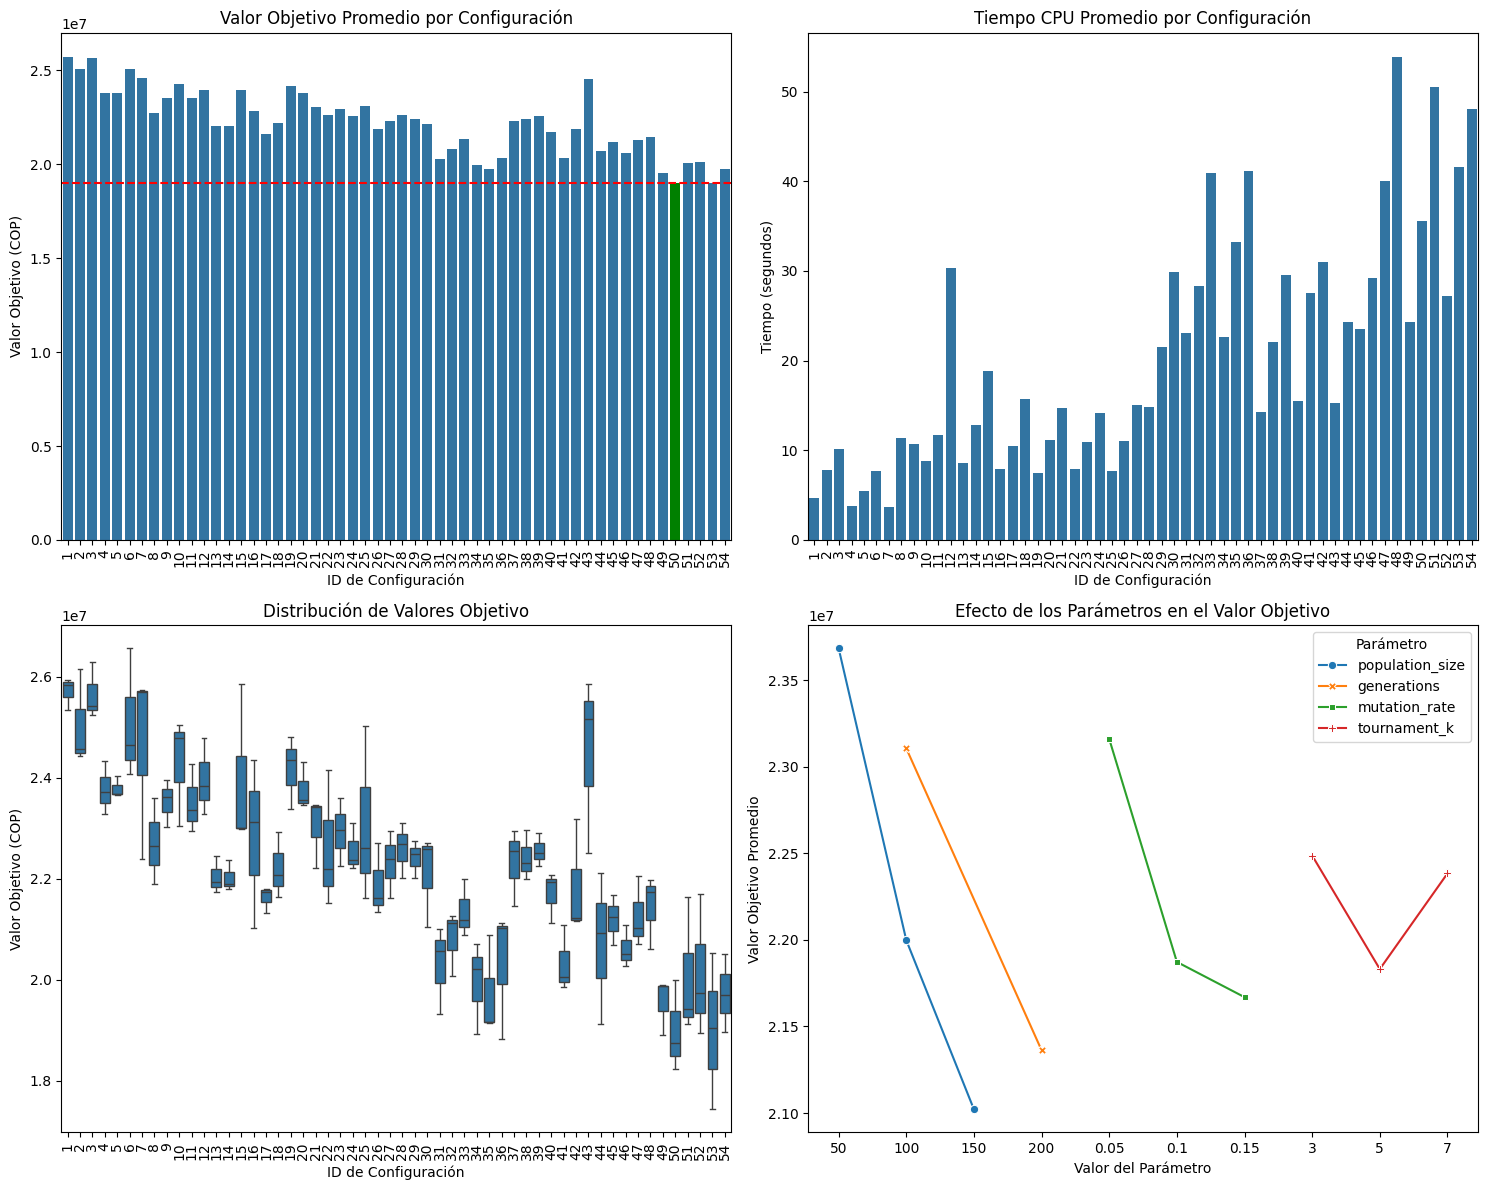

Visualizaciones guardadas en 'calibracion_graficos_3.png'
Best parameters for case 3: {'population_size': np.float64(150.0), 'generations': np.float64(200.0), 'mutation_rate': np.float64(0.1), 'tournament_k': np.float64(5.0)}
Results saved for case 3.
Solución guardada en formato solicitado: best_solution_case_3_formatted.csv


In [28]:

# CODIGO DE EXPERIMENTACION EL 2.2 Y 2.3 VAN ACA

# 4. CALIBRACIÓN Y EXPERIMENTACIÓN

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tqdm import tqdm
import random

def save_solution_in_requested_format(routes, depot_id, filename="best_solution_formatted.csv"):
    """
    Guarda la solución de rutas en el formato específico solicitado:
    VehicleId, DepotId, InitialLoad, RouteSequence, ClientsServed, DemandsSatisfied,
    TotalDistance, TotalTime, FuelCost
    """
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Escribir encabezado
        writer.writerow(['VehicleId', 'DepotId', 'InitialLoad', 'RouteSequence', 'ClientsServed', 
                        'DemandsSatisfied', 'TotalDistance', 'TotalTime', 'FuelCost'])
        
        # Para cada ruta
        for i, (vehicle_idx, route) in enumerate(routes):
            if not route or len(route) <= 2:
                continue
                
            # Identificadores
            vehicle_id = f"VEH{(i+1):03d}"
            depot_id_str = depot_id
            
            # Calcular carga inicial (suma de las demandas de todos los clientes en la ruta)
            clients_in_route = [node for node in route if node != depot_id]
            initial_load = sum(GA_DATA["client_demands"].get(client, 0) for client in clients_in_route)
            
            # Secuencia de la ruta
            route_sequence = " - ".join(route)
            
            # Clientes atendidos (número)
            clients_served = len(clients_in_route)
            
            # Demandas satisfechas
            demands_satisfied = " - ".join([str(int(GA_DATA["client_demands"].get(client, 0))) 
                                          for client in clients_in_route])
            
            # Cálculo de distancia total
            total_distance = 0
            for k_idx in range(len(route) - 1):
                u, v = route[k_idx], route[k_idx+1]
                total_distance += GA_DATA["distance_matrix"].get((u, v), 0)
            
            # Tiempo total (estimando un tiempo promedio de 2.5 minutos por km)
            # Este es un valor arbitrario, ajusta según tus necesidades
            avg_time_per_km = 2.5  # minutos por km
            total_time = total_distance * avg_time_per_km
            
            # Costo de combustible (usando la constante C_KM)
            fuel_cost = int(total_distance * C_KM)
            
            # Escribir la fila
            writer.writerow([
                vehicle_id,
                depot_id_str,
                int(initial_load),
                route_sequence,
                clients_served,
                demands_satisfied,
                f"{total_distance:.1f}",
                f"{total_time:.1f}",
                fuel_cost
            ])
    
    print(f"Solución guardada en formato solicitado: {filename}")


def calibrate_genetic_algorithm(data_case="Base"):
    """
    Ejecuta un proceso estructurado de calibración para el algoritmo genético
    usando un diseño factorial completo y múltiples corridas por configuración.
    """
    # Cargar datos para el caso seleccionado
    print(f"\n--- INICIANDO CALIBRACIÓN PARA CASO: {data_case} ---\n")
    load_data(data_case)
    
    # Definir parámetros a calibrar y sus rangos
    parameter_ranges = {
        'population_size': [50, 100, 150],
        'generations': [100, 200],
        'mutation_rate': [0.05, 0.10, 0.15],
        'tournament_k': [3, 5, 7]
    }
    
    # Crear todas las combinaciones posibles de parámetros
    param_keys = list(parameter_ranges.keys())
    param_values = list(parameter_ranges.values())
    configurations = list(product(*param_values))
    
    # Preparar DataFrame para almacenar resultados
    results = []
    
    # Variables para rastrear la mejor solución global durante toda la calibración
    best_overall_fitness = float('inf')
    best_overall_routes = None
    
    
    # Semillas para reproducibilidad
    seeds = [42, 123, 7890]  # Diferentes semillas para cada ejecución
    num_runs = len(seeds)  # 3 ejecuciones independientes por configuración
    
    print(f"Plan experimental: {len(configurations)} configuraciones × {num_runs} corridas = {len(configurations)*num_runs} experimentos")
    print("Parámetros evaluados:", parameter_ranges)
    
    # Ejecutar experimentos para cada configuración
    for config_id, config in enumerate(tqdm(configurations, desc="Progreso de calibración")):
        config_params = dict(zip(param_keys, config))
        print(f"\nConfiguración #{config_id+1}/{len(configurations)}: {config_params}")
        
        for run, seed in enumerate(seeds):
            print(f"  Corrida {run+1}/{num_runs} (semilla: {seed})")
            
            # Establecer semillas para reproducibilidad
            random.seed(seed)
            np.random.seed(seed)
            
            # Medir tiempo de CPU
            start_time = time.time()
            
            # Ejecutar algoritmo con los parámetros actuales
            best_chromosome, best_fitness, ga_log = run_genetic_algorithm_cvrp(
                GA_DATA,
                pop_size=config_params['population_size'],
                generations=config_params['generations'],
                mutation_rate=config_params['mutation_rate'],
                tournament_k=config_params['tournament_k']
            )
            
            # Decodificar solución para obtener rutas y calcular métricas
            final_routes, final_cost, final_penalty = decode_chromosome_to_routes(best_chromosome, GA_DATA)
            
            # Guardar las mejores rutas globales
            if best_fitness < best_overall_fitness:
                best_overall_fitness = best_fitness
                best_overall_routes = final_routes
            
            # Calcular tiempo transcurrido
            end_time = time.time()
            cpu_time = end_time - start_time
            
            # Calcular métricas adicionales
            num_vehicles = len(final_routes)
            total_distance = sum([
                sum([GA_DATA["distance_matrix"].get((route[i], route[i+1]), 0) 
                for i in range(len(route)-1)])
                for _, route in final_routes
            ])
            
            # Almacenar resultados
            results.append({
                'config_id': config_id + 1,
                'run': run + 1,
                'seed': seed,
                'cpu_time': cpu_time,
                'objective_value': best_fitness,
                'final_cost': final_cost,
                'penalty': final_penalty,
                'num_vehicles': num_vehicles,
                'total_distance': total_distance,
                'converged_at': len(ga_log),
                **config_params  # Incluir todos los parámetros
            })
    
    # Convertir a DataFrame
    results_df = pd.DataFrame(results)
    
    # Calcular estadísticas por configuración
    stats_df = results_df.groupby('config_id').agg(
        mean_obj=('objective_value', 'mean'),
        std_obj=('objective_value', 'std'),
        min_obj=('objective_value', 'min'),  # mejor valor (minimización)
        max_obj=('objective_value', 'max'),  # peor valor (minimización)
        mean_time=('cpu_time', 'mean'),
        mean_vehicles=('num_vehicles', 'mean'),
        mean_distance=('total_distance', 'mean')
    ).reset_index()
    
    # Unir estadísticas con información de parámetros
    for param in param_keys:
        stats_df[param] = [results_df[results_df['config_id'] == cid][param].iloc[0] for cid in stats_df['config_id']]
    
    # Encontrar la mejor configuración (problema de minimización)
    best_config_idx = stats_df['mean_obj'].idxmin()
    best_config = stats_df.iloc[best_config_idx]
    
    # Mostrar resultados
    print("\n" + "="*60)
    print("RESULTADOS DE LA CALIBRACIÓN")
    print("="*60)
    print("\nMejor configuración encontrada:")
    print(f"  Config #{best_config['config_id']}")
    for param in param_keys:
        print(f"  {param}: {best_config[param]}")
    print("\nEstadísticas de la mejor configuración:")
    print(f"  Valor objetivo promedio: {best_config['mean_obj']:,.2f}")
    print(f"  Desviación estándar: {best_config['std_obj']:,.2f}")
    print(f"  Mejor valor: {best_config['min_obj']:,.2f}")
    print(f"  Peor valor: {best_config['max_obj']:,.2f}")
    print(f"  Tiempo CPU promedio: {best_config['mean_time']:.2f} segundos")
    print(f"  Vehículos promedio: {best_config['mean_vehicles']:.2f}")
    print(f"  Distancia total promedio: {best_config['mean_distance']:.2f} km")
    
    # Guardar resultados en CSV
    results_df.to_csv(f'calibracion_resultados_{data_case}.csv', index=False)
    stats_df.to_csv(f'calibracion_estadisticas_{data_case}.csv', index=False)
    print(f"\nResultados guardados en 'calibracion_resultados_{data_case}.csv' y 'calibracion_estadisticas_{data_case}.csv'")
    
    # Visualizaciones
    plt.figure(figsize=(15, 12))
    
    # Gráfico 1: Valor objetivo promedio por configuración
    plt.subplot(2, 2, 1)
    ax = sns.barplot(x='config_id', y='mean_obj', data=stats_df)
    plt.title('Valor Objetivo Promedio por Configuración', fontsize=12)
    plt.xlabel('ID de Configuración')
    plt.ylabel('Valor Objetivo (COP)')
    plt.axhline(y=best_config['mean_obj'], color='red', linestyle='--')
    plt.xticks(rotation=90)
    
    # Destacar la mejor configuración
    best_bar = ax.patches[best_config_idx]
    best_bar.set_facecolor('green')
    
    # Gráfico 2: Tiempo CPU promedio por configuración
    plt.subplot(2, 2, 2)
    sns.barplot(x='config_id', y='mean_time', data=stats_df)
    plt.title('Tiempo CPU Promedio por Configuración', fontsize=12)
    plt.xlabel('ID de Configuración')
    plt.ylabel('Tiempo (segundos)')
    plt.xticks(rotation=90)
    
    # Gráfico 3: Distribución de valores objetivo por configuración
    plt.subplot(2, 2, 3)
    sns.boxplot(x='config_id', y='objective_value', data=results_df)
    plt.title('Distribución de Valores Objetivo', fontsize=12)
    plt.xlabel('ID de Configuración')
    plt.ylabel('Valor Objetivo (COP)')
    plt.xticks(rotation=90)
    
    # Gráfico 4: Análisis de parámetros para el valor objetivo
    plt.subplot(2, 2, 4)
    
    # Crear datos para el gráfico de efectos principales
    param_data = []
    for param in param_keys:
        for val in parameter_ranges[param]:
            subset = results_df[results_df[param] == val]
            param_data.append({
                'parameter': param,
                'value': str(val),  # Convertir a string para que funcione con cualquier tipo
                'objective_mean': subset['objective_value'].mean()
            })
    param_df = pd.DataFrame(param_data)
    
    # Graficar efectos principales
    sns.lineplot(x='value', y='objective_mean', hue='parameter', markers=True, 
                style='parameter', dashes=False, data=param_df)
    plt.title('Efecto de los Parámetros en el Valor Objetivo', fontsize=12)
    plt.ylabel('Valor Objetivo Promedio')
    plt.xlabel('Valor del Parámetro')
    plt.legend(title='Parámetro')
    
    plt.tight_layout()
    plt.savefig(f'calibracion_graficos_{data_case}.png', dpi=300)
    plt.show()
    
    print(f"Visualizaciones guardadas en 'calibracion_graficos_{data_case}.png'")
    
    # Devolver la mejor configuración de parámetros
    best_params = {param: best_config[param] for param in param_keys}
    return best_params, results_df, stats_df, best_overall_routes

# # Ejemplo de uso:
# if __name__ == "__main__":
    
#     for case_name in ["Base", "2", "3"]:
#         print(f"\n--- CALIBRATING FOR CASE: {case_name} ---")
        
        
#         best_params, results_df, stats_df, final_routes = calibrate_genetic_algorithm(case_name)
#         print(f"Best parameters for case {case_name}: {best_params}")
#         print(f"Results saved for case {case_name}.")

#         save_solution_in_requested_format(final_routes, GA_DATA["depot_id"],
#                          filename=f"best_solution_case_{case_name}_formatted.csv")

if __name__ == "__main__":
    results_by_case = {}
    
    for case_name in ["Base", "2", "3"]:
        print(f"\n--- CALIBRATING FOR CASE: {case_name} ---")
        
        # Cargar datos específicamente para este caso
        load_data(case_name)
        
        # Pre-check for unserviceable clients
        unserviceable_clients = []
        for cid, dem in GA_DATA["client_demands"].items():
            if dem > max(GA_DATA["vehicle_capacity"]):
                unserviceable_clients.append((cid, dem))
        if unserviceable_clients:
            print("\nWARNING: The following clients have demands greater than available vehicle capacities:")
            for cid, dem in unserviceable_clients:
                print(f"  - {cid}: Demand {dem}")
            print("These clients will likely lead to high penalties or prevent a fully feasible solution.\n")

        if not GA_DATA["client_ids"]:
            print(f"No clients loaded for case {case_name}. Skipping.")
            continue
        
        # Ejecutar calibración y obtener la mejor solución
        best_params, results_df, stats_df, best_routes = calibrate_genetic_algorithm(case_name)
        results_by_case[case_name] = {
            'params': best_params,
            'routes': best_routes,
            'results_df': results_df,
            'stats_df': stats_df
        }
        
        print(f"Best parameters for case {case_name}: {best_params}")
        print(f"Results saved for case {case_name}.")

        # Guardar la mejor solución encontrada en el formato requerido
        save_solution_in_requested_format(best_routes, GA_DATA["depot_id"],
                         filename=f"best_solution_case_{case_name}_formatted.csv")

## 3. Análisis comparativo


Originalmente, el problema del CVRP fue modelado en Pyomo considerando múltiples depósitos. Dada la complejidad del caso 3, la estrategia que se utilizó para resolver esta situación en el modelo de Pyomo fue dividir instancias grandes en subproblemas más manejables, asignando subconjuntos de clientes a diferentes depósitos. 
Sin embargo, para esta nueva entrega, el enfoque con algoritmos genéticos se implementó bajo un supuesto distinto: un único depósito central (el mismo del Caso Base), con capacidad infinita. Para poder comparar ambos enfoques (Pyomo y algoritmo genético) de manera justa, se hizo necesario adaptar el modelo en Pyomo para que también utilizara un único depósito sin restricciones de capacidad en los tres casos. 
Esta equivalencia fue posible para los Casos 1 y 2, que tienen una escala moderada y encontraba gap sin necesidad de dividir el problema. Sin embargo, al aplicar esta restricción unificada al Caso 3, se presentó una dificultad importante, ya que el modelo de Pyomo en el Caso 3 vuelve esencialmente al problema original, sin subdivisión por depósitos ni simplificaciones estructurales. Esto hace que el modelo sea excesivamente complejo y pesado computacionalmente.
A pesar de utilizar una máquina con suficientes recursos y dejar el modelo ejecutándose por más de 6 horas, no se logró obtener una solución para el Caso 3 en Pyomo. Esta incapacidad para resolver el modelo se debe a la combinación de factores como:
1. El gran número de variables y restricciones involucradas.
2. La ausencia de división por depósitos.
3. La escala del problema con una sola fuente de distribución

Debido a la imposibilidad de resolver el Caso 3 en Pyomo bajo las condiciones actuales, no se puede realizar una comparación directa y justa con la solución obtenida mediante el algoritmo genético. Por tanto, el análisis comparativo se limitará a los Casos 1 y 2, en los cuales ambos métodos pudieron ser ejecutados bajo condiciones equivalentes.

### 3.1 Metaheurístico vs. Pyomo


##### Calidad de la solución (Valor de la función objetivo - COP)

| Caso   | Pyomo | Algoritmo Genético |
|--------|-------|--------------------|
| Caso 1 |   X   |   4,724,007.03     |
| Caso 2 |   X   |    2,079,151.47   |
| Caso 3 |   X   |   18,237,329.28 |



##### Tiempo de ejecución (segundos)

| Caso   | Pyomo | Algoritmo Genético |
|--------|-------|--------------------|
| Caso 1 |   X   |         8.14          |
| Caso 2 |   X   |         0.46          |
| Caso 3 |   X   |         35.59          |



##### Uso de memoria (MB)

| Caso   | Pyomo | Algoritmo Genético |
|--------|-------|--------------------|
| Caso 1 |   X   |         X          |
| Caso 2 |   X   |         X          |
| Caso 3 |   X   |         X          |



##### Comportamiento al escalar


| Comparación     | Pyomo (∆ Obj.) | Pyomo (∆ Tiempo) | Genético (∆ Obj.) | Genético (∆ Tiempo) |
|-----------------|----------------|------------------|-------------------|---------------------|
| Caso 2 vs Caso 1|       X        |        X         |         X         |         X           |
| Caso 3 vs Caso 1|       X        |        X         |         X         |         X           |




Aunque no fue posible realizar una comparación directa de la calidad de las soluciones para el Caso 3 debido a que el modelo de Pyomo no logró encontrar una solución en más de 6 horas de ejecución, el experimento permite extraer una conclusión relevante desde el punto de vista computacional. El algoritmo genético, bajo las mismas condiciones de problema (un solo depósito con capacidad infinita), encontró una solución factible en menos de 5 minutos.

Esto evidencia que, si bien la solución obtenida con algoritmos genéticos no garantiza optimalidad, su capacidad para generar resultados viables en tiempos razonables lo hace mucho más práctico para problemas de gran escala, como el del Caso 3. Esta eficiencia convierte al enfoque metaheurístico en una alternativa valiosa cuando se enfrentan instancias complejas donde los métodos exactos se vuelven computacionalmente inviables.

### 3.2 Diferencias cualitativas en las rutas

##### Longitud de rutas

| Caso   | Pyomo | Algoritmo Genético |
|--------|-------|--------------------|
| Caso 1 |   X   |         22 821          |
| Caso 2 |   X   |         10 044           |
| Caso 3 |   X   |         88 103          |


##### Número de vehículos utilizados

| Caso   | Pyomo | Algoritmo Genético |
|--------|-------|--------------------|
| Caso 1 |   X   |         3          |
| Caso 2 |   X   |         1          |
| Caso 3 |   --   |         10          |


##### Balance de carga (NO SE A QUE SE REFIERE PERO PUEDE SER: desviación estándar o rango de carga por vehículo)

| Caso   | Pyomo | Algoritmo Genético |
|--------|-------|--------------------|
| Caso 1 |   X   |         X          |
| Caso 2 |   X   |         X          |
| Caso 3 |   X   |         X          |




### 3.3 Ventajas y desventajas de ambos enfoques

Aunque los algoritmos genéticos (GA) ofrecen claramente la ventaja de rapidez, evidenciamos que el GA completa la búsqueda mucho más rápido que Pyomo bajo cualquier configuración de timeout, su naturaleza heurística implica que no siempre garantizan la factibilidad ni la calidad de la solución, sin un ajuste cuidadoso de hiperparámetros, como tamaño de población, tasas de mutación y cruces, y esquemas de penalización por violaciones de restricciones, el GA puede producir soluciones inviables o subóptimas.

En contraste, Pyomo, al apoyarse en solvers matemáticos exactos, asegura factibilidad siempre que exista una solución, y con suficiente tiempo puede converger al óptimo global, además su salida es determinista y reproducible frente a la aleatoriedad inherente del GA, no obstante esa solidez pagada en tiempo de cómputo puede tornarse prohibitiva en problemas de gran escala o con plazos estrictos, donde el GA resulta más práctico, aunque sacrifica garantías de optimalidad, Pyomo requiere modelar explícitamente todas las restricciones y parámetros, lo que puede aumentar la complejidad de implementación, mientras que el GA admite un diseño más flexible de la función objetivo y restricciones implícitas mediante penalizaciones, por último la integración de criterios de robustez y sensibilidad ante cambios en los datos suele ser más directa en el contexto de programación matemática, aunque nuevos esquemas híbridos que combinan GA para exploración rápida con refinamientos locales de Pyomo pueden capturar lo mejor de ambos mundos.

## 4. Visualización de resultados

### 4.1 Evolución de la mejor solución 

In [29]:
# aca se grafica la curva de convergencia para los 3 casos

### 4.2 Rutas finales

In [30]:
# GRAFICO DE rutas finales superpuestas en el plano para metaheurístico y Pyomo.

### 4.3 Otros resultados

In [31]:
# ACA SE GRAFICA histogramas o cajas de distribución de cargas y longitudes de ruta